In [5]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# Keller's model

> In his original 1974 paper, Keller proposed a model to determine "how a runner should vary his speed $v(t)$ during a race of distance $D$ in order to run it in the shortest time". 

$$D = \int_0^T v(t) dt$$

> The velocity satisfies the equation of motion:

$$\frac{dv}{dt} + \frac{v}{\tau} = f(t)$$

> $v/\tau$ is a resistive force per unit mass, $\tau$ is a given constant, $f(t)$ is the propulsive force per unit mass, controlled by the runner. Furthermore, $\forall t \ f(t)\leq F$, where $F$ is a maximum value.  

> The force affects the quantity $E(t)$ of available oxygen in the muscles per unit mass (oxygen is consumed in reactions which release the energy used in running). Energy is used at the rate $f v$, the oxygen is supplied at a rate $\sigma$. The oxygen balance equation is:

$$\frac{d E}{d t} = \sigma - f v$$

> Eventually, Keller found $v(t)$, $f(t)$ and $E(t)$ that minimized the total running time $T$. 

> Let's use this model in our optimization problem of the rat running on a treadmill. Let's work entirely in the frame of the laboratory. 

> Taking $f$ as the control parameter, the state can be written as:

$$x = \begin{pmatrix}
x_0(t)\\
x_1(t)
\end{pmatrix}=
\begin{pmatrix}
\textrm{position}\\
\textrm{velocity}
\end{pmatrix}$$

$$\dot{x} = \begin{pmatrix}
x_1(t)\\
u - \frac{(x_1(t)-v_t)}{\tau}
\end{pmatrix}=
\begin{pmatrix}
\textrm{velocity}\\
\textrm{acceleration}
\end{pmatrix}$$

> The cost that we will minimize is:

$$E(x(t),u(t))=\int_0^T \frac{d E}{d t}=\int_0^T \left[\sigma - u\left(x_1(t) - v_t\right)\right] dt$$

> We know (from paper ***) that $v_{max}=\tau \times F$, so the only unknown parameters are $\tau$ and $\sigma$. These can be estimated using values computed for human beings. The influence of these parameters on the optimal trajectories is discussed in the following sections.

$$0.0 \leq x_0(t) \leq L_{tread}$$
$$-0.6 \leq x_1(t) \leq 0.1$$ 

The rat should only run against the treadmill with an absolute velocity $|v_{max}|=0.7$ m/s.

$$-\frac{|v_{max}|}{\tau} \leq f(t) \leq \frac{|v_{max}|}{\tau}$$

In [11]:
def penalty_function(x,t,mux,mut,kxpenalty,steepnesst,vtapis):
    '''This function generates a spatio-temporal energy barrier: spatially centered around x = 'mux', with steepness 'kxpenalty'
    and temporally centered around t = 'mut', with steepness 'steepnesst'.'''
    kTt = mut/steepnesst
    max_height=.4                   # cost of running 10s at the velocity of the treadmill (max penalty)
    amplitude = max_height/(1+np.exp((t-mut)/kTt))  # penalty maximum at t=mut...
    kTx = mux/kxpenalty
    return(10*amplitude/(1+np.exp((x-mux)/kTx)))       # ...and x=mux


def reward_function(x,t,mux,mut,steepnesst):
    '''This function generates a spatio-temporal energy valley: spatially centered around x = mux (gaussian
    with variance sigma2), and starting temporally at t = mut with a slope determined by steepnesst'''
    sigma1 = 3.0        #temporal variance (of associated gaussian)
    kT = mut/steepnesst
    amplitude = -np.exp(-(t-mut)**2/2/sigma1**2)/(1+np.exp((-(t-mut))/kT))  #asymmetric time evolution (x=0)
    sigma2=0.01
    return(10*amplitude*np.exp(-(x-mux)**2/2/sigma2**2))                   #spatio-temporal evolution


def heaviside(x,k,mu,amp):
    return(amp/(1+np.exp(-2*k*(x-mu))))

def reward_function2(t,dt,reward_max,x,sigma_x,mu_x):
    mu=7.0 #the reward peak is centered around this value
    coeff_rwd_decrease = (-0.38*reward_max+reward_max)/(15.0-mu) #experimental coefficient for the linear decrease of the reward
    amplitude = heaviside(x=t,k=100,mu=mu+dt,amp=reward_max/dt+coeff_rwd_decrease)+heaviside(x=t,k=100,mu=mu-dt,amp=-reward_max/dt)
    return(amplitude*np.exp(-(x-mu_x)**2/2/sigma_x**2))   

def penalty2(t,mut,kt,height,x,mux,kx):
    amplitude = heaviside(-t,kt,-mut,height)
    return(amplitude/(1+np.exp(2*(x-mux)*kx)))


def optimal_trajectory(tau_res,sigma,x0,xf,tf,vtapis,kxpenalty):
    '''This function takes parameters a, b, initial position x0 and final position xf and 
    computes the OC problem assuming either a linear cost (cost='linear', Int_0^T a+b*v dt), 
    or a quadratic one (cost='quadratic',Int_0^T a+b*v*v dt). It returns respectively the 
    optimal trajectory, the associated time array, the optimal 
    velocity and its associated time array.'''
    Ltread=0.9
    nk = 1000
    mu=0.1    # Control discretization
    kT=mu/1
    
    
    # Declare variables
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1], u -(x[1]-vtapis)/tau_res)
    rhs["L"] = sigma - u*(x[1]-vtapis)+reward_function2(t=t,dt=0.1,reward_max=100.0,x=x[0],sigma_x=0.1,mu_x=0.1)+penalty2(t=t,mut=7.0,kt=100,height=1.0,x=x[0],mux=0.1,kx=100)#+penalty_function(x=x[0],t=t,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)+reward_function(x=x[0],t=t,mux=0.1,mut=6.95,steepnesst=1000)
    
    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -0.7/tau_res
    u_max = -u_min
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   vtapis-0.7, -inf]
    x_max =  [Ltread,vtapis,  inf]
    xi_min = [x0,  vtapis-0.7,  -inf]
    xi_max = [x0,  vtapis,  inf]
    xf_min = [xf,  vtapis-0.7, -inf]
    xf_max = [xf,  vtapis,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)


In [12]:
# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 10.     # final time (duration of experiment)

sigma = 1.708
tau = 0.1
xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=tau,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    56996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6000

Total number of variables............................:    13010
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     9006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  78 -2.5027488e+007 1.51e-003 3.49e-001  -5.7 2.27e+005 -10.4 2.09e-001 4.16e-001f  1
  79 -2.5152222e+007 1.44e-003 3.31e-001  -5.7 2.46e+006 -10.0 9.78e-003 5.07e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.5210280e+007 1.35e-003 3.10e-001  -5.7 9.22e+005  -9.6 1.62e-002 6.30e-002f  1
  81 -2.5213088e+007 1.12e-003 2.57e-001  -5.7 1.62e+004  -7.8 5.52e-002 1.73e-001f  1
  82 -2.5239552e+007 1.94e-003 1.17e-001  -5.7 4.86e+004  -8.3 2.74e-001 5.44e-001f  1
  83 -2.5260653e+007 1.58e-003 9.54e-002  -5.7 1.15e+005  -8.8 3.01e-001 1.84e-001f  1
  84 -2.5383471e+007 1.43e-003 8.59e-002  -5.7 1.23e+006  -9.7 1.00e+000 9.95e-002f  1
  85 -2.5814802e+007 8.38e-004 2.12e+000  -5.7 1.04e+006  -9.8 1.64e-003 4.13e-001f  1
  86 -2.5843627e+007 7.74e-004 1.96e+000  -5.7 3.81e+005 -10.2 9.33e-002 7.57e-002f  1
  87 -2.5861383e+007 6.62e-004 1.68e+000  -5.7 1.23e+005  -9.8 5.55e-002 1.45e-001f  1
  88 -2.6108229e+007 1.31e-003 9.60e-001  -5.7 2.

 164 -3.5429817e+007 9.43e-005 4.59e+001  -5.7 1.08e+005  -8.9 5.50e-007 9.02e-002f  1
 165 -3.5511401e+007 6.50e-005 5.45e+002  -5.7 2.80e+005  -9.4 5.39e-007 2.92e-001f  1
 166 -3.5623050e+007 7.69e-005 4.38e+002  -5.7 5.67e+005  -9.8 1.07e-001 1.97e-001f  1
 167 -3.5825225e+007 1.41e-004 3.22e+002  -5.7 7.62e+005 -10.3 1.43e-001 2.65e-001f  1
 168 -3.5825258e+007 5.12e-004 1.46e+002  -5.7 5.95e+001  -5.4 1.00e+000 5.47e-001f  1
 169 -3.5825298e+007 4.03e-004 1.13e+002  -5.7 1.79e+002  -5.9 4.88e-005 2.26e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -3.5825368e+007 3.57e-004 9.79e+001  -5.7 5.36e+002  -6.3 2.48e-001 1.32e-001f  1
 171 -3.5826375e+007 1.32e-004 1.29e+002  -5.7 1.61e+003  -6.8 4.85e-006 6.26e-001f  1
 172 -3.5828144e+007 8.69e-005 8.15e+001  -5.7 4.82e+003  -7.3 1.16e-005 3.67e-001f  1
 173 -3.5834865e+007 4.89e-005 2.18e+002  -5.7 1.45e+004  -7.8 2.10e-006 4.65e-001f  1
 174 -3.5852521e+007 3.16e-005 2.36e+002  -5.7 4.

 252 -4.3467575e+007 5.64e-004 2.40e+003  -5.7 7.26e+004  -8.5 5.90e-001 3.29e-001f  1
 253 -4.3496190e+007 4.97e-004 2.08e+003  -5.7 2.18e+005  -8.9 6.95e-006 1.32e-001f  1
 254 -4.3577986e+007 4.04e-004 1.52e+003  -5.7 3.00e+005  -9.4 1.11e-006 2.72e-001f  1
 255 -4.4751042e+007 4.25e-004 1.21e+003  -5.7 5.88e+006 -10.4 6.24e-001 2.00e-001f  1
 256 -4.4752264e+007 4.24e-004 1.21e+003  -5.7 4.73e+005 -10.8 1.26e-005 2.58e-003f  1
 257 -4.4809183e+007 4.22e-004 1.21e+003  -5.7 1.41e+007 -11.3 2.70e-003 4.05e-003f  1
 258 -4.5018047e+007 3.83e-004 8.01e+002  -5.7 6.23e+005 -10.9 8.23e-003 3.35e-001f  1
 259 -4.5180123e+007 5.36e-004 1.07e+002  -5.7 1.87e+005  -9.6 1.59e-001 8.67e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -4.5180166e+007 6.33e-004 5.29e+001  -5.7 8.51e+001  -5.5 1.00e+000 5.03e-001f  1
 261 -4.5180264e+007 1.18e-003 3.25e+001  -5.7 2.55e+002  -6.0 1.13e-005 3.86e-001f  1
 262 -4.5180353e+007 1.05e-003 2.87e+001  -5.7 7.

 341 -4.8445028e+007 1.32e-003 4.92e+001  -5.7 1.73e+005  -8.8 4.46e-006 1.15e-001f  1
 342 -4.8449538e+007 1.32e-003 4.92e+001  -5.7 6.86e+007  -8.9 4.51e-006 6.57e-005f  1
 343 -4.8460937e+007 1.29e-003 9.94e+001  -5.7 4.40e+005  -9.4 4.58e-007 2.59e-002f  1
 344 -4.8519103e+007 9.47e-004 7.29e+001  -5.7 2.18e+005  -8.9 9.34e-001 2.67e-001f  1
 345 -4.8547966e+007 8.43e-004 5.36e+001  -5.7 2.64e+005  -9.4 1.05e-004 1.09e-001f  1
 346 -4.8577516e+007 6.06e-004 3.86e+001  -5.7 1.05e+005  -9.0 6.47e-002 2.81e-001f  1
 347 -4.8579218e+007 5.17e-004 3.29e+001  -5.7 1.15e+004  -7.7 3.31e-001 1.48e-001f  1
 348 -4.8613110e+007 2.62e-005 2.00e+002  -5.7 3.39e+004  -8.1 1.06e-004 1.00e+000f  1
 349 -4.8652015e+007 6.79e-007 2.52e-004  -5.7 3.89e+004  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -4.8768731e+007 1.67e-007 2.50e-004  -5.7 1.17e+005  -8.7 1.00e+000 1.00e+000f  1
 351 -4.8900036e+007 1.67e-007 2.50e-004  -5.7 1.

 429 -5.9786043e+007 5.61e-005 7.45e+001  -5.7 4.06e+004  -8.2 6.80e-008 4.04e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 -5.9786143e+007 5.58e-005 7.41e+001  -5.7 1.52e+004  -7.8 5.37e-006 6.55e-003f  1
 431 -5.9787464e+007 5.41e-005 7.19e+001  -5.7 4.57e+004  -8.3 3.23e-006 2.89e-002f  1
 432 -5.9787616e+007 5.37e-005 6.56e+001  -5.7 1.71e+004  -7.8 1.90e-006 8.82e-003f  1
 433 -5.9789347e+007 5.36e-005 6.56e+001  -5.7 1.67e+010  -8.8 5.61e-008 1.03e-007f  1
 434 -5.9791147e+007 5.20e-005 1.56e+003  -5.7 5.78e+004  -8.4 3.95e-008 3.11e-002f  1
 435 -5.9791222e+007 5.18e-005 1.56e+003  -5.7 2.17e+004  -7.9 1.14e-007 3.50e-003f  1
 436 -5.9791243e+007 5.18e-005 1.56e+003  -5.7 4.66e+004  -8.4 1.06e-007 4.41e-004f  1
 437 -5.9791287e+007 5.17e-005 1.55e+003  -5.7 6.57e+004  -8.5 1.67e-007 6.66e-004f  1
 438 -5.9791457e+007 5.14e-005 1.54e+003  -5.7 2.38e+004  -8.0 4.62e-006 7.13e-003f  1
 439 -5.9800318e+007 4.95e-005 1.49e+003  -5.7 2.

 521 -7.8889310e+007 1.69e-005 4.46e-001  -5.7 2.75e+005 -12.6 1.00e+000 1.00e+000f  1
 522 -8.2483705e+007 8.33e-005 1.37e+000  -5.7 3.59e+006 -12.6 1.00e+000 1.00e+000f  1
 523 -8.2586128e+007 3.35e-005 6.61e-001  -5.7 1.19e+005 -13.1 1.00e+000 8.62e-001f  1
 524 -8.2869729e+007 8.00e-006 5.05e-001  -5.7 2.84e+005 -11.8 1.00e+000 1.00e+000f  1
 525 -8.5208219e+007 3.50e-005 5.61e-001  -5.7 2.34e+006 -12.7 1.00e+000 1.00e+000f  1
 526 -8.5211646e+007 7.57e-005 4.35e-001  -5.7 1.53e+004  -7.8 1.00e+000 2.24e-001f  1
 527 -8.5223940e+007 7.24e-005 3.97e-001  -5.7 1.38e+005  -8.7 2.17e-001 8.93e-002f  1
 528 -8.5256293e+007 4.61e-003 1.48e-001  -5.7 5.16e+004  -8.3 9.08e-002 6.27e-001f  1
 529 -8.5259249e+007 3.95e-003 1.26e-001  -5.7 1.93e+004  -7.9 6.31e-002 1.53e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530 -8.5261265e+007 2.91e-003 9.07e-002  -5.7 7.26e+003  -7.5 2.49e-001 2.78e-001f  1
 531 -8.5283036e+007 2.05e-005 2.48e+000  -5.7 2.

 615 -9.1316234e+007 4.51e-004 2.51e+002  -5.7 9.71e+004  -8.6 6.55e-007 7.27e-002f  1
 616 -9.1373332e+007 3.65e-004 1.99e+002  -5.7 2.53e+005  -9.1 1.28e-004 2.26e-001f  1
 617 -9.1696138e+007 3.18e-003 2.27e+002  -5.7 3.83e+005  -9.5 2.60e-007 8.42e-001f  1
 618 -9.1752129e+007 2.68e-003 1.88e+002  -5.7 3.27e+005  -9.1 2.03e-003 1.71e-001f  1
 619 -9.1754458e+007 2.63e-003 1.84e+002  -5.7 1.11e+005  -8.7 2.69e-006 2.11e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620 -9.1874313e+007 4.82e-004 2.50e+001  -5.7 1.39e+005  -9.2 8.03e-003 8.65e-001f  1
 621 -9.2016624e+007 2.76e-004 1.68e+001  -5.7 2.00e+005  -9.6 5.95e-005 7.11e-001f  1
 622 -9.2212186e+007 1.50e-005 8.57e-001  -5.7 1.96e+005 -10.1 2.61e-001 1.00e+000f  1
 623 -9.2401742e+007 3.86e-005 7.27e-001  -5.7 1.24e+006  -9.7 4.64e-001 1.52e-001f  1
 624 -9.2451308e+007 3.13e-005 2.59e+001  -5.7 1.75e+005  -8.8 2.13e-005 2.83e-001f  1
 625 -9.2467526e+007 2.43e-004 1.95e+001  -5.7 6.

 706 -9.9840705e+007 8.18e-004 1.37e+001  -5.7 6.07e+004  -8.4 5.53e-007 1.67e-001f  1
 707 -9.9841046e+007 8.19e-004 2.72e+001  -5.7 1.28e+005  -8.9 3.45e-007 2.66e-003f  1
 708 -9.9851187e+007 7.47e-004 9.27e+002  -5.7 6.84e+004  -8.4 1.34e-006 1.48e-001f  1
 709 -9.9859443e+007 7.10e-004 8.28e+002  -5.7 7.70e+004  -8.5 4.89e-007 1.07e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710 -9.9863544e+007 6.47e-004 7.10e+002  -5.7 2.89e+004  -8.1 1.21e-004 1.42e-001f  1
 711 -9.9880481e+007 1.02e-003 4.30e+002  -5.7 4.29e+004  -8.5 4.15e-007 3.95e-001f  1
 712 -9.9882793e+007 1.04e-003 4.23e+002  -5.7 1.44e+005  -9.0 2.90e-007 1.60e-002f  1
 713 -9.9912261e+007 1.20e-003 2.69e+002  -5.7 9.72e+004  -8.6 1.01e-004 3.03e-001f  1
 714 -9.9918037e+007 1.12e-003 2.26e+002  -5.7 3.59e+004  -8.2 1.58e-006 1.61e-001f  1
 715 -9.9946900e+007 8.59e-004 1.59e+002  -5.7 9.76e+004  -8.6 4.61e-005 2.96e-001f  1
 716 -9.9960918e+007 8.07e-004 1.41e+002  -5.7 1.

 794 -1.1075115e+008 2.41e-006 4.96e-001  -5.7 2.81e+005 -11.7 1.00e+000 1.00e+000f  1
 795 -1.1096637e+008 2.64e-006 7.33e-001  -5.7 2.15e+005 -12.2 1.00e+000 1.00e+000f  1
 796 -1.1107431e+008 1.45e-006 4.31e-001  -5.7 1.50e+005 -12.6 1.00e+000 7.19e-001f  1
 797 -1.1147099e+008 4.55e-006 3.67e+001  -5.7 3.97e+005 -12.2 6.81e-004 1.00e+000f  1
 798 -1.1162193e+008 1.47e-006 4.02e-001  -5.7 1.51e+005 -12.7 1.00e+000 1.00e+000f  1
 799 -1.1213607e+008 3.71e-006 1.09e+000  -5.7 5.14e+005 -13.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 -1.1217419e+008 9.06e-007 2.43e-001  -5.7 3.81e+004 -11.8 1.00e+000 1.00e+000f  1
 801 -1.1237225e+008 3.18e-006 1.64e+000  -5.7 2.65e+005 -12.3 1.00e+000 7.48e-001f  1
 802 -1.1260453e+008 1.46e-006 8.43e-001  -5.7 2.32e+005 -12.8 4.20e-001 1.00e+000f  1
 803 -1.1302778e+008 2.02e-006 6.73e-001  -5.7 4.23e+005 -13.3 1.00e+000 1.00e+000f  1
 804 -1.1337923e+008 3.54e-006 9.83e-001  -5.7 3.

 887 -1.3721873e+008 3.09e-005 2.18e+000  -5.7 7.60e+004  -8.6 2.13e-003 6.77e-001f  1
 888 -1.3724049e+008 2.69e-005 1.74e+000  -5.7 1.08e+005  -9.1 1.42e-001 2.01e-001f  1
 889 -1.3729919e+008 2.36e-005 1.46e+000  -5.7 3.67e+005  -9.2 7.90e-001 1.60e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890 -1.3822567e+008 7.27e-006 1.17e+003  -5.7 9.26e+005  -9.6 9.16e-006 1.00e+000f  1
 891 -1.3826643e+008 6.06e-006 9.77e+002  -5.7 2.46e+005  -9.2 2.76e-001 1.66e-001f  1
 892 -1.3835676e+008 2.02e-006 3.26e+002  -5.7 1.36e+005  -8.8 4.26e-001 6.66e-001f  1
 893 -1.3882162e+008 1.53e-005 2.43e+003  -5.7 4.65e+005  -9.3 8.69e-006 1.00e+000f  1
 894 -1.3887683e+008 3.13e-005 1.20e+003  -5.7 1.09e+005  -8.8 6.38e-001 5.05e-001f  1
 895 -1.3890552e+008 2.37e-005 6.73e+002  -5.7 6.54e+004  -8.4 3.78e-001 4.39e-001f  1
 896 -1.3899403e+008 1.43e-005 3.68e+002  -5.7 1.95e+005  -8.9 1.00e+000 4.53e-001f  1
 897 -1.3906612e+008 1.01e-006 1.60e+003  -5.7 7.

 979 -1.5457049e+008 5.68e-007 2.54e-004  -5.7 1.09e+005  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980 -1.5461147e+008 5.25e-007 2.54e-004  -5.7 4.10e+004  -8.2 1.00e+000 1.00e+000f  1
 981 -1.5473440e+008 4.99e-007 3.64e-004  -5.7 1.23e+005  -8.7 1.00e+000 1.00e+000f  1
 982 -1.5583660e+008 4.61e-007 7.51e-003  -5.7 1.10e+006  -9.6 1.00e+000 1.00e+000f  1
 983 -1.5625080e+008 5.44e-007 5.43e-003  -5.7 4.14e+005  -9.2 1.00e+000 1.00e+000f  1
 984 -1.5627025e+008 4.75e-007 2.50e-004  -5.7 1.95e+004  -7.9 1.00e+000 1.00e+000f  1
 985 -1.5632721e+008 4.21e-005 1.12e-001  -5.7 8.96e+005  -8.8 4.90e-002 6.36e-002f  1
 986 -1.5660836e+008 1.37e-004 2.69e-001  -5.7 3.85e+005  -9.3 4.90e-001 7.30e-001f  1
 987 -1.5664146e+008 1.30e-004 2.56e-001  -5.7 6.90e+005  -9.8 6.07e-002 4.80e-002f  1
 988 -1.5691595e+008 3.84e-005 3.96e-001  -5.7 3.60e+005  -9.4 1.67e-001 7.63e-001f  1
 989 -1.5699185e+008 3.10e-005 2.60e-001  -5.7 2.

1067 -1.7889399e+008 5.25e-007 6.11e-004  -5.7 2.28e+004  -8.0 1.00e+000 1.00e+000f  1
1068 -1.7890255e+008 5.25e-007 2.50e-004  -5.7 8.56e+003  -7.5 1.00e+000 1.00e+000f  1
1069 -1.7892825e+008 5.05e-007 2.51e-004  -5.7 2.57e+004  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070 -1.7900532e+008 5.49e-007 2.61e-004  -5.7 7.71e+004  -8.5 1.00e+000 1.00e+000f  1
1071 -1.7923630e+008 5.48e-007 2.48e-003  -5.7 2.31e+005  -9.0 1.00e+000 1.00e+000f  1
1072 -1.7992890e+008 5.48e-007 7.75e-003  -5.7 6.93e+005  -9.4 1.00e+000 1.00e+000f  1
1073 -1.8046882e+008 1.56e-005 2.66e-001  -5.7 6.40e+005  -9.5 1.00e+000 8.43e-001f  1
1074 -1.8068048e+008 1.01e-005 7.39e-002  -5.7 2.93e+005  -9.1 3.34e-002 7.23e-001f  1
1075 -1.8084784e+008 1.20e-005 9.91e-002  -5.7 1.12e+006 -10.0 3.56e-002 1.49e-001f  1
1076 -1.8089383e+008 1.17e-005 9.24e-002  -5.7 1.59e+006 -11.0 3.26e-002 2.90e-002f  1
1077 -1.8093238e+008 6.17e-005 1.25e-001  -5.7 1.

1153 -1.8996125e+008 7.20e-004 4.96e+001  -5.7 1.96e+005  -8.9 2.17e-007 3.68e-002f  1
1154 -1.8996595e+008 6.95e-004 4.66e+001  -5.7 7.74e+004  -8.5 2.05e-007 6.09e-002f  1
1155 -1.9011332e+008 6.63e-005 2.56e+002  -5.7 1.47e+005  -9.0 1.13e-006 1.00e+000f  1
1156 -1.9011527e+008 1.43e-004 2.56e+002  -5.7 2.00e+007  -8.5 1.55e-004 9.72e-005f  1
1157 -1.9017403e+008 2.68e-004 1.99e+002  -5.7 2.61e+005  -9.0 4.19e-006 2.25e-001f  1
1158 -1.9017404e+008 2.77e-004 1.99e+002  -5.7 9.80e+004  -8.6 3.63e-006 5.68e-005f  1
1159 -1.9018923e+008 2.71e-004 1.88e+002  -5.7 2.93e+005  -9.1 6.31e-007 5.18e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160 -1.9021516e+008 2.67e-004 1.79e+002  -5.7 8.85e+005  -9.5 8.22e-007 2.93e-002f  1
1161 -1.9106107e+008 1.76e-004 6.93e+001  -5.7 1.38e+006 -10.0 2.34e-006 6.14e-001f  1
1162 -1.9106111e+008 2.60e-004 5.73e+001  -5.7 2.42e+002  -6.0 5.99e-001 1.73e-001f  1
1163 -1.9106127e+008 2.04e-004 5.70e+001  -5.7 7.

1247 -2.0033193e+008 5.93e-007 2.51e-004  -5.7 3.69e+004  -8.2 1.00e+000 1.00e+000f  1
1248 -2.0044260e+008 6.67e-007 2.50e-004  -5.7 1.11e+005  -8.6 1.00e+000 1.00e+000f  1
1249 -2.0048408e+008 5.48e-007 3.96e-004  -5.7 4.15e+004  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250 -2.0060857e+008 5.54e-007 2.56e-004  -5.7 1.24e+005  -8.7 1.00e+000 1.00e+000f  1
1251 -2.0074863e+008 5.25e-007 2.59e-004  -5.7 1.40e+005  -8.7 1.00e+000 1.00e+000f  1
1252 -2.0080115e+008 6.67e-007 2.50e-004  -5.7 5.25e+004  -8.3 1.00e+000 1.00e+000f  1
1253 -2.0095871e+008 5.58e-007 3.63e-004  -5.7 1.58e+005  -8.8 1.00e+000 1.00e+000f  1
1254 -2.0236418e+008 9.64e-007 1.22e-002  -5.7 1.41e+006  -9.8 1.00e+000 1.00e+000f  1
1255 -2.0243065e+008 6.67e-007 2.50e-004  -5.7 6.65e+004  -8.4 1.00e+000 1.00e+000f  1
1256 -2.0301510e+008 6.21e-007 2.17e-002  -5.7 5.84e+005  -9.4 1.00e+000 1.00e+000f  1
1257 -2.0309923e+008 8.31e-007 2.51e-004  -5.7 8.

1337 -2.1650552e+008 8.11e-004 1.06e+002  -5.7 2.30e+005  -9.1 4.47e-005 5.83e-001f  1
1338 -2.1654059e+008 7.19e-004 9.40e+001  -5.7 3.12e+005  -9.6 1.36e-001 1.12e-001f  1
1339 -2.1661919e+008 6.20e-004 8.11e+001  -5.7 5.73e+005 -10.1 8.25e-002 1.37e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340 -2.1679915e+008 2.11e-004 4.94e-001  -5.7 1.80e+005  -9.7 1.32e-001 1.00e+000f  1
1341 -2.1704623e+008 1.61e-003 5.59e-001  -5.7 3.42e+005 -10.1 2.70e-001 7.23e-001f  1
1342 -2.1798827e+008 6.47e-004 2.10e-001  -5.7 1.32e+006 -10.2 7.82e-001 7.13e-001f  1
1343 -2.1799037e+008 5.87e-004 1.90e-001  -5.7 2.23e+004  -7.9 7.54e-003 9.41e-002f  1
1344 -2.1803318e+008 4.75e-003 6.90e+001  -5.7 6.67e+004  -8.4 1.11e-005 6.41e-001f  1
1345 -2.1806251e+008 4.08e-003 5.69e+001  -5.7 1.67e+005  -8.9 6.94e-004 1.76e-001f  1
1346 -2.1818219e+008 3.43e-003 1.46e+002  -5.7 6.00e+005  -9.4 2.38e-006 2.00e-001f  1
1347 -2.1819631e+008 3.23e-003 1.37e+002  -5.7 2.

1432 -2.2905754e+008 2.55e-005 7.40e-001  -5.7 1.42e+001  -3.6 1.12e-001 8.18e-003f  1
1433 -2.2905754e+008 2.30e-005 6.50e-001  -5.7 3.30e+000  -4.1 3.96e-004 1.22e-001f  1
1434 -2.2905754e+008 2.12e-005 5.90e-001  -5.7 9.84e+000  -4.6 6.98e-001 9.29e-002f  1
1435 -2.2905757e+008 1.72e-005 1.45e+000  -5.7 2.95e+001  -5.1 7.26e-003 1.00e+000f  1
1436 -2.2905766e+008 8.16e-007 2.50e-004  -5.7 8.85e+001  -5.5 1.00e+000 1.00e+000f  1
1437 -2.2905793e+008 6.59e-007 2.50e-004  -5.7 2.65e+002  -6.0 1.00e+000 1.00e+000f  1
1438 -2.2905872e+008 7.87e-007 2.50e-004  -5.7 7.96e+002  -6.5 1.00e+000 1.00e+000f  1
1439 -2.2906111e+008 7.37e-007 2.50e-004  -5.7 2.39e+003  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1440 -2.2906828e+008 7.87e-007 2.50e-004  -5.7 7.17e+003  -7.5 1.00e+000 1.00e+000f  1
1441 -2.2908974e+008 7.41e-007 1.44e-003  -5.7 2.15e+004  -7.9 1.00e+000 1.00e+000f  1
1442 -2.2909780e+008 7.70e-007 2.50e-004  -5.7 8.

1526 -2.3559993e+008 1.62e-004 3.34e+000  -5.7 1.72e+005  -9.1 8.37e-002 9.10e-001f  1
1527 -2.3560942e+008 4.08e-004 3.06e+000  -5.7 1.14e+005  -8.7 5.26e-002 8.31e-002f  1
1528 -2.3570280e+008 6.20e-004 4.26e+000  -5.7 3.64e+005  -9.2 8.16e-006 2.57e-001f  1
1529 -2.3570548e+008 6.55e-004 4.16e+000  -5.7 1.21e+005  -8.7 2.97e-007 2.22e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530 -2.3575180e+008 6.19e-004 1.25e+001  -5.7 4.09e+005  -9.2 2.02e-006 1.13e-001f  1
1531 -2.3575271e+008 6.25e-004 1.24e+001  -5.7 1.06e+005  -8.8 7.57e-008 8.50e-003f  1
1532 -2.3577218e+008 6.11e-004 2.84e+001  -5.7 4.47e+005  -9.3 3.13e-007 4.36e-002f  1
1533 -2.3582318e+008 6.18e-004 2.79e+001  -5.7 2.86e+006 -10.2 8.05e-008 1.79e-002f  1
1534 -2.3608964e+008 7.61e-004 1.94e+000  -5.7 1.48e+006 -10.7 2.27e-006 1.80e-001f  1
1535 -2.3609200e+008 1.05e-003 1.44e+000  -5.7 9.11e+003  -7.6 1.37e-001 2.59e-001f  1
1536 -2.3609341e+008 1.04e-003 5.61e-001  -5.7 2.

1618 -2.4248976e+008 2.62e-005 2.45e-001  -5.7 9.62e+004  -8.6 1.00e+000 2.41e-001f  1
1619 -2.4262073e+008 1.55e-005 6.35e+001  -5.7 2.49e+005  -9.1 2.54e-005 5.27e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620 -2.4263073e+008 1.53e-005 5.86e+001  -5.7 1.29e+005  -9.5 4.14e-002 7.75e-002f  1
1621 -2.4288294e+008 5.91e-005 3.00e+001  -5.7 5.16e+005 -10.0 1.28e-001 4.89e-001f  1
1622 -2.4309552e+008 1.89e-003 6.93e-001  -5.7 2.13e+005  -9.6 2.13e-001 1.00e+000f  1
1623 -2.4312509e+008 3.68e-003 2.45e-001  -5.7 4.57e+004  -8.3 3.98e-001 6.47e-001f  1
1624 -2.4313366e+008 3.57e-003 2.29e-001  -5.7 1.37e+005  -8.7 2.71e-005 6.25e-002f  1
1625 -2.4315870e+008 3.07e-003 1.92e-001  -5.7 1.54e+005  -8.8 7.71e-002 1.62e-001f  1
1626 -2.4316135e+008 2.94e-003 2.46e+000  -5.7 5.78e+004  -8.4 1.09e-006 4.58e-002f  1
1627 -2.4323908e+008 6.84e-004 6.75e+002  -5.7 7.77e+004  -8.8 4.90e-007 1.00e+000f  1
1628 -2.4323915e+008 6.86e-004 3.27e+002  -5.7 1.

1705 -2.4948143e+008 1.29e-003 1.15e+001  -5.7 1.79e+004  -7.9 8.59e-007 2.74e-002f  1
1706 -2.4948150e+008 1.28e-003 1.37e+001  -5.7 6.70e+003  -7.4 1.39e-007 1.11e-002f  1
1707 -2.4948158e+008 1.28e-003 1.36e+001  -5.7 2.01e+004  -7.9 6.18e-008 3.64e-003f  1
1708 -2.4948199e+008 1.21e-003 6.83e+000  -5.7 7.54e+003  -7.5 9.07e-007 5.41e-002f  1
1709 -2.4948258e+008 1.18e-003 9.21e+000  -5.7 2.26e+004  -8.0 7.14e-007 2.65e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1710 -2.4948327e+008 1.17e-003 1.54e+001  -5.7 6.79e+004  -8.4 1.18e-007 1.01e-002f  1
1711 -2.4948347e+008 1.17e-003 1.53e+001  -5.7 4.42e+004  -8.9 5.61e-008 4.41e-003f  1
1712 -2.4954263e+008 1.04e-003 4.72e+000  -5.7 4.96e+005  -9.4 8.32e-007 1.19e-001f  1
1713 -2.4955597e+008 1.05e-003 8.02e+000  -5.7 1.82e+006  -9.9 1.05e-007 7.34e-003f  1
1714 -2.4971781e+008 1.02e-003 2.59e+001  -5.7 2.36e+006 -10.3 2.60e-007 6.87e-002f  1
1715 -2.5005120e+008 6.62e-004 2.69e+001  -5.7 1.

1794 -2.8064493e+008 5.16e-005 5.88e+001  -5.7 1.01e+005  -8.6 3.42e-005 5.10e-001f  1
1795 -2.8069752e+008 5.30e-005 1.07e+002  -5.7 1.40e+005  -9.1 4.73e-006 3.75e-001f  1
1796 -2.8070222e+008 4.26e-005 7.18e+001  -5.7 1.42e+004  -7.8 2.05e-001 3.32e-001f  1
1797 -2.8073993e+008 1.85e-005 8.16e+000  -5.7 4.26e+004  -8.2 8.26e-002 8.86e-001f  1
1798 -2.8079461e+008 3.29e-005 2.99e+000  -5.7 8.62e+004  -8.7 5.80e-001 6.34e-001f  1
1799 -2.8087169e+008 6.78e-005 1.71e+000  -5.7 1.80e+005  -9.2 1.15e-001 4.28e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800 -2.8105568e+008 7.13e-004 1.01e+000  -5.7 4.49e+005  -9.7 1.94e-001 4.10e-001f  1
1801 -2.8105891e+008 1.63e-003 9.51e+000  -5.7 6.73e+003  -7.4 5.54e-005 4.79e-001f  1
1802 -2.8106038e+008 1.57e-003 8.82e+000  -5.7 2.02e+004  -7.9 1.24e-006 7.31e-002f  1
1803 -2.8106972e+008 1.39e-003 1.71e+002  -5.7 6.06e+004  -8.4 1.78e-006 1.54e-001f  1
1804 -2.8108075e+008 1.35e-003 1.58e+002  -5.7 1.

1883 -3.0030991e+008 1.39e-003 8.35e-002  -5.7 2.13e+005  -8.9 5.26e-001 4.67e-001f  1
1884 -3.0031523e+008 1.32e-003 1.54e-001  -5.7 8.00e+004  -8.5 1.54e-005 6.65e-002f  1
1885 -3.0034084e+008 1.20e-003 1.38e-001  -5.7 2.40e+005  -9.0 4.71e-003 1.07e-001f  1
1886 -3.0084119e+008 1.15e-003 6.42e+001  -5.7 5.01e+005  -9.5 1.09e-006 9.99e-001f  1
1887 -3.0093794e+008 9.86e-004 2.71e-001  -5.7 9.68e+004  -9.0 3.59e-003 1.00e+000f  1
1888 -3.0094090e+008 9.56e-004 2.55e-001  -5.7 6.57e+004  -9.5 5.76e-001 4.50e-002f  1
1889 -3.0094606e+008 8.27e-004 2.23e-001  -5.7 3.80e+004  -8.2 1.21e-002 1.36e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1890 -3.0102357e+008 4.94e-003 6.88e-002  -5.7 1.14e+005  -8.7 8.57e-002 6.81e-001f  1
1891 -3.0102600e+008 4.74e-003 4.82e-001  -5.7 4.27e+004  -8.2 2.30e-006 5.69e-002f  1
1892 -3.0112188e+008 1.53e-005 3.28e-001  -5.7 9.59e+004  -8.7 1.71e-002 1.00e+000f  1
1893 -3.0112744e+008 3.80e-005 2.87e-001  -5.7 4.

1977 -3.1050390e+008 1.62e-003 4.45e+000  -5.7 2.79e+001  -5.0 1.00e+000 3.95e-001f  1
1978 -3.1050396e+008 2.65e-003 9.32e+000  -5.7 8.38e+001  -5.5 2.92e-005 6.69e-001f  1
1979 -3.1050399e+008 2.39e-003 8.26e+000  -5.7 2.51e+002  -6.0 1.04e-005 1.14e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1980 -3.1050408e+008 2.11e-003 3.05e+001  -5.7 7.54e+002  -6.5 2.47e-006 1.28e-001f  1
1981 -3.1050433e+008 1.91e-003 2.72e+001  -5.7 2.26e+003  -7.0 4.29e-007 1.10e-001f  1
1982 -3.1050516e+008 1.71e-003 1.55e+002  -5.7 6.79e+003  -7.4 4.96e-007 1.22e-001f  1
1983 -3.1050745e+008 1.55e-003 1.37e+002  -5.7 2.04e+004  -7.9 4.04e-007 1.12e-001f  1
1984 -3.1051505e+008 1.38e-003 8.46e+001  -5.7 6.08e+004  -8.4 4.42e-007 1.25e-001f  1
1985 -3.1051763e+008 1.26e-003 7.50e+001  -5.7 2.29e+004  -8.0 4.23e-007 1.13e-001f  1
1986 -3.1052603e+008 1.13e-003 1.19e+002  -5.7 6.87e+004  -8.4 4.80e-007 1.22e-001f  1
1987 -3.1054011e+008 9.70e-004 8.96e+001  -5.7 5.

2072 -3.2697195e+008 2.79e-006 6.08e-001  -5.7 2.48e+005 -12.2 1.00e+000 1.00e+000f  1
2073 -3.2728029e+008 1.88e-006 6.77e-001  -5.7 3.08e+005 -12.7 6.42e-001 1.00e+000f  1
2074 -3.2734217e+008 8.15e-006 3.25e-001  -5.7 1.09e+005 -13.2 8.16e-001 5.67e-001f  1
2075 -3.2758606e+008 2.12e-006 3.75e+000  -5.7 2.44e+005 -13.7 3.26e-002 1.00e+000f  1
2076 -3.2780544e+008 3.60e-006 2.52e+000  -5.7 1.01e+006 -14.1 1.00e+000 2.17e-001f  1
2077 -3.2915901e+008 8.70e-006 3.03e+001  -5.7 1.35e+006 -14.6 1.77e-002 1.00e+000f  1
2078 -3.2935742e+008 1.33e-006 3.69e-001  -5.7 1.98e+005 -15.1 8.05e-001 1.00e+000f  1
2079 -3.3031457e+008 1.07e-005 4.57e-001  -5.7 9.57e+005 -13.3 8.76e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2080 -3.3048741e+008 2.87e-006 3.89e-001  -5.7 1.73e+005 -12.9 1.00e+000 1.00e+000f  1
2081 -3.3070814e+008 1.75e-006 7.34e-001  -5.7 2.21e+005 -13.4 1.00e+000 1.00e+000f  1
2082 -3.3087427e+008 1.64e-005 4.76e-001  -5.7 1.

2168 -3.4866087e+008 1.28e-003 3.78e-001  -5.7 3.84e+005 -11.0 1.17e-001 2.83e-001f  1
2169 -3.4883834e+008 8.18e-004 2.79e-001  -5.7 4.42e+005 -11.5 5.44e-001 4.01e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2170 -3.4902853e+008 6.76e-005 2.72e-001  -5.7 1.90e+005 -12.0 5.11e-001 1.00e+000f  1
2171 -3.4955253e+008 5.44e-005 4.00e-001  -5.7 2.73e+006 -12.9 1.54e-001 1.92e-001f  1
2172 -3.5028911e+008 1.21e-005 3.06e-001  -5.7 7.37e+005 -13.0 1.00e+000 1.00e+000f  1
2173 -3.5042734e+008 1.51e-006 3.52e-001  -5.7 1.38e+005 -12.5 1.00e+000 1.00e+000f  1
2174 -3.5056761e+008 4.57e-006 6.16e-001  -5.7 1.40e+005 -13.0 1.00e+000 1.00e+000f  1
2175 -3.5071156e+008 5.35e-006 9.54e-001  -5.7 1.44e+005 -12.6 1.00e+000 1.00e+000f  1
2176 -3.5079741e+008 2.57e-006 4.45e-001  -5.7 1.65e+005 -13.1 2.97e-001 5.19e-001f  1
2177 -3.5210657e+008 3.59e-005 5.34e-001  -5.7 1.78e+006 -13.1 1.00e+000 7.38e-001f  1
2178 -3.5260260e+008 1.72e-004 2.33e+000  -5.7 4.

2263 -3.6640602e+008 6.06e-004 2.32e+001  -5.7 2.18e+001  -4.1 4.38e-004 3.39e-003f  1
2264 -3.6640602e+008 6.05e-004 2.32e+001  -5.7 1.22e+002  -4.6 4.85e-007 1.50e-003f  1
2265 -3.6640602e+008 6.00e-004 2.30e+001  -5.7 2.50e+001  -3.3 1.36e-006 6.96e-003f  1
2266 -3.6640602e+008 5.92e-004 2.47e+001  -5.7 7.98e+000  -3.7 7.19e-006 1.37e-002f  1
2267 -3.6640602e+008 5.68e-004 2.37e+001  -5.7 1.34e+000  -3.3 4.82e-003 4.06e-002f  1
2268 -3.6640602e+008 5.52e-004 2.30e+001  -5.7 2.58e+000  -3.8 1.31e-003 2.79e-002f  1
2269 -3.6640602e+008 5.16e-004 2.15e+001  -5.7 4.59e+000  -4.3 7.84e-005 6.53e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2270 -3.6640602e+008 5.12e-004 2.13e+001  -5.7 1.38e+001  -4.7 1.72e-004 9.39e-003f  1
2271 -3.6640602e+008 5.12e-004 2.13e+001  -5.7 1.68e+002  -5.2 3.21e-007 5.79e-005f  1
2272 -3.6640602e+008 5.12e-004 2.13e+001  -5.7 1.24e+002  -5.7 1.01e-006 6.20e-004f  1
2273 -3.6640605e+008 4.82e-004 2.01e+001  -5.7 3.

2354 -3.6661980e+008 6.07e-004 6.57e+001  -5.7 1.02e+002  -5.6 1.38e-007 1.35e-002f  1
2355 -3.6661980e+008 6.09e-004 6.56e+001  -5.7 3.06e+002  -6.1 2.43e-008 1.19e-003f  1
2356 -3.6661981e+008 6.03e-004 7.22e+001  -5.7 9.19e+002  -6.6 5.22e-008 1.21e-002f  1
2357 -3.6661982e+008 6.04e-004 7.21e+001  -5.7 2.76e+003  -7.0 2.34e-008 1.35e-003f  1
2358 -3.6661994e+008 5.99e-004 6.05e+001  -5.7 8.27e+003  -7.5 4.42e-008 1.46e-002f  1
2359 -3.6661998e+008 6.01e-004 6.05e+001  -5.7 7.45e+004  -8.5 3.92e-009 6.10e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2360 -3.6662282e+008 5.95e-004 7.13e+001  -5.7 1.31e+005  -9.0 5.68e-008 2.16e-002f  1
2361 -3.6662282e+008 6.01e-004 7.13e+001  -5.7 2.75e+003  -6.7 7.97e-008 9.40e-005f  1
2362 -3.6662287e+008 5.96e-004 6.52e+001  -5.7 3.93e+003  -7.2 7.88e-008 1.28e-002f  1
2363 -3.6662287e+008 5.98e-004 6.51e+001  -5.7 1.18e+004  -7.7 4.64e-008 7.06e-004f  1
2364 -3.6662326e+008 5.93e-004 7.15e+001  -5.7 3.

2445 -3.6688579e+008 6.45e-004 1.15e+003  -5.7 1.74e+005 -10.3 1.13e-007 8.97e-004f  1
2446 -3.6688630e+008 6.45e-004 1.15e+003  -5.7 2.47e+005 -10.8 3.46e-006 2.04e-003f  1
2447 -3.6689021e+008 6.36e-004 1.13e+003  -5.7 2.84e+005 -11.3 1.48e-007 1.38e-002f  1
2448 -3.6689243e+008 6.35e-004 1.13e+003  -5.7 8.08e+005 -10.8 5.77e-006 2.74e-003f  1
2449 -3.6689780e+008 6.31e-004 1.11e+003  -5.7 3.75e+005 -11.3 3.35e-008 1.43e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2450 -3.6690201e+008 6.31e-004 1.10e+003  -5.7 4.92e+005 -10.9 2.87e-007 8.57e-003f  1
2451 -3.6690773e+008 6.09e-004 1.06e+003  -5.7 1.31e+005 -11.4 2.21e-007 4.37e-002f  1
2452 -3.6691091e+008 6.11e-004 1.05e+003  -5.7 6.88e+005 -10.9 3.93e-008 4.63e-003f  1
2453 -3.6691717e+008 6.00e-004 9.96e+002  -5.7 1.22e+005  -8.7 1.29e-007 5.15e-002f  1
2454 -3.6691765e+008 6.15e-004 9.89e+002  -5.7 6.63e+004  -9.2 4.81e-008 7.27e-003f  1
2455 -3.6692334e+008 5.91e-004 9.38e+002  -5.7 1.

2542 -3.6720609e+008 5.25e-004 4.14e+002  -5.7 7.80e+004  -8.5 4.47e-008 1.07e-002f  1
2543 -3.6720737e+008 5.26e-004 4.10e+002  -5.7 2.34e+005  -9.0 5.87e-006 5.46e-003f  1
2544 -3.6720971e+008 5.16e-004 3.99e+002  -5.7 8.78e+004  -8.5 1.40e-007 2.66e-002f  1
2545 -3.6720989e+008 5.16e-004 3.97e+002  -5.7 3.29e+004  -8.1 9.94e-007 5.39e-003f  1
2546 -3.6721169e+008 5.14e-004 3.89e+002  -5.7 9.87e+004  -8.6 7.46e-008 1.83e-002f  1
2547 -3.6721184e+008 5.15e-004 4.81e+002  -5.7 3.58e+004  -8.2 8.18e-008 3.96e-003f  1
2548 -3.6721231e+008 5.14e-004 4.79e+002  -5.7 1.11e+005  -8.6 7.71e-006 4.25e-003f  1
2549 -3.6722371e+008 4.99e-004 4.59e+002  -5.7 2.71e+005  -9.1 9.64e-008 4.21e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2550 -3.6722438e+008 5.04e-004 4.55e+002  -5.7 1.25e+005  -8.7 5.71e-006 5.33e-003f  1
2551 -3.6722461e+008 5.02e-004 4.53e+002  -5.7 4.69e+004  -8.3 1.03e-007 4.96e-003f  1
2552 -3.6722496e+008 5.00e-004 5.45e+002  -5.7 1.

2633 -3.6742955e+008 3.96e-004 2.33e+002  -5.7 5.50e+004  -8.3 2.48e-007 2.61e-002f  1
2634 -3.6743008e+008 3.96e-004 2.32e+002  -5.7 1.33e+005  -8.8 1.36e-006 3.99e-003f  1
2635 -3.6743732e+008 3.99e-004 2.29e+002  -5.7 4.95e+005  -9.3 6.67e-008 1.46e-002f  1
2636 -3.6744452e+008 4.03e-004 2.86e+002  -5.7 1.44e+006  -9.8 1.71e-007 5.01e-003f  1
2637 -3.6746623e+008 4.01e-004 2.84e+002  -5.7 4.44e+006 -10.3 1.04e-005 4.89e-003f  1
2638 -3.6747032e+008 4.00e-004 2.83e+002  -5.7 1.24e+006 -10.7 2.30e-007 3.31e-003f  1
2639 -3.6747060e+008 4.00e-004 2.83e+002  -5.7 4.03e+005 -10.3 2.41e-008 6.97e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2640 -3.6747094e+008 4.01e-004 2.83e+002  -5.7 2.35e+005  -9.0 1.00e-008 1.42e-003f  1
2641 -3.6747166e+008 4.01e-004 2.82e+002  -5.7 2.81e+005  -9.5 1.03e-006 2.56e-003f  1
2642 -3.6751293e+008 3.86e-004 2.67e+002  -5.7 7.59e+005  -9.9 2.66e-007 5.44e-002f  1
2643 -3.6751333e+008 3.92e-004 2.66e+002  -5.7 1.

2727 -3.6775397e+008 2.48e-004 2.83e+002  -5.7 9.20e+004  -8.6 4.17e-008 5.30e-003f  1
2728 -3.6775404e+008 2.48e-004 2.83e+002  -5.7 1.94e+005  -9.0 2.20e-007 3.83e-004f  1
2729 -3.6775463e+008 2.48e-004 2.82e+002  -5.7 8.26e+005  -9.5 1.07e-007 7.15e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2730 -3.6775665e+008 2.48e-004 2.82e+002  -5.7 6.92e+005 -10.0 4.87e-005 2.91e-003f  1
2731 -3.6776014e+008 2.46e-004 2.79e+002  -5.7 3.67e+005 -10.5 3.03e-007 9.50e-003f  1
2732 -3.6776048e+008 2.46e-004 2.78e+002  -5.7 1.66e+005 -10.0 1.50e-005 2.10e-003f  1
2733 -3.6776350e+008 2.46e-004 2.78e+002  -5.7 1.15e+006 -10.5 2.33e-008 2.63e-003f  1
2734 -3.6776395e+008 2.46e-004 2.76e+002  -5.7 2.10e+005 -11.0 7.29e-006 2.13e-003f  1
2735 -3.6779129e+008 2.36e-004 2.62e+002  -5.7 5.39e+005 -10.6 2.87e-007 5.07e-002f  1
2736 -3.6779221e+008 2.38e-004 2.62e+002  -5.7 4.31e+005 -11.1 1.24e-004 2.13e-003f  1
2737 -3.6779865e+008 2.36e-004 2.61e+002  -5.7 2.

2821 -3.6811455e+008 1.67e-004 4.91e+002  -5.7 8.22e+004  -8.5 2.31e-007 8.28e-002f  1
2822 -3.6811467e+008 1.69e-004 4.88e+002  -5.7 1.94e+004  -8.1 7.15e-006 6.30e-003f  1
2823 -3.6811959e+008 1.67e-004 4.79e+002  -5.7 2.77e+005  -9.0 1.77e-007 1.77e-002f  1
2824 -3.6811983e+008 1.67e-004 4.78e+002  -5.7 1.04e+005  -8.6 5.52e-008 2.32e-003f  1
2825 -3.6812266e+008 1.65e-004 4.67e+002  -5.7 1.17e+005  -8.7 9.93e-008 2.42e-002f  1
2826 -3.6812304e+008 1.64e-004 4.63e+002  -5.7 4.39e+004  -8.2 1.59e-006 8.56e-003f  1
2827 -3.6812320e+008 1.64e-004 4.58e+002  -5.7 1.64e+004  -7.8 1.16e-007 9.88e-003f  1
2828 -3.6812333e+008 1.64e-004 4.57e+002  -5.7 4.93e+004  -8.3 8.44e-008 2.51e-003f  1
2829 -3.6812366e+008 1.64e-004 4.56e+002  -5.7 1.48e+005  -8.8 7.18e-008 2.28e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2830 -3.6812383e+008 1.63e-004 4.54e+002  -5.7 5.55e+004  -8.3 2.68e-007 3.02e-003f  1
2831 -3.6812440e+008 1.62e-004 4.53e+002  -5.7 1.

2912 -3.6835412e+008 1.13e-004 2.98e+002  -5.7 1.74e+005  -8.8 2.58e-008 4.01e-003f  1
2913 -3.6835416e+008 1.14e-004 2.96e+002  -5.7 8.15e+003  -7.5 4.96e-008 5.39e-003f  1
2914 -3.6835424e+008 1.13e-004 2.95e+002  -5.7 2.44e+004  -8.0 1.17e-007 3.22e-003f  1
2915 -3.6835485e+008 1.13e-004 2.93e+002  -5.7 7.33e+004  -8.5 1.16e-006 8.30e-003f  1
2916 -3.6835569e+008 1.10e-004 2.84e+002  -5.7 2.75e+004  -8.0 5.71e-007 3.06e-002f  1
2917 -3.6835505e+008 1.10e-004 2.84e+002  -5.7 7.21e+005  -9.0 3.22e-007 8.95e-004h  1
2918 -3.6835830e+008 1.12e-004 2.81e+002  -5.7 3.46e+005  -9.5 6.40e-008 9.41e-003f  1
2919 -3.6835889e+008 1.13e-004 2.80e+002  -5.7 1.64e+005  -8.6 3.38e-006 2.49e-003H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2920 -3.6835905e+008 1.15e-004 2.79e+002  -5.7 3.91e+004  -8.2 3.08e-008 4.03e-003f  1
2921 -3.6836128e+008 1.13e-004 2.74e+002  -5.7 1.17e+005  -8.7 7.82e-007 1.90e-002f  1
2922 -3.6836388e+008 1.12e-004 2.72e+002  -5.7 3.

2999 -3.6874354e+008 9.85e-005 1.57e+002  -5.7 5.03e+005 -10.4 1.43e-003 4.79e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 -3.6877126e+008 9.73e-005 1.54e+002  -5.7 1.48e+006 -10.9 3.70e-007 1.87e-002f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............: -3.6877125697539783e+008  -3.6877125697539783e+008
Dual infeasibility......:  1.5433818110758551e+002   1.5433818110758551e+002
Constraint violation....:  9.7323753537451041e-005   9.7323753537451041e-005
Complementarity.........:  3.2820788070382037e-005   3.2820788070382037e-005
Overall NLP error.......:  1.5433818110758551e+002   1.5433818110758551e+002


Number of objective function evaluations             = 3021
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 3021
Number of inequality constraint evaluations          = 0
Number of equalit

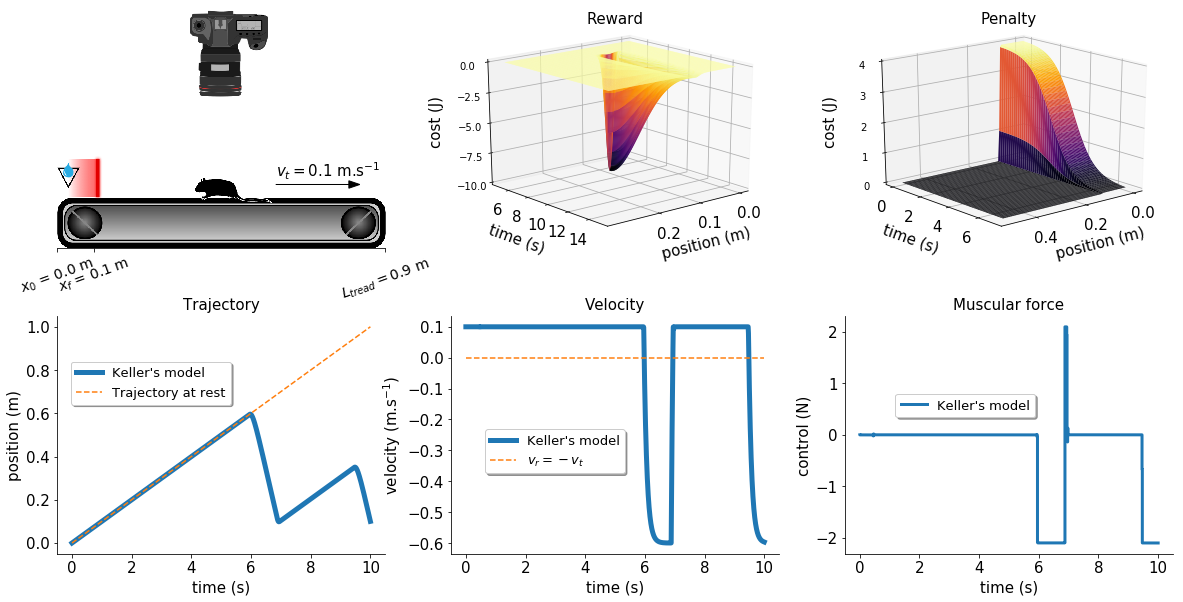

In [13]:
#GENERATE FIGURE
fig3 = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=2)
gs = fig3.add_gridspec(6, 6)

# SCHEME OF THE TASK
f3_ax1 = fig3.add_subplot(gs[:3, :2])
img1 = mpimg.imread('experimental_setup.png')
f3_ax1.imshow(img1,aspect='auto')
f3_ax1.spines['top'].set_visible(False)
f3_ax1.spines['right'].set_visible(False) 
f3_ax1.spines['left'].set_visible(False) 
f3_ax1.set_yticks([])
f3_ax1.set_xticks([x0*1000,xf*1000,900])
plt.xticks(rotation=20)
f3_ax1.set_xticklabels([r'$x_0$ = '+str(x0)+' m',r'$x_f$ = '+str(xf)+' m',r'$L_{tread} = 0.9$ m'],size=14)
plt.arrow(600,470,200,0,head_width=20.0,color='black')
plt.text(600,450,r'$v_t = $'+str(vtapis)+' m.s$^{-1}$',size=15)

#REWARD FUNCTION
f3_ax2 = fig3.add_subplot(gs[:3, 2:4],projection="3d")
f3_ax2.set_title('Reward',size=15)
t = np.linspace(5,15,100)
x = np.linspace(0.0,0.30,100)
X,T = np.meshgrid(x,t)
Z = reward_function(X,T,mux=0.1,mut=6.95,steepnesst=1000)
f3_ax2.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.3, step=0.1))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax2.zaxis.set_rotate_label(False) 
f3_ax2.set_zlabel('cost (J)',size=15,labelpad=10,rotation=90)
f3_ax2.set_zticks(np.linspace(0,-10.0,5))
f3_ax2.view_init(20, 50)
plt.xticks(size = 15)
plt.yticks(size = 15)


#PENALTY FUNCTION
f3_ax3 = fig3.add_subplot(gs[:3, 4:],projection='3d')
f3_ax3.set_title('Penalty',size=15)
x = np.linspace(0.0,0.5,100)
t = np.linspace(0.0,7.0)
X,T = np.meshgrid(x,t)
Z = penalty_function(X,T,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)
f3_ax3.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.yticks(np.arange(0, 7, step=2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax3.zaxis.set_rotate_label(False) 
f3_ax3.set_zlabel('cost (J)',size=15,labelpad=10,rotation=90)
f3_ax3.set_zticks(np.linspace(0,4,5))
f3_ax3.view_init(20, 50)
plt.xticks(size = 15)
plt.yticks(size = 15)


#TRAJECTORY
f3_ax4 = fig3.add_subplot(gs[3:,:2])
f3_ax4.set_title('Trajectory',size=15)
plt.plot(tk,xk,label="Keller's model",linewidth=5.0,alpha=1.0)
plt.plot(tk,[0.1*t for t in tk],'--',label='Trajectory at rest')
f3_ax4.spines['top'].set_visible(False)
f3_ax4.spines['right'].set_visible(False) 
f3_ax4.legend(fontsize=13,bbox_to_anchor=(.55, .6),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('position (m)',size=15)
plt.xlabel('time (s)',size=15)


#VELOCITY
f3_ax5 = fig3.add_subplot(gs[3:, 2:4])
f3_ax5.set_title('Velocity',size=15)
plt.plot(tk,xdotk,label="Keller's model",linewidth=5.0)
plt.plot(tk,[0.0 for t in tk],'--',label=r'$v_r=-v_t$')
plt.ylabel(r'velocity (m.s$^{-1}$)',size=15)
plt.xlabel('time (s)',size = 15)
f3_ax5.spines['top'].set_visible(False)
f3_ax5.spines['right'].set_visible(False) 
f3_ax5.legend(fontsize=13,bbox_to_anchor=(.55, .55),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


#Muscular force
f3_ax6 = fig3.add_subplot(gs[3:, 4:])
f3_ax6.set_title('Muscular force',size=15)
plt.step(tak,[0.3*f for f in acck],label="Keller's model",linewidth=3.0)
plt.ylabel(r'control (N)',size=15)
plt.xlabel('time (s)',size=15)
f3_ax6.spines['top'].set_visible(False)
f3_ax6.spines['right'].set_visible(False) 
f3_ax6.legend(fontsize=13,bbox_to_anchor=(.6, .7),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


plt.savefig('Results_tau'+str(tau)+'sigma_'+str(sigma)+'.pdf')
plt.show()

# Testing $\tau$'s influence

In [ ]:
def acceleration(v,tf):
    acc = []
    dt = tf/len(v)
    for i in range(1,len(v)):
        acc.append((v[i]-v[i-1])/dt)
    return(acc)

# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 7.     # final time (duration of experiment)
sigma = 1.708

tau_acc = []
tau = [0.01,0.1,0.5,1.0,10.0]

for toto in tau:
    xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=toto,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty)
    acceleration_profile=acceleration(np.asarray(xdotk),tf)
    max_acc = np.min(acceleration_profile)
    tau_acc.append(max_acc)
    plt.plot(tk,xk,label=r'$\tau$ = '+str(toto)+' s')

plt.legend()
plt.ylabel('x (m)')
plt.xlabel('t (s)')
plt.title('Trajectory')
plt.savefig('tau_keller.pdf')

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    54703
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3707

Total number of variables............................:    13010
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     9006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  77 -2.8129704e+003 2.30e-002 4.88e-001  -5.7 2.20e+002  -5.9 3.15e-002 3.97e-001f  1
  78 -3.2018188e+003 1.23e-001 1.26e+000  -5.7 6.59e+002  -6.4 2.46e-002 5.90e-001f  1
  79 -4.6728844e+003 3.15e-002 3.21e-001  -5.7 1.98e+003  -6.9 1.00e+000 7.44e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.0602035e+004 4.95e-007 2.50e-004  -5.7 5.93e+003  -7.4 1.00e+000 1.00e+000f  1
  81 -2.8389429e+004 1.25e-010 2.50e-004  -5.7 1.78e+004  -7.9 1.00e+000 1.00e+000f  1
  82 -8.1751610e+004 2.61e-010 2.50e-004  -5.7 5.34e+004  -8.3 1.00e+000 1.00e+000f  1
  83 -2.4183815e+005 6.10e-010 2.50e-004  -5.7 1.60e+005  -8.8 1.00e+000 1.00e+000f  1
  84 -7.2209779e+005 2.42e-009 2.50e-004  -5.7 4.80e+005  -9.3 1.00e+000 1.00e+000f  1
  85 -2.1628767e+006 8.47e-009 2.50e-004  -5.7 1.44e+006  -9.8 1.00e+000 1.00e+000f  1
  86 -6.4852131e+006 1.96e-008 2.50e-004  -5.7 4.32e+006 -10.2 1.00e+000 1.00e+000f  1
  87 -1.9452223e+007 6.60e-008 2.50e-004  -5.7 1.

 176 -2.5649018e+010 6.79e-005 2.50e-004  -5.7 1.70e+007 -10.8 1.00e+000 1.00e+000f  1
 177 -2.5699923e+010 8.69e-005 2.50e-004  -5.7 5.09e+007 -11.3 1.00e+000 1.00e+000f  1
 178 -2.5852638e+010 6.94e-005 2.50e-004  -5.7 1.53e+008 -11.8 1.00e+000 1.00e+000f  1
 179 -2.6801400e+010 8.56e-005 1.17e-001  -5.7 9.49e+008 -12.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -2.7489051e+010 7.95e-005 3.21e-001  -5.7 6.88e+008 -13.2 9.66e-001 1.00e+000f  1
 181 -2.7509225e+010 8.57e-005 2.87e-001  -5.7 1.93e+008 -11.9 1.00e+000 1.04e-001f  1
 182 -2.7986124e+010 1.15e-004 5.12e-002  -5.7 5.80e+008 -12.4 1.00e+000 8.22e-001f  1
 183 -2.9725645e+010 8.96e-005 2.50e-004  -5.7 1.74e+009 -12.8 1.00e+000 1.00e+000f  1
 184 -3.2013002e+010 2.01e-004 3.66e+000  -5.7 1.13e+011 -12.9 1.13e-003 2.02e-002f  1
 185 -3.2022247e+010 1.88e-004 3.57e+000  -5.7 3.76e+008 -13.4 6.16e-001 2.46e-002f  1
 186 -3.3379520e+010 1.82e-004 2.17e+000  -5.7 3.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -6.3381151e+010 1.35e-004 2.47e-001  -5.7 9.39e+008 -13.1 1.00e+000 8.75e-001f  1
 271 -6.3600619e+010 1.62e-004 1.80e-001  -5.7 8.03e+008 -12.6 1.00e+000 2.73e-001f  1
 272 -6.4260366e+010 1.76e-004 2.95e-001  -5.7 6.60e+008 -13.1 9.83e-001 1.00e+000f  1
 273 -6.4414991e+010 1.76e-004 2.42e-001  -5.7 1.49e+009 -13.6 1.63e-001 1.04e-001f  1
 274 -6.4490662e+010 1.76e-004 2.10e-001  -5.7 8.31e+008 -14.1 1.54e-001 9.11e-002f  1
 275 -6.4507938e+010 1.76e-004 1.89e-001  -5.7 1.72e+008 -11.8 1.00e+000 1.01e-001f  1
 276 -6.4751893e+010 1.90e-004 1.01e-001  -5.7 5.06e+008 -12.3 4.78e-001 4.82e-001f  1
 277 -6.5802123e+010 1.90e-004 3.75e-001  -5.7 1.05e+009 -12.8 1.00e+000 1.00e+000f  1
 278 -6.5987855e+010 2.18e-004 2.79e-001  -5.7 1.78e+009 -13.3 7.30e-002 1.04e-001f  1
 279 -6.6132120e+010 1.90e-004 3.18e-001  -5.7 2.37e+009 -13.7 7.27e-002 6.10e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 359 -9.9985407e+010 6.42e-004 2.52e+000  -5.7 4.10e+009 -13.5 1.04e-001 1.11e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360 -1.0018558e+011 5.78e-004 2.30e+000  -5.7 2.34e+009 -13.9 9.15e-002 8.55e-002f  1
 361 -1.0029178e+011 5.31e-004 2.06e+000  -5.7 1.03e+009 -12.6 2.19e-001 1.03e-001f  1
 362 -1.0033202e+011 3.84e-004 1.85e+000  -5.7 3.85e+008 -12.2 3.86e-001 1.04e-001f  1
 363 -1.0051739e+011 3.10e-004 1.04e+000  -5.7 4.26e+008 -12.2 6.48e-001 4.35e-001f  1
 364 -1.0181777e+011 2.51e-004 4.00e-004  -5.7 1.30e+009 -12.7 1.00e+000 1.00e+000f  1
 365 -1.1349428e+011 2.79e-004 2.53e-002  -5.7 1.17e+010 -13.7 1.00e+000 1.00e+000f  1
 366 -1.1370001e+011 3.73e-004 2.50e-004  -5.7 2.06e+008 -11.9 1.00e+000 1.00e+000f  1
 367 -1.1431718e+011 3.73e-004 2.50e-004  -5.7 6.17e+008 -12.4 1.00e+000 1.00e+000f  1
 368 -1.1454856e+011 3.59e-004 3.20e-004  -5.7 2.31e+008 -12.0 1.00e+000 1.00e+000f  1
 369 -1.1524288e+011 3.73e-004 2.50e-004  -5.7 6.

 446 -1.3634718e+011 3.81e-004 2.19e-001  -5.7 3.03e+000  -3.3 1.00e+000 3.61e-004h  1
 447 -1.3634718e+011 3.73e-004 2.24e-003  -5.7 1.38e+000  -3.7 1.00e+000 1.00e+000f  1
 448 -1.3634718e+011 3.59e-004 2.50e-004  -5.7 4.12e+000  -4.2 1.00e+000 1.00e+000f  1
 449 -1.3634718e+011 3.73e-004 2.50e-004  -5.7 1.24e+001  -4.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -1.3634718e+011 3.74e-004 2.50e-004  -5.7 3.71e+001  -5.2 1.00e+000 1.00e+000f  1
 451 -1.3634718e+011 3.73e-004 2.50e-004  -5.7 1.11e+002  -5.6 1.00e+000 1.00e+000f  1
 452 -1.3634719e+011 4.81e-004 2.50e-004  -5.7 3.34e+002  -6.1 1.00e+000 1.00e+000f  1
 453 -1.3634719e+011 3.73e-004 2.50e-004  -5.7 1.00e+003  -6.6 1.00e+000 1.00e+000f  1
 454 -1.3634719e+011 3.74e-004 2.50e-004  -5.7 3.01e+003  -7.1 1.00e+000 1.00e+000f  1
 455 -1.3634720e+011 3.73e-004 2.50e-004  -5.7 9.02e+003  -7.6 1.00e+000 1.00e+000f  1
 456 -1.3634723e+011 3.73e-004 2.50e-004  -5.7 2.

 535 -1.6205583e+011 4.95e-004 2.50e-004  -5.7 5.92e+004  -8.4 1.00e+000 1.00e+000f  1
 536 -1.6205600e+011 6.17e-004 2.50e-004  -5.7 1.78e+005  -8.9 1.00e+000 1.00e+000f  1
 537 -1.6205654e+011 4.95e-004 2.50e-004  -5.7 5.33e+005  -9.3 1.00e+000 1.00e+000f  1
 538 -1.6205814e+011 4.95e-004 2.50e-004  -5.7 1.60e+006  -9.8 1.00e+000 1.00e+000f  1
 539 -1.6206293e+011 5.20e-004 2.50e-004  -5.7 4.80e+006 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540 -1.6207732e+011 4.95e-004 2.50e-004  -5.7 1.44e+007 -10.8 1.00e+000 1.00e+000f  1
 541 -1.6212047e+011 6.17e-004 2.50e-004  -5.7 4.32e+007 -11.2 1.00e+000 1.00e+000f  1
 542 -1.6250887e+011 5.20e-004 2.55e-004  -5.7 3.88e+008 -12.2 1.00e+000 1.00e+000f  1
 543 -1.6286618e+011 5.41e-004 6.40e-001  -5.7 6.32e+010 -12.2 2.59e-003 5.65e-003f  1
 544 -1.6286794e+011 5.53e-004 5.85e-001  -5.7 2.05e+007 -10.9 1.00e+000 8.55e-002f  1
 545 -1.6292142e+011 4.95e-004 7.56e-002  -5.7 6.

 632 -1.8949031e+011 4.95e-004 2.50e-004  -5.7 4.73e+007 -11.3 1.00e+000 1.00e+000f  1
 633 -1.8963229e+011 4.95e-004 2.71e-004  -5.7 1.42e+008 -11.8 1.00e+000 1.00e+000f  1
 634 -1.9005831e+011 5.23e-004 2.50e-004  -5.7 4.26e+008 -12.2 1.00e+000 1.00e+000f  1
 635 -1.9053757e+011 4.81e-004 2.51e-004  -5.7 4.79e+008 -12.3 1.00e+000 1.00e+000f  1
 636 -1.9485096e+011 4.95e-004 2.50e-004  -5.7 4.31e+009 -13.2 1.00e+000 1.00e+000f  1
 637 -1.9597507e+011 4.95e-004 4.07e-001  -5.7 2.26e+009 -14.2 3.14e-001 4.97e-001f  1
 638 -1.9599455e+011 6.17e-004 3.80e-001  -5.7 3.19e+008 -14.7 9.86e-001 6.10e-002f  1
 639 -1.9599455e+011 4.95e-004 3.80e-001  -5.7 2.40e+002  -4.8 3.65e-002 5.10e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640 -1.9599455e+011 6.17e-004 3.76e-001  -5.7 5.01e+001  -5.3 9.97e-001 1.06e-002f  1
 641 -1.9599455e+011 6.03e-004 1.04e+000  -5.7 1.50e+002  -5.8 1.22e-001 1.00e+000f  1
 642 -1.9599455e+011 4.95e-004 2.50e-004  -5.7 4.

 724 -2.1766208e+011 1.11e-001 9.62e+001  -5.7 7.21e+001  -4.2 8.16e-007 3.49e-001f  1
 725 -2.1766208e+011 1.08e-001 9.30e+001  -5.7 3.09e+001  -3.8 4.12e-002 3.31e-002f  1
 726 -2.1766208e+011 1.06e-001 9.09e+001  -5.7 1.78e+002  -4.3 6.04e-003 2.28e-002f  1
 727 -2.1766208e+011 1.05e-001 9.04e+001  -5.7 2.41e+001  -3.9 2.70e-003 5.40e-003f  1
 728 -2.1766208e+011 1.05e-001 9.01e+001  -5.7 9.15e+001  -4.3 1.52e-004 3.50e-003f  1
 729 -2.1766208e+011 9.87e-002 8.47e+001  -5.7 2.09e+001  -3.9 3.39e-003 5.96e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730 -2.1766208e+011 9.85e-002 8.46e+001  -5.7 1.14e+002  -4.4 4.82e-001 1.17e-003f  1
 731 -2.1766208e+011 9.90e-002 8.46e+001  -5.7 9.22e+003  -4.9 8.32e-006 2.57e-004f  1
 732 -2.1766208e+011 5.80e-002 4.87e+001  -5.7 3.15e+001  -4.4 3.12e-005 4.53e-001f  1
 733 -2.1766208e+011 5.67e-002 1.05e+002  -5.7 2.36e+001  -4.0 7.18e-006 2.14e-002f  1
 734 -2.1766208e+011 5.63e-002 1.04e+002  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820 -2.4099272e+011 5.07e-002 1.05e-001  -5.7 2.67e+002  -6.0 9.66e-002 6.48e-003f  1
 821 -2.4099273e+011 2.28e-002 4.31e+000  -5.7 8.01e+002  -6.5 7.60e-003 5.47e-001f  1
 822 -2.4099273e+011 1.16e-002 1.71e+002  -5.7 2.40e+003  -7.0 2.16e-004 5.09e-001f  1
 823 -2.4099273e+011 7.39e-004 2.50e+004  -5.7 7.21e+003  -7.5 2.41e-006 1.00e+000f  1
 824 -2.4099274e+011 7.39e-004 1.44e+004  -5.7 2.16e+004  -7.9 4.85e-001 4.26e-001f  1
 825 -2.4099281e+011 7.39e-004 1.27e+004  -5.7 6.49e+004  -8.4 9.01e-006 1.00e+000f  1
 826 -2.4099299e+011 7.26e-004 9.72e-002  -5.7 1.83e+005  -8.9 1.00e+000 1.00e+000f  1
 827 -2.4099357e+011 7.39e-004 2.53e-004  -5.7 5.84e+005  -9.4 1.00e+000 1.00e+000f  1
 828 -2.4099533e+011 7.39e-004 2.50e-004  -5.7 1.75e+006  -9.8 1.00e+000 1.00e+000f  1
 829 -2.4100058e+011 7.66e-004 2.50e-004  -5.7 5.25e+006 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 908 -2.6383690e+011 9.83e-004 2.50e-004  -5.7 2.73e+007 -11.0 1.00e+000 1.00e+000f  1
 909 -2.6391868e+011 7.39e-004 2.50e-004  -5.7 8.18e+007 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910 -2.6416400e+011 7.39e-004 2.52e-004  -5.7 2.45e+008 -12.0 1.00e+000 1.00e+000f  1
 911 -2.6489980e+011 7.67e-004 5.61e-004  -5.7 7.36e+008 -12.5 1.00e+000 1.00e+000f  1
 912 -2.6588072e+011 7.56e-004 2.35e-001  -5.7 1.08e+009 -13.4 1.00e+000 9.12e-001f  1
 913 -2.6685177e+011 7.26e-004 1.43e-001  -5.7 2.48e+009 -13.0 1.00e+000 3.91e-001f  1
 914 -2.6684223e+011 7.39e-004 4.39e-001  -5.7 3.02e+007 -12.1 2.32e-001 3.16e-001h  1
 915 -2.6685554e+011 7.39e-004 4.21e-001  -5.7 3.29e+008 -11.7 2.01e-001 4.05e-002f  1
 916 -2.6696691e+011 7.39e-004 2.96e-001  -5.7 3.75e+008 -12.2 6.60e-001 2.97e-001f  1
 917 -2.6799420e+011 7.39e-004 3.81e-002  -5.7 1.18e+009 -12.7 1.00e+000 8.72e-001f  1
 918 -2.6881450e+011 7.39e-004 2.34e-001  -5.7 1.

 999 -2.9138383e+011 9.70e-004 2.78e-001  -5.7 1.19e+009 -12.7 1.00e+000 9.33e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 -2.9336152e+011 9.44e-004 8.95e-001  -5.7 1.98e+009 -13.2 3.55e-001 1.00e+000f  1
1001 -2.9338447e+011 9.83e-004 8.36e-001  -5.7 3.48e+008 -13.6 4.55e-001 6.59e-002f  1
1002 -2.9351634e+011 9.70e-004 6.31e-001  -5.7 5.36e+008 -14.1 2.73e-001 2.46e-001f  1
1003 -2.9409754e+011 9.83e-004 3.36e-001  -5.7 1.25e+009 -12.8 1.00e+000 4.66e-001f  1
1004 -2.9416841e+011 9.83e-004 2.52e-004  -5.7 7.09e+007 -11.5 1.00e+000 1.00e+000f  1
1005 -2.9438102e+011 9.70e-004 2.50e-004  -5.7 2.13e+008 -11.9 1.00e+000 1.00e+000f  1
1006 -2.9501886e+011 9.83e-004 2.50e-004  -5.7 6.38e+008 -12.4 1.00e+000 1.00e+000f  1
1007 -2.9573473e+011 1.23e-003 4.68e-003  -5.7 7.16e+008 -12.5 1.00e+000 1.00e+000f  1
1008 -2.9788732e+011 1.23e-003 3.47e-004  -5.7 2.15e+009 -12.9 1.00e+000 1.00e+000f  1
1009 -2.9819003e+011 9.83e-004 2.71e-004  -5.7 3.

1091 -3.4250837e+011 1.21e-003 2.50e-004  -5.7 4.50e+008 -12.3 1.00e+000 1.00e+000f  1
1092 -3.4301414e+011 1.23e-003 6.28e-004  -5.7 5.06e+008 -12.3 1.00e+000 1.00e+000f  1
1093 -3.4320392e+011 1.23e-003 2.50e-004  -5.7 1.90e+008 -11.9 1.00e+000 1.00e+000f  1
1094 -3.4377289e+011 1.21e-003 6.89e-004  -5.7 5.69e+008 -12.4 1.00e+000 1.00e+000f  1
1095 -3.4398640e+011 1.04e-003 2.50e-004  -5.7 2.14e+008 -11.9 1.00e+000 1.00e+000f  1
1096 -3.4462685e+011 1.21e-003 3.77e-004  -5.7 6.40e+008 -12.4 1.00e+000 1.00e+000f  1
1097 -3.4486704e+011 1.01e-003 2.50e-004  -5.7 2.40e+008 -12.0 1.00e+000 1.00e+000f  1
1098 -3.4539867e+011 9.83e-004 8.99e-001  -5.7 5.32e+008 -12.0 2.94e-001 1.00e+000f  1
1099 -3.4544896e+011 1.23e-003 8.69e-001  -5.7 1.22e+009 -11.6 2.37e-003 4.11e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100 -3.4544896e+011 1.23e-003 8.31e-001  -5.7 2.37e+001  -3.8 2.42e-001 4.42e-002f  1
1101 -3.4544896e+011 1.01e-003 8.23e-001  -5.7 1.

1182 -3.8276241e+011 9.70e-004 1.86e-001  -5.7 1.60e+009 -13.4 1.00e+000 3.97e-001f  1
1183 -3.8317378e+011 9.83e-004 2.23e-001  -5.7 4.11e+008 -13.0 8.40e-001 1.00e+000f  1
1184 -3.8434144e+011 1.01e-003 1.25e+000  -5.7 1.17e+009 -13.5 1.32e-001 1.00e+000f  1
1185 -3.8456456e+011 1.01e-003 8.92e-001  -5.7 7.91e+008 -13.1 6.16e-002 2.82e-001f  1
1186 -3.8460078e+011 1.01e-003 8.61e-001  -5.7 1.03e+009 -12.6 3.82e-001 3.53e-002f  1
1187 -3.8487985e+011 1.02e-003 7.85e-001  -5.7 3.19e+009 -13.1 8.94e-002 8.74e-002f  1
1188 -3.8528295e+011 9.70e-004 5.21e-001  -5.7 1.20e+009 -12.7 1.00e+000 3.36e-001f  1
1189 -3.8539678e+011 9.83e-004 6.18e-001  -5.7 1.25e+009 -13.2 2.91e-001 9.14e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190 -3.8592759e+011 9.83e-004 1.15e+000  -5.7 1.33e+009 -13.6 2.64e-001 3.98e-001f  1
1191 -3.8604583e+011 9.83e-004 1.10e+000  -5.7 2.13e+009 -13.2 5.98e-002 5.55e-002f  1
1192 -3.8659405e+011 1.01e-003 8.39e-001  -5.7 2.

1273 -4.1272514e+011 1.23e-003 8.99e-001  -5.7 1.25e+009 -13.0 1.00e+000 1.43e-001f  1
1274 -4.1441064e+011 1.13e-003 6.34e-001  -5.7 2.34e+009 -13.5 2.21e-001 7.21e-001f  1
1275 -4.1479124e+011 9.83e-004 1.10e+000  -5.7 1.01e+009 -13.9 4.48e-001 3.75e-001f  1
1276 -4.1480415e+011 1.20e-003 9.89e-001  -5.7 1.26e+008 -11.7 6.78e-001 1.02e-001f  1
1277 -4.1511617e+011 9.83e-004 1.72e-001  -5.7 3.78e+008 -12.2 1.00e+000 8.26e-001f  1
1278 -4.1622241e+011 1.47e-003 2.69e-002  -5.7 1.11e+009 -12.7 9.28e-001 1.00e+000f  1
1279 -4.1654880e+011 1.23e-003 4.25e-001  -5.7 6.79e+008 -12.7 1.00e+000 4.81e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280 -4.1702759e+011 1.21e-003 5.34e-004  -5.7 4.79e+008 -12.3 1.00e+000 1.00e+000f  1
1281 -4.1709492e+011 1.23e-003 2.50e-004  -5.7 6.73e+007 -11.4 1.00e+000 1.00e+000f  1
1282 -4.1729692e+011 1.21e-003 2.50e-004  -5.7 2.02e+008 -11.9 1.00e+000 1.00e+000f  1
1283 -4.1784210e+011 1.21e-003 2.05e-001  -5.7 9.

1368 -4.3415850e+011 6.11e-003 4.40e+002  -5.7 1.39e+002  -4.8 3.24e-008 2.63e-003f  1
1369 -4.3415850e+011 6.15e-003 4.36e+002  -5.7 5.21e+001  -5.3 8.84e-008 8.73e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370 -4.3415850e+011 5.99e-003 4.36e+002  -5.7 1.48e+002  -4.9 5.15e-008 9.13e-004f  1
1371 -4.3415850e+011 6.71e-003 4.26e+002  -5.7 5.86e+001  -5.4 3.24e-008 2.35e-002f  1
1372 -4.3415850e+011 6.17e-003 3.15e+002  -5.7 2.06e+002  -4.9 2.98e-008 1.75e-003f  1
1373 -4.3415850e+011 6.44e-003 3.12e+002  -5.7 6.60e+001  -5.4 8.71e-008 7.24e-003f  1
1374 -4.3415850e+011 6.49e-003 3.12e+002  -5.7 2.09e+002  -5.0 7.38e-008 5.34e-004f  1
1375 -4.3415850e+011 6.42e-003 3.05e+002  -5.7 7.42e+001  -5.5 2.69e-008 2.35e-002f  1
1376 -4.3415850e+011 6.71e-003 3.70e+002  -5.7 3.52e+002  -5.0 2.91e-008 1.01e-003f  1
1377 -4.3415850e+011 6.46e-003 3.68e+002  -5.7 8.35e+001  -5.5 8.68e-008 6.70e-003f  1
1378 -4.3415850e+011 6.77e-003 3.68e+002  -5.7 3.

1464 -4.8716150e+011 1.23e-003 3.44e-001  -5.7 7.00e+007 -11.4 7.22e-001 6.35e-001f  1
1465 -4.8737222e+011 1.23e-003 7.36e-002  -5.7 2.11e+008 -11.9 7.45e-001 1.00e+000f  1
1466 -4.8800435e+011 1.72e-003 2.50e-004  -5.7 6.32e+008 -12.4 1.00e+000 1.00e+000f  1
1467 -4.8990072e+011 1.72e-003 2.78e-004  -5.7 1.90e+009 -12.9 1.00e+000 1.00e+000f  1
1468 -4.9558994e+011 1.23e-003 2.50e-004  -5.7 5.69e+009 -13.4 1.00e+000 1.00e+000f  1
1469 -4.9717383e+011 1.72e-003 5.60e-001  -5.7 1.14e+010 -14.3 5.90e-002 1.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1470 -4.9740877e+011 1.23e-003 5.01e-001  -5.7 1.57e+009 -14.8 1.93e-001 1.49e-001f  1
1471 -4.9743065e+011 1.23e-003 4.97e-001  -5.7 2.81e+009 -15.3 4.32e-002 7.79e-003f  1
1472 -4.9750582e+011 1.70e-003 4.56e-001  -5.7 8.14e+008 -15.7 1.00e+000 9.23e-002f  1
1473 -4.9874530e+011 1.27e-001 7.79e-001  -5.7 4.26e+009 -14.0 1.25e-002 2.91e-001f  1
1474 -4.9874530e+011 1.26e-001 7.73e-001  -5.7 5.

1558 -5.2004353e+011 1.09e-002 2.54e+001  -5.7 2.91e+002  -5.3 2.15e-008 3.65e-004f  1
1559 -5.2004353e+011 1.07e-002 2.50e+001  -5.7 1.48e+002  -5.8 5.27e-006 1.47e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1560 -5.2004353e+011 1.04e-002 2.50e+001  -5.7 6.14e+002  -5.3 9.72e-004 4.30e-004f  1
1561 -5.2004353e+011 1.06e-002 2.37e+001  -5.7 1.66e+002  -5.8 5.59e-007 5.11e-002f  1
1562 -5.2004353e+011 1.05e-002 7.96e+002  -5.7 1.32e+002  -4.5 3.11e-008 1.76e-002f  1
1563 -5.2004353e+011 1.03e-002 7.91e+002  -5.7 1.71e+002  -5.0 1.02e-002 6.36e-003f  1
1564 -5.2004353e+011 1.02e-002 7.57e+002  -5.7 7.03e+001  -5.4 3.06e-006 4.25e-002f  1
1565 -5.2004353e+011 1.09e-002 7.56e+002  -5.7 2.11e+002  -5.9 1.38e-002 1.77e-003f  1
1566 -5.2004353e+011 9.10e-003 7.00e+002  -5.7 6.32e+002  -6.4 1.46e-006 7.36e-002f  1
1567 -5.2004353e+011 9.58e-003 6.86e+002  -5.7 1.90e+003  -6.9 4.61e-007 2.09e-002f  1
1568 -5.2004353e+011 7.31e-003 5.51e+003  -5.7 5.

1649 -5.6169296e+011 2.19e-003 2.64e-004  -5.7 1.09e+009 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650 -5.6184589e+011 1.95e-003 2.50e-004  -5.7 1.53e+008 -11.8 1.00e+000 1.00e+000f  1
1651 -5.6230469e+011 2.19e-003 2.66e-004  -5.7 4.59e+008 -12.3 1.00e+000 1.00e+000f  1
1652 -5.6368098e+011 1.92e-003 3.55e-004  -5.7 1.38e+009 -12.7 1.00e+000 1.00e+000f  1
1653 -5.6504752e+011 1.93e-003 4.54e-001  -5.7 1.55e+009 -13.7 8.96e-001 8.81e-001f  1
1654 -5.6512570e+011 1.72e-003 3.93e-001  -5.7 5.81e+008 -12.4 1.00e+000 1.35e-001f  1
1655 -5.6577068e+011 1.72e-003 1.63e-001  -5.7 6.45e+008 -12.8 1.00e+000 1.00e+000f  1
1656 -5.6624235e+011 2.19e-003 1.42e-001  -5.7 4.72e+008 -12.4 1.00e+000 1.00e+000f  1
1657 -5.6636591e+011 2.19e-003 4.08e-001  -5.7 1.24e+008 -12.0 1.00e+000 1.00e+000f  1
1658 -5.6668433e+011 1.98e-003 2.11e-001  -5.7 3.18e+008 -12.5 1.00e+000 1.00e+000f  1
1659 -5.6814222e+011 1.72e-003 9.18e-002  -5.7 1.

1742 -5.8686233e+011 2.86e-002 4.89e+003  -5.7 1.19e+008 -11.7 1.25e-007 7.84e-003f  1
1743 -5.8688993e+011 2.52e-002 6.29e+003  -5.7 2.65e+008 -12.2 1.42e-007 1.04e-001f  1
1744 -5.8689044e+011 2.52e-002 6.26e+003  -5.7 1.30e+008 -11.7 6.78e-004 3.96e-003f  1
1745 -5.8689209e+011 2.47e-002 5.83e+003  -5.7 4.96e+007 -11.3 4.53e-007 3.32e-002f  1
1746 -5.8689633e+011 2.27e-002 5.58e+003  -5.7 1.00e+008 -11.8 3.15e-007 4.23e-002f  1
1747 -5.8692244e+011 2.08e-002 6.72e+003  -5.7 4.43e+008 -12.3 1.23e-007 5.89e-002f  1
1748 -5.8692244e+011 2.12e-002 6.72e+003  -5.7 1.63e+008 -11.8 5.23e-007 1.70e-005f  1
1749 -5.8692812e+011 2.12e-002 6.64e+003  -5.7 4.74e+008 -12.3 3.19e-005 1.20e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750 -5.8767041e+011 1.10e-002 3.55e+003  -5.7 1.50e+009 -12.8 2.20e-007 4.96e-001f  1
1751 -5.8767041e+011 9.53e-003 3.12e+003  -5.7 3.53e+000  -2.9 7.38e-002 1.23e-001f  1
1752 -5.8767041e+011 7.20e-003 2.08e+003  -5.7 1.

1832 -6.0122388e+011 2.20e-003 2.79e-004  -5.7 2.09e+008 -11.9 1.00e+000 1.00e+000f  1
1833 -6.0310367e+011 2.19e-003 2.51e-004  -5.7 1.88e+009 -12.9 1.00e+000 1.00e+000f  1
1834 -6.0331231e+011 2.19e-003 3.78e-001  -5.7 9.34e+011 -12.0 1.46e-004 2.23e-004f  1
1835 -6.0337855e+011 2.19e-003 3.00e-001  -5.7 3.14e+008 -12.5 8.99e-001 2.11e-001f  1
1836 -6.0409617e+011 2.19e-003 3.52e-001  -5.7 9.91e+008 -13.0 2.93e-001 7.24e-001f  1
1837 -6.0427869e+011 2.20e-003 3.31e-001  -5.7 1.82e+009 -13.5 3.31e-001 1.00e-001f  1
1838 -6.0432662e+011 2.19e-003 3.11e-001  -5.7 8.59e+008 -13.9 7.36e-002 5.58e-002f  1
1839 -6.0434782e+011 2.19e-003 2.98e-001  -5.7 3.24e+008 -14.4 7.80e-001 6.54e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1840 -6.0438036e+011 2.19e-003 2.92e-001  -5.7 2.75e+009 -14.9 9.13e-003 1.18e-002f  1
1841 -6.0438042e+011 1.72e-003 2.92e-001  -5.7 1.84e+009 -15.4 1.60e-003 2.81e-005f  1
1842 -6.0439890e+011 2.19e-003 2.89e-001  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920 -6.0638779e+011 2.19e-003 1.54e+004  -5.7 8.44e+008 -12.5 3.63e-006 1.00e+000f  1
1921 -6.0684732e+011 2.47e-003 1.17e+004  -5.7 1.91e+009 -13.0 1.81e-002 2.40e-001f  1
1922 -6.0683664e+011 2.19e-003 2.28e+003  -5.7 3.01e+007 -11.7 4.00e-006 3.54e-001h  1
1923 -6.0701636e+011 2.19e-003 1.16e+003  -5.7 3.65e+008 -12.2 1.00e+000 4.93e-001f  1
1924 -6.0715517e+011 2.20e-003 1.92e+004  -5.7 1.39e+008 -11.7 1.08e-005 1.00e+000f  1
1925 -6.0754561e+011 2.20e-003 1.92e-002  -5.7 3.90e+008 -12.2 1.00e+000 1.00e+000f  1
1926 -6.0841141e+011 2.20e-003 1.63e-001  -5.7 8.66e+008 -12.7 1.00e+000 1.00e+000f  1
1927 -6.0846846e+011 2.20e-003 4.51e-003  -5.7 5.86e+007 -11.4 1.00e+000 9.74e-001f  1
1928 -6.0853437e+011 2.68e-003 2.52e-004  -5.7 6.59e+007 -11.4 1.00e+000 1.00e+000f  1
1929 -6.0873208e+011 2.19e-003 2.50e-004  -5.7 1.98e+008 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2011 -6.3042435e+011 2.80e-002 2.12e-001  -5.7 2.21e+009 -15.3 7.04e-002 3.01e-001f  1
2012 -6.3042436e+011 2.85e-002 2.12e-001  -5.7 3.25e+006 -14.9 5.24e-002 2.41e-003f  1
2013 -6.3042447e+011 4.22e-002 6.52e+000  -5.7 2.27e+006 -14.5 2.43e-005 4.84e-002f  1
2014 -6.3045262e+011 3.77e-002 3.83e+001  -5.7 3.12e+008 -15.0 2.03e-006 9.01e-002f  1
2015 -6.3045301e+011 4.02e-002 8.12e+002  -5.7 1.63e+007 -15.4 1.79e-007 2.41e-002f  1
2016 -6.3079279e+011 3.28e-002 4.83e+002  -5.7 8.38e+008 -15.9 1.05e-005 4.05e-001f  1
2017 -6.3079306e+011 3.95e-002 4.72e+002  -5.7 1.18e+007 -15.5 7.22e-002 2.25e-002f  1
2018 -6.3080912e+011 3.73e-002 4.62e+002  -5.7 8.07e+008 -16.0 4.72e-006 1.99e-002f  1
2019 -6.3127756e+011 3.65e-002 9.29e+002  -5.7 1.08e+010 -16.4 6.42e-007 4.35e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020 -6.3166775e+011 3.60e-002 9.00e+002  -5.7 1.25e+010 -16.0 5.86e-002 3.12e-002f  1
2021 -6.3176812e+011 3.50e-002 8.83e+002  -5.7 5.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100 -6.6779338e+011 1.99e-003 4.03e-001  -5.7 8.73e+007 -11.5 2.02e-001 3.73e-001f  1
2101 -6.6805431e+011 2.20e-003 2.64e-004  -5.7 2.61e+008 -12.0 1.00e+000 1.00e+000f  1
2102 -6.6898799e+011 2.20e-003 4.70e-001  -5.7 1.12e+009 -13.0 8.21e-001 8.35e-001f  1
2103 -6.6914441e+011 1.72e-003 3.34e-001  -5.7 5.39e+008 -13.5 3.40e-001 2.90e-001f  1
2104 -6.6922696e+011 2.19e-003 3.94e-001  -5.7 3.91e+008 -13.9 5.29e-001 2.11e-001f  1
2105 -6.6948279e+011 2.19e-003 7.11e-001  -5.7 4.28e+008 -14.4 4.21e-001 5.97e-001f  1
2106 -6.6965082e+011 2.20e-003 7.00e-001  -5.7 1.10e+010 -14.0 2.68e-002 1.52e-002f  1
2107 -6.6976840e+011 1.93e-003 5.20e-001  -5.7 4.58e+008 -14.5 2.75e-001 2.57e-001f  1
2108 -6.7002990e+011 3.75e-003 7.29e-001  -5.7 5.35e+008 -14.9 2.02e-001 4.89e-001f  1
2109 -6.7002992e+011 6.27e-003 7.12e-001  -5.7 6.30e+005 -14.5 1.06e-001 2.34e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2186 -7.0073585e+011 1.98e-003 1.88e-001  -5.7 6.62e+008 -12.4 1.00e+000 4.07e-001f  1
2187 -7.0098712e+011 2.20e-003 2.64e-002  -5.7 2.51e+008 -12.0 1.00e+000 1.00e+000f  1
2188 -7.0108020e+011 1.92e-003 2.52e-004  -5.7 9.31e+007 -11.6 1.00e+000 1.00e+000f  1
2189 -7.0135943e+011 2.48e-003 2.50e-004  -5.7 2.79e+008 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2190 -7.0167356e+011 2.19e-003 2.50e-004  -5.7 3.14e+008 -12.1 1.00e+000 1.00e+000f  1
2191 -7.0261597e+011 1.99e-003 2.50e-004  -5.7 9.42e+008 -12.6 1.00e+000 1.00e+000f  1
2192 -7.0544320e+011 1.98e-003 2.50e-004  -5.7 2.83e+009 -13.1 1.00e+000 1.00e+000f  1
2193 -7.0604790e+011 2.20e-003 3.36e-001  -5.7 4.07e+009 -14.0 7.51e-001 1.49e-001f  1
2194 -7.0727743e+011 2.47e-003 6.37e-001  -5.7 1.23e+009 -14.5 3.30e-001 1.00e+000f  1
2195 -7.0727970e+011 2.19e-003 6.28e-001  -5.7 1.68e+008 -11.8 1.00e+000 1.35e-002f  1
2196 -7.0780016e+011 2.20e-003 7.79e-002  -5.7 5.

2277 -7.3363491e+011 2.19e-003 2.50e-004  -5.7 1.90e+008 -11.9 1.00e+000 1.00e+000f  1
2278 -7.3420584e+011 1.94e-003 2.50e-004  -5.7 5.71e+008 -12.4 1.00e+000 1.00e+000f  1
2279 -7.3591491e+011 2.19e-003 3.66e-003  -5.7 1.71e+009 -12.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2280 -7.3655721e+011 2.19e-003 2.50e-004  -5.7 6.42e+008 -12.4 1.00e+000 1.00e+000f  1
2281 -7.3679807e+011 2.19e-003 2.50e-004  -5.7 2.41e+008 -12.0 1.00e+000 1.00e+000f  1
2282 -7.3751974e+011 2.20e-003 9.92e-004  -5.7 7.22e+008 -12.5 1.00e+000 1.00e+000f  1
2283 -7.3779069e+011 1.92e-003 2.80e-004  -5.7 2.71e+008 -12.0 1.00e+000 1.00e+000f  1
2284 -7.3860360e+011 2.19e-003 2.50e-004  -5.7 8.13e+008 -12.5 1.00e+000 1.00e+000f  1
2285 -7.4145912e+011 2.19e-003 7.64e-001  -5.7 3.59e+009 -13.5 6.28e-001 7.95e-001f  1
2286 -7.4254209e+011 2.19e-003 4.45e-001  -5.7 2.61e+009 -13.0 1.00e+000 4.15e-001f  1
2287 -7.4413777e+011 2.00e-003 5.57e-001  -5.7 3.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370 -7.8247815e+011 2.19e-003 4.72e-003  -5.7 1.20e+009 -12.7 1.00e+000 1.00e+000f  1
2371 -7.8510991e+011 2.19e-003 8.03e-001  -5.7 2.63e+009 -13.6 2.49e-001 1.00e+000f  1
2372 -7.8582642e+011 2.19e-003 1.58e+000  -5.7 3.29e+009 -14.1 2.83e-002 2.18e-001f  1
2373 -7.8583851e+011 1.72e-003 1.57e+000  -5.7 1.40e+009 -14.6 2.28e-001 8.63e-003f  1
2374 -7.8643338e+011 2.20e-003 1.37e+000  -5.7 4.57e+009 -13.3 2.83e-001 1.30e-001f  1
2375 -7.8728993e+011 1.97e-003 3.73e-001  -5.7 1.06e+009 -13.7 1.02e-001 8.07e-001f  1
2376 -7.8733595e+011 1.72e-003 3.15e-001  -5.7 2.74e+008 -13.3 4.44e-001 1.68e-001f  1
2377 -7.8756991e+011 1.72e-003 3.95e-001  -5.7 9.61e+010 -12.5 1.66e-003 2.43e-003f  1
2378 -7.8759768e+011 2.11e-003 3.41e-001  -5.7 2.06e+008 -12.0 8.18e-001 1.35e-001f  1
2379 -7.8762186e+011 2.20e-003 2.60e-001  -5.7 1.02e+008 -11.6 1.65e-001 2.38e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2459 -8.2476772e+011 2.47e-003 2.50e-004  -5.7 1.17e+009 -12.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2460 -8.2493256e+011 2.19e-003 2.50e-004  -5.7 1.65e+008 -11.8 1.00e+000 1.00e+000f  1
2461 -8.2520797e+011 2.69e-003 3.35e-001  -5.7 2.75e+008 -11.9 1.00e+000 1.00e+000f  1
2462 -8.2549305e+011 2.41e-003 1.79e-001  -5.7 4.58e+008 -12.3 1.00e+000 6.23e-001f  1
2463 -8.2570168e+011 2.20e-003 3.38e-001  -5.7 2.09e+008 -11.9 2.57e-001 1.00e+000f  1
2464 -8.2573102e+011 2.20e-003 2.55e-004  -5.7 2.93e+007 -11.1 1.00e+000 1.00e+000f  1
2465 -8.2581904e+011 2.20e-003 2.50e-004  -5.7 8.80e+007 -11.5 1.00e+000 1.00e+000f  1
2466 -8.2591806e+011 2.41e-003 2.50e-004  -5.7 9.90e+007 -11.6 1.00e+000 1.00e+000f  1
2467 -8.2621512e+011 2.20e-003 2.50e-004  -5.7 2.97e+008 -12.1 1.00e+000 1.00e+000f  1
2468 -8.2710630e+011 2.69e-003 2.66e-004  -5.7 8.91e+008 -12.6 1.00e+000 1.00e+000f  1
2469 -8.2858809e+011 2.19e-003 7.46e-001  -5.7 2.

2551 -8.6448722e+011 2.70e-003 4.25e-001  -5.7 1.23e+009 -13.0 1.37e-001 2.71e-002f  1
2552 -8.6568763e+011 3.62e-003 3.58e-001  -5.7 7.63e+009 -13.5 1.34e-001 1.57e-001f  1
2553 -8.6576378e+011 2.87e-003 2.82e-001  -5.7 3.57e+008 -12.2 2.38e-001 2.13e-001f  1
2554 -8.6669847e+011 2.20e-003 3.63e-002  -5.7 1.07e+009 -12.6 1.00e+000 8.72e-001f  1
2555 -8.6710072e+011 2.20e-003 1.20e-002  -5.7 4.02e+008 -12.2 9.07e-001 1.00e+000f  1
2556 -8.6830593e+011 2.20e-003 1.06e-003  -5.7 1.21e+009 -12.7 1.00e+000 1.00e+000f  1
2557 -8.6847546e+011 2.20e-003 3.92e-003  -5.7 1.70e+008 -11.8 1.00e+000 1.00e+000f  1
2558 -8.6853910e+011 2.20e-003 2.50e-004  -5.7 6.36e+007 -11.4 1.00e+000 1.00e+000f  1
2559 -8.6873001e+011 2.20e-003 2.50e-004  -5.7 1.91e+008 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2560 -8.6894479e+011 2.69e-003 2.64e-004  -5.7 2.15e+008 -11.9 1.00e+000 1.00e+000f  1
2561 -8.6928474e+011 2.20e-003 4.62e-001  -5.7 3.

2644 -9.2882095e+011 2.69e-003 8.52e-001  -5.7 1.99e+007 -10.9 1.00e+000 2.58e-002f  1
2645 -9.2888077e+011 3.17e-003 3.72e-003  -5.7 5.98e+007 -11.4 1.00e+000 1.00e+000f  1
2646 -9.2894810e+011 3.67e-003 2.50e-004  -5.7 6.73e+007 -11.4 1.00e+000 1.00e+000f  1
2647 -9.2915007e+011 3.67e-003 2.71e-004  -5.7 2.02e+008 -11.9 1.00e+000 1.00e+000f  1
2648 -9.2975604e+011 2.90e-003 2.58e-004  -5.7 6.06e+008 -12.4 1.00e+000 1.00e+000f  1
2649 -9.2998328e+011 3.17e-003 2.50e-004  -5.7 2.27e+008 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2650 -9.3066490e+011 3.17e-003 3.62e-004  -5.7 6.82e+008 -12.4 1.00e+000 1.00e+000f  1
2651 -9.3092050e+011 2.96e-003 3.50e-004  -5.7 2.56e+008 -12.0 1.00e+000 1.00e+000f  1
2652 -9.3322131e+011 2.69e-003 2.51e-004  -5.7 2.30e+009 -13.0 1.00e+000 1.00e+000f  1
2653 -9.3458588e+011 3.67e-003 5.95e-001  -5.7 3.07e+009 -13.9 2.71e-001 4.45e-001f  1
2654 -9.3464978e+011 2.97e-003 5.86e-001  -5.7 4.

2732 -9.7146644e+011 3.17e-003 2.50e-004  -5.7 1.80e+004  -7.9 1.00e+000 1.00e+000f  1
2733 -9.7146649e+011 3.17e-003 2.50e-004  -5.7 5.41e+004  -8.3 1.00e+000 1.00e+000f  1
2734 -9.7146666e+011 3.17e-003 2.50e-004  -5.7 1.62e+005  -8.8 1.00e+000 1.00e+000f  1
2735 -9.7146714e+011 2.69e-003 2.50e-004  -5.7 4.87e+005  -9.3 1.00e+000 1.00e+000f  1
2736 -9.7146860e+011 2.69e-003 2.50e-004  -5.7 1.46e+006  -9.8 1.00e+000 1.00e+000f  1
2737 -9.7147299e+011 3.67e-003 2.50e-004  -5.7 4.38e+006 -10.2 1.00e+000 1.00e+000f  1
2738 -9.7148613e+011 2.69e-003 2.50e-004  -5.7 1.31e+007 -10.7 1.00e+000 1.00e+000f  1
2739 -9.7152556e+011 3.17e-003 2.50e-004  -5.7 3.94e+007 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2740 -9.7164385e+011 3.17e-003 2.50e-004  -5.7 1.18e+008 -11.7 1.00e+000 1.00e+000f  1
2741 -9.7199881e+011 3.67e-003 5.55e-004  -5.7 3.55e+008 -12.2 1.00e+000 1.00e+000f  1
2742 -9.7305996e+011 2.90e-003 4.32e-003  -5.7 1.

2823 -1.0070144e+012 2.69e-003 3.28e-001  -5.7 1.14e+009 -15.8 9.68e-001 1.54e-001f  1
2824 -1.0070144e+012 3.30e-003 3.18e-001  -5.7 6.48e+001  -4.0 5.19e-002 1.49e-004h  1
2825 -1.0070144e+012 3.37e-003 3.08e-001  -5.7 9.60e+001  -4.5 9.19e-003 6.71e-002f  1
2826 -1.0070144e+012 3.09e-003 2.44e-001  -5.7 1.83e+002  -5.0 2.70e-001 1.52e-002f  1
2827 -1.0070144e+012 4.80e-003 2.38e-001  -5.7 6.74e+001  -5.4 6.16e-002 2.51e-002f  1
2828 -1.0070144e+012 3.32e-003 2.17e-001  -5.7 2.02e+002  -5.9 2.45e-001 9.00e-002f  1
2829 -1.0070144e+012 2.51e-003 4.68e+002  -5.7 6.05e+002  -6.4 5.22e-005 4.19e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2830 -1.0070144e+012 3.67e-003 4.23e+002  -5.7 1.81e+003  -6.9 2.86e-002 9.74e-002f  1
2831 -1.0070144e+012 2.19e-003 5.63e+004  -5.7 5.44e+003  -7.3 2.12e-006 7.94e-001f  1
2832 -1.0070144e+012 3.17e-003 1.21e-002  -5.7 1.63e+004  -7.8 9.49e-001 1.00e+000f  1
2833 -1.0070145e+012 2.96e-003 2.50e-004  -5.7 4.

2917 -1.0521234e+012 2.96e-003 8.72e-002  -5.7 5.09e+008 -12.3 9.89e-001 6.41e-001f  1
2918 -1.0521698e+012 2.96e-003 5.95e-002  -5.7 5.33e+007 -11.5 1.00e+000 8.71e-001f  1
2919 -1.0523845e+012 2.69e-003 4.57e-004  -5.7 2.15e+008 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2920 -1.0524650e+012 3.17e-003 2.50e-004  -5.7 8.05e+007 -11.5 1.00e+000 1.00e+000f  1
2921 -1.0527242e+012 3.17e-003 3.11e-001  -5.7 7.44e+009 -12.5 8.09e-002 3.48e-002f  1
2922 -1.0527339e+012 2.90e-003 2.28e-001  -5.7 3.62e+007 -11.1 1.00e+000 2.66e-001f  1
2923 -1.0528357e+012 3.17e-003 2.22e-002  -5.7 1.02e+008 -11.6 8.23e-001 1.00e+000f  1
2924 -1.0529503e+012 3.67e-003 2.51e-004  -5.7 1.15e+008 -11.7 1.00e+000 1.00e+000f  1
2925 -1.0529933e+012 3.17e-003 2.50e-004  -5.7 4.30e+007 -11.2 1.00e+000 1.00e+000f  1
2926 -1.0531223e+012 2.90e-003 2.50e-004  -5.7 1.29e+008 -11.7 1.00e+000 1.00e+000f  1
2927 -1.0543103e+012 3.17e-003 1.29e-001  -5.7 1.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    54703
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3707

Total number of variables............................:    13010
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     9006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  85 -3.3193118e+008 3.29e-005 8.14e-001  -3.8 7.31e+006 -10.5 1.00e+000 1.00e+000f  1
  86 -3.5822250e+008 5.70e-005 4.71e-002  -3.8 2.63e+007 -11.0 1.00e+000 1.00e+000f  1
  87 -4.3708604e+008 7.46e-006 2.54e-004  -3.8 7.89e+007 -11.5 1.00e+000 1.00e+000f  1
  88 -4.3719803e+008 4.48e-004 5.55e-002  -5.7 3.58e+006 -10.6 5.67e-002 3.13e-002f  1
  89 -4.3763059e+008 1.78e-003 5.10e-002  -5.7 4.16e+006 -10.2 4.37e-002 1.04e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -4.3817816e+008 1.55e-003 1.29e-001  -5.7 4.23e+006 -10.3 6.71e-002 1.30e-001f  1
  91 -4.3845322e+008 1.52e-003 1.13e-001  -5.7 1.40e+007 -10.7 2.92e-002 1.96e-002f  1
  92 -4.3895232e+008 1.37e-003 1.48e-001  -5.7 5.26e+006 -10.3 5.78e-002 9.48e-002f  1
  93 -4.3896817e+008 1.34e-003 1.42e-001  -5.7 7.55e+005  -9.9 2.27e-002 2.10e-002f  1
  94 -4.3901086e+008 1.23e-003 1.68e-001  -5.7 4.82e+005 -10.4 5.42e-002 8.86e-002f  1
  95 -4.3903211e+008 1.26e-003 1.67e-001  -5.7 8.

 172 -1.4312240e+010 4.14e-005 3.06e-004  -5.7 3.34e+007 -11.1 1.00e+000 1.00e+000f  1
 173 -1.4412469e+010 5.27e-005 2.50e-004  -5.7 1.00e+008 -11.6 1.00e+000 1.00e+000f  1
 174 -1.4450055e+010 5.41e-005 2.50e-004  -5.7 3.76e+007 -11.2 1.00e+000 1.00e+000f  1
 175 -1.4788322e+010 4.48e-005 2.74e-004  -5.7 3.38e+008 -12.1 1.00e+000 1.00e+000f  1
 176 -1.5802689e+010 4.45e-005 1.09e-003  -5.7 1.01e+009 -12.6 1.00e+000 1.00e+000f  1
 177 -1.6183217e+010 4.53e-005 3.40e-004  -5.7 3.81e+008 -12.2 1.00e+000 1.00e+000f  1
 178 -1.8850873e+010 1.44e-004 6.49e-001  -5.7 2.67e+009 -13.1 9.89e-001 1.00e+000f  1
 179 -1.8850873e+010 1.44e-004 6.49e-001  -5.7 2.94e+000  -3.3 2.53e-001 2.94e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -1.8850873e+010 1.42e-004 6.39e-001  -5.7 1.47e+000  -3.8 1.00e+000 1.53e-002f  1
 181 -1.8850873e+010 6.79e-005 8.96e-004  -5.7 4.41e+000  -4.2 1.00e+000 1.00e+000f  1
 182 -1.8850873e+010 5.75e-005 2.50e-004  -5.7 1.

 259 -3.4034825e+010 1.59e-004 4.77e-001  -5.7 1.02e+009 -13.9 5.11e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -3.4034825e+010 1.59e-004 4.77e-001  -5.7 1.37e+006 -12.6 3.79e-002 1.01e-005f  1
 261 -3.4035257e+010 1.42e-004 4.27e-001  -5.7 4.13e+006 -12.2 4.01e-001 1.05e-001f  1
 262 -3.4035597e+010 1.12e-004 2.27e-001  -5.7 6.87e+005 -12.6 1.00e+000 4.95e-001f  1
 263 -3.4086255e+010 8.47e-005 2.57e-004  -5.7 5.07e+007 -11.3 1.00e+000 1.00e+000f  1
 264 -3.4105252e+010 9.84e-005 2.50e-004  -5.7 1.90e+007 -10.9 1.00e+000 1.00e+000f  1
 265 -3.4162243e+010 1.08e-004 2.50e-004  -5.7 5.70e+007 -11.4 1.00e+000 1.00e+000f  1
 266 -3.4333214e+010 8.47e-005 2.51e-004  -5.7 1.71e+008 -11.8 1.00e+000 1.00e+000f  1
 267 -3.4397328e+010 1.15e-004 2.50e-004  -5.7 6.41e+007 -11.4 1.00e+000 1.00e+000f  1
 268 -3.4934882e+010 1.16e-004 5.45e-002  -5.7 5.38e+008 -12.4 1.00e+000 1.00e+000f  1
 269 -3.5151268e+010 9.84e-005 2.52e-004  -5.7 2.

 347 -7.2517857e+010 2.51e-004 2.50e-004  -5.7 2.15e+007 -10.9 1.00e+000 1.00e+000f  1
 348 -7.2582240e+010 2.51e-004 2.50e-004  -5.7 6.44e+007 -11.4 1.00e+000 1.00e+000f  1
 349 -7.2934096e+010 2.51e-004 3.03e-001  -5.7 3.52e+008 -12.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 -7.2934531e+010 2.11e-004 4.77e-001  -5.7 4.88e+005 -10.1 1.00e+000 8.92e-001f  1
 351 -7.2944716e+010 2.37e-004 2.75e-004  -5.7 1.02e+007 -10.6 1.00e+000 1.00e+000f  1
 352 -7.2975272e+010 2.37e-004 2.50e-004  -5.7 3.06e+007 -11.1 1.00e+000 1.00e+000f  1
 353 -7.3185118e+010 2.51e-004 5.15e-001  -5.7 6.24e+011 -12.0 1.75e-004 3.36e-004f  1
 354 -7.3185118e+010 2.84e-004 5.15e-001  -5.7 4.06e+001  -4.2 5.24e-002 3.10e-005h  1
 355 -7.3185118e+010 2.51e-004 4.58e-001  -5.7 1.18e+001  -4.7 1.00e+000 1.09e-001f  1
 356 -7.3185118e+010 2.75e-004 6.35e-003  -5.7 3.54e+001  -5.2 7.91e-001 1.00e+000f  1
 357 -7.3185118e+010 2.51e-004 2.50e-004  -5.7 1.

 443 -8.6641827e+010 2.51e-004 2.50e-004  -5.7 5.62e+004  -8.4 1.00e+000 1.00e+000f  1
 444 -8.6641995e+010 2.53e-004 2.50e-004  -5.7 1.69e+005  -8.8 1.00e+000 1.00e+000f  1
 445 -8.6642501e+010 2.51e-004 2.50e-004  -5.7 5.06e+005  -9.3 1.00e+000 1.00e+000f  1
 446 -8.6644020e+010 2.51e-004 2.50e-004  -5.7 1.52e+006  -9.8 1.00e+000 1.00e+000f  1
 447 -8.6648574e+010 3.12e-004 2.50e-004  -5.7 4.55e+006 -10.3 1.00e+000 1.00e+000f  1
 448 -8.6662238e+010 2.51e-004 2.50e-004  -5.7 1.37e+007 -10.7 1.00e+000 1.00e+000f  1
 449 -8.6703230e+010 3.12e-004 2.50e-004  -5.7 4.10e+007 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -8.7011835e+010 2.94e-004 1.88e-001  -5.7 3.09e+008 -12.2 1.00e+000 1.00e+000f  1
 451 -8.8118608e+010 2.65e-004 2.52e-004  -5.7 1.11e+009 -12.6 1.00e+000 1.00e+000f  1
 452 -8.8170488e+010 2.75e-004 2.50e-004  -5.7 5.19e+007 -11.3 1.00e+000 1.00e+000f  1
 453 -8.8325733e+010 2.51e-004 2.56e-003  -5.7 1.

 531 -9.6715412e+010 2.51e-004 2.50e-004  -5.7 1.02e+005  -8.6 1.00e+000 1.00e+000f  1
 532 -9.6715719e+010 2.51e-004 2.50e-004  -5.7 3.07e+005  -9.1 1.00e+000 1.00e+000f  1
 533 -9.6716639e+010 2.51e-004 2.50e-004  -5.7 9.20e+005  -9.6 1.00e+000 1.00e+000f  1
 534 -9.6719398e+010 2.98e-004 2.50e-004  -5.7 2.76e+006 -10.0 1.00e+000 1.00e+000f  1
 535 -9.6727676e+010 2.51e-004 2.50e-004  -5.7 8.28e+006 -10.5 1.00e+000 1.00e+000f  1
 536 -9.6752509e+010 3.12e-004 2.50e-004  -5.7 2.48e+007 -11.0 1.00e+000 1.00e+000f  1
 537 -9.6976012e+010 2.77e-004 2.50e-004  -5.7 2.24e+008 -12.0 1.00e+000 1.00e+000f  1
 538 -9.7645053e+010 2.51e-004 2.44e-003  -5.7 6.69e+008 -12.4 1.00e+000 1.00e+000f  1
 539 -9.7888504e+010 2.98e-004 2.40e-002  -5.7 2.43e+008 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540 -9.8642827e+010 2.98e-004 2.50e-004  -5.7 7.54e+008 -12.5 1.00e+000 1.00e+000f  1
 541 -9.8925697e+010 2.51e-004 2.52e-004  -5.7 2.

 627 -1.1838849e+011 3.73e-004 2.50e-004  -5.7 2.49e+003  -7.0 1.00e+000 1.00e+000f  1
 628 -1.1838850e+011 3.59e-004 2.50e-004  -5.7 7.48e+003  -7.5 1.00e+000 1.00e+000f  1
 629 -1.1838852e+011 3.73e-004 2.50e-004  -5.7 2.24e+004  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630 -1.1838859e+011 3.59e-004 2.50e-004  -5.7 6.73e+004  -8.4 1.00e+000 1.00e+000f  1
 631 -1.1838879e+011 3.87e-004 2.50e-004  -5.7 2.02e+005  -8.9 1.00e+000 1.00e+000f  1
 632 -1.1838939e+011 3.73e-004 2.50e-004  -5.7 6.06e+005  -9.4 1.00e+000 1.00e+000f  1
 633 -1.1839121e+011 3.73e-004 2.50e-004  -5.7 1.82e+006  -9.9 1.00e+000 1.00e+000f  1
 634 -1.1839667e+011 3.59e-004 2.50e-004  -5.7 5.45e+006 -10.3 1.00e+000 1.00e+000f  1
 635 -1.1841303e+011 3.59e-004 2.50e-004  -5.7 1.64e+007 -10.8 1.00e+000 1.00e+000f  1
 636 -1.1846211e+011 3.76e-004 2.50e-004  -5.7 4.91e+007 -11.3 1.00e+000 1.00e+000f  1
 637 -1.1848052e+011 3.73e-004 2.50e-004  -5.7 1.

 719 -1.2872056e+011 3.73e-004 2.50e-004  -5.7 1.09e+007 -10.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720 -1.2875320e+011 4.08e-004 2.50e-004  -5.7 3.26e+007 -11.1 1.00e+000 1.00e+000f  1
 721 -1.2885109e+011 3.73e-004 2.50e-004  -5.7 9.79e+007 -11.6 1.00e+000 1.00e+000f  1
 722 -1.2914479e+011 3.73e-004 2.50e-004  -5.7 2.94e+008 -12.1 1.00e+000 1.00e+000f  1
 723 -1.3002586e+011 3.73e-004 2.90e-004  -5.7 8.81e+008 -12.5 1.00e+000 1.00e+000f  1
 724 -1.3060921e+011 3.73e-004 3.22e-001  -5.7 6.53e+008 -12.6 1.00e+000 8.93e-001f  1
 725 -1.3061092e+011 3.60e-004 6.63e-001  -5.7 4.55e+006 -11.7 1.00e+000 3.76e-001f  1
 726 -1.3098891e+011 3.73e-004 5.90e-002  -5.7 3.78e+008 -12.2 1.00e+000 1.00e+000f  1
 727 -1.3114572e+011 3.73e-004 2.52e-004  -5.7 1.57e+008 -11.8 1.00e+000 1.00e+000f  1
 728 -1.3120453e+011 3.73e-004 2.55e-004  -5.7 5.88e+007 -11.4 1.00e+000 1.00e+000f  1
 729 -1.3122658e+011 3.73e-004 2.50e-004  -5.7 2.

 806 -1.4674999e+011 4.95e-004 2.82e-001  -5.7 7.67e+005 -12.7 3.64e-001 2.42e-001f  1
 807 -1.4766945e+011 4.98e-004 1.71e+000  -5.7 1.53e+009 -13.1 3.63e-003 6.00e-001f  1
 808 -1.4767055e+011 4.95e-004 6.65e-001  -5.7 1.10e+006 -13.6 1.00e+000 1.00e+000f  1
 809 -1.4885756e+011 6.03e-004 4.19e+000  -5.7 1.19e+009 -14.1 2.11e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810 -1.4924260e+011 4.95e-004 1.90e+000  -5.7 7.18e+008 -14.6 5.01e-001 5.36e-001f  1
 811 -1.4924260e+011 4.95e-004 1.89e+000  -5.7 1.08e+006 -13.2 5.57e-001 2.88e-003f  1
 812 -1.4931567e+011 4.95e-004 1.71e+000  -5.7 7.71e+008 -12.8 7.76e-001 9.48e-002f  1
 813 -1.4931567e+011 4.95e-004 1.70e+000  -5.7 1.58e+006 -13.3 4.62e-001 3.70e-003f  1
 814 -1.4932137e+011 5.08e-004 1.69e+000  -5.7 1.02e+009 -12.9 1.00e+000 5.59e-003f  1
 815 -1.4932229e+011 4.81e-004 1.52e+000  -5.7 2.05e+006 -13.3 1.00e+000 4.49e-001f  1
 816 -1.5061766e+011 5.39e-004 9.50e-001  -5.7 1.

 894 -1.6504902e+011 6.03e-004 2.50e-004  -5.7 2.08e+008 -11.9 1.00e+000 1.00e+000f  1
 895 -1.6512699e+011 6.17e-004 2.50e-004  -5.7 7.80e+007 -11.5 1.00e+000 1.00e+000f  1
 896 -1.6528202e+011 6.17e-004 3.83e-001  -5.7 7.44e+009 -12.4 2.95e-002 2.08e-002f  1
 897 -1.6528202e+011 4.95e-004 3.83e-001  -5.7 5.17e-001  -2.6 6.09e-001 1.45e-003h  1
 898 -1.6528202e+011 4.95e-004 3.40e-001  -5.7 3.02e-001  -3.1 1.00e+000 1.10e-001f  1
 899 -1.6528202e+011 6.03e-004 2.50e-004  -5.7 9.04e-001  -3.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900 -1.6528202e+011 5.22e-004 2.50e-004  -5.7 2.71e+000  -4.0 1.00e+000 1.00e+000f  1
 901 -1.6528202e+011 5.56e-004 2.50e-004  -5.7 8.13e+000  -4.5 1.00e+000 1.00e+000f  1
 902 -1.6528202e+011 4.95e-004 2.50e-004  -5.7 2.44e+001  -5.0 1.00e+000 1.00e+000f  1
 903 -1.6528202e+011 5.24e-004 2.50e-004  -5.7 7.32e+001  -5.5 1.00e+000 1.00e+000f  1
 904 -1.6528202e+011 4.95e-004 2.50e-004  -5.7 2.

 982 -1.7807719e+011 4.95e-004 3.43e-004  -5.7 1.80e+008 -11.9 1.00e+000 1.00e+000f  1
 983 -1.7827991e+011 4.95e-004 2.50e-004  -5.7 2.03e+008 -11.9 1.00e+000 1.00e+000f  1
 984 -1.7888810e+011 5.76e-004 2.50e-004  -5.7 6.08e+008 -12.4 1.00e+000 1.00e+000f  1
 985 -1.7983574e+011 4.81e-004 4.50e-001  -5.7 3.51e+009 -13.3 6.67e-001 2.70e-001f  1
 986 -1.7983574e+011 5.18e-004 4.50e-001  -5.7 2.12e+000  -3.5 5.33e-001 2.80e-004h  1
 987 -1.7983574e+011 6.17e-004 2.50e-004  -5.7 2.35e+000  -4.0 1.00e+000 1.00e+000f  1
 988 -1.7983574e+011 5.74e-004 2.50e-004  -5.7 7.05e+000  -4.5 1.00e+000 1.00e+000f  1
 989 -1.7983574e+011 4.95e-004 2.50e-004  -5.7 2.11e+001  -4.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990 -1.7983574e+011 4.95e-004 2.50e-004  -5.7 6.34e+001  -5.4 1.00e+000 1.00e+000f  1
 991 -1.7983574e+011 6.03e-004 2.50e-004  -5.7 1.90e+002  -5.9 1.00e+000 1.00e+000f  1
 992 -1.7983574e+011 4.95e-004 2.50e-004  -5.7 5.

1073 -2.0138969e+011 4.95e-004 2.54e-004  -5.7 9.38e+007 -11.6 1.00e+000 1.00e+000f  1
1074 -2.0149523e+011 6.17e-004 2.50e-004  -5.7 1.06e+008 -11.6 1.00e+000 1.00e+000f  1
1075 -2.0244325e+011 4.95e-004 3.38e-003  -5.7 9.48e+008 -12.6 1.00e+000 1.00e+000f  1
1076 -2.0248777e+011 6.17e-004 2.50e-004  -5.7 4.45e+007 -11.3 1.00e+000 1.00e+000f  1
1077 -2.0262134e+011 5.47e-004 2.50e-004  -5.7 1.34e+008 -11.7 1.00e+000 1.00e+000f  1
1078 -2.0298981e+011 4.95e-004 3.14e-001  -5.7 3.68e+008 -12.7 1.00e+000 1.00e+000f  1
1079 -2.0299100e+011 6.17e-004 7.27e-001  -5.7 1.20e+006 -12.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080 -2.0348713e+011 6.03e-004 2.86e-002  -5.7 4.96e+008 -12.3 1.00e+000 1.00e+000f  1
1081 -2.0380426e+011 5.54e-004 2.45e-001  -5.7 3.48e+008 -12.8 1.00e+000 9.11e-001f  1
1082 -2.0380760e+011 6.03e-004 4.31e-003  -5.7 3.34e+006 -10.1 1.00e+000 1.00e+000f  1
1083 -2.0381763e+011 6.15e-004 2.50e-004  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160 -2.1702744e+011 6.43e-004 4.25e-004  -5.7 1.40e+009 -12.7 1.00e+000 1.00e+000f  1
1161 -2.1738945e+011 6.03e-004 1.97e-001  -5.7 7.33e+008 -13.7 7.99e-001 4.94e-001f  1
1162 -2.1739152e+011 7.26e-004 5.26e-001  -5.7 2.17e+006 -14.2 1.00e+000 9.51e-001f  1
1163 -2.1832659e+011 6.17e-004 1.89e+001  -5.7 9.35e+008 -14.7 1.27e-003 1.00e+000f  1
1164 -2.1868467e+011 4.95e-004 2.97e-001  -5.7 3.58e+008 -15.1 5.43e-001 1.00e+000f  1
1165 -2.1868506e+011 6.17e-004 1.65e-001  -5.7 8.72e+005 -12.9 1.00e+000 4.46e-001f  1
1166 -2.1946295e+011 4.95e-004 5.48e-001  -5.7 9.77e+008 -13.4 1.00e+000 7.96e-001f  1
1167 -2.1992692e+011 7.39e-004 8.33e-001  -5.7 4.64e+008 -13.9 1.00e+000 1.00e+000f  1
1168 -2.1992706e+011 5.37e-004 2.06e-001  -5.7 1.76e+005  -8.9 1.00e+000 8.01e-001f  1
1169 -2.1992768e+011 7.39e-004 2.16e+000  -5.7 6.18e+005  -9.4 8.67e-003 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

1249 -2.4290799e+011 7.90e-004 2.50e-004  -5.7 4.11e+007 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250 -2.4295348e+011 7.39e-004 5.08e-003  -5.7 4.55e+007 -11.3 1.00e+000 1.00e+000f  1
1251 -2.4309215e+011 7.39e-004 2.53e-004  -5.7 1.39e+008 -11.7 1.00e+000 1.00e+000f  1
1252 -2.4318713e+011 8.41e-004 4.03e-001  -5.7 1.56e+010 -12.7 1.40e-002 6.07e-003f  1
1253 -2.4318713e+011 7.39e-004 4.02e-001  -5.7 3.91e-001  -2.9 1.00e+000 3.65e-003h  1
1254 -2.4318713e+011 7.54e-004 2.51e-004  -5.7 5.37e-001  -3.3 1.00e+000 1.00e+000f  1
1255 -2.4318713e+011 7.98e-004 2.50e-004  -5.7 1.61e+000  -3.8 1.00e+000 1.00e+000f  1
1256 -2.4318713e+011 7.26e-004 2.50e-004  -5.7 4.82e+000  -4.3 1.00e+000 1.00e+000f  1
1257 -2.4318713e+011 7.26e-004 2.50e-004  -5.7 1.45e+001  -4.8 1.00e+000 1.00e+000f  1
1258 -2.4318713e+011 7.39e-004 2.50e-004  -5.7 4.34e+001  -5.2 1.00e+000 1.00e+000f  1
1259 -2.4318713e+011 7.39e-004 2.50e-004  -5.7 1.

1336 -2.4934675e+011 7.39e-004 3.34e-001  -5.7 9.55e+001  -4.9 4.61e-002 1.21e-005h  1
1337 -2.4934675e+011 7.39e-004 3.05e-001  -5.7 6.08e+001  -5.4 7.26e-001 8.76e-002f  1
1338 -2.4934675e+011 7.39e-004 1.78e-003  -5.7 1.82e+002  -5.9 1.00e+000 1.00e+000f  1
1339 -2.4934675e+011 8.81e-004 2.50e-004  -5.7 5.47e+002  -6.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340 -2.4934675e+011 7.39e-004 2.50e-004  -5.7 1.64e+003  -6.8 1.00e+000 1.00e+000f  1
1341 -2.4934675e+011 7.39e-004 2.50e-004  -5.7 4.92e+003  -7.3 1.00e+000 1.00e+000f  1
1342 -2.4934677e+011 7.39e-004 2.50e-004  -5.7 1.48e+004  -7.8 1.00e+000 1.00e+000f  1
1343 -2.4934681e+011 7.39e-004 2.50e-004  -5.7 4.43e+004  -8.2 1.00e+000 1.00e+000f  1
1344 -2.4934695e+011 7.39e-004 2.50e-004  -5.7 1.33e+005  -8.7 1.00e+000 1.00e+000f  1
1345 -2.4934734e+011 7.39e-004 2.50e-004  -5.7 3.99e+005  -9.2 1.00e+000 1.00e+000f  1
1346 -2.4934854e+011 7.39e-004 2.50e-004  -5.7 1.

1426 -2.6521766e+011 7.39e-004 5.23e-001  -5.7 5.18e+008 -12.6 1.00e+000 1.00e+000f  1
1427 -2.6521809e+011 7.39e-004 3.51e-001  -5.7 1.31e+006 -11.3 1.00e+000 3.29e-001f  1
1428 -2.6537078e+011 7.39e-004 2.61e-004  -5.7 1.53e+008 -11.8 1.00e+000 1.00e+000f  1
1429 -2.6542804e+011 8.63e-004 2.50e-004  -5.7 5.73e+007 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430 -2.6559982e+011 7.39e-004 2.50e-004  -5.7 1.72e+008 -11.8 1.00e+000 1.00e+000f  1
1431 -2.6566424e+011 7.42e-004 2.50e-004  -5.7 6.44e+007 -11.4 1.00e+000 1.00e+000f  1
1432 -2.6597784e+011 8.34e-004 2.61e-001  -5.7 3.14e+008 -12.4 1.00e+000 1.00e+000f  1
1433 -2.6665108e+011 7.26e-004 3.91e-001  -5.7 6.73e+008 -12.8 1.00e+000 1.00e+000f  1
1434 -2.6665140e+011 7.39e-004 4.70e-001  -5.7 3.40e+005 -13.3 1.00e+000 9.36e-001f  1
1435 -2.6778733e+011 7.39e-004 1.18e+000  -5.7 1.14e+009 -13.8 2.97e-001 1.00e+000f  1
1436 -2.6802522e+011 7.39e-004 5.04e-001  -5.7 4.

1514 -2.8636873e+011 9.70e-004 2.50e-004  -5.7 4.96e+007 -11.3 1.00e+000 1.00e+000f  1
1515 -2.8642456e+011 8.99e-004 2.50e-004  -5.7 5.58e+007 -11.3 1.00e+000 1.00e+000f  1
1516 -2.8684310e+011 9.70e-004 2.43e-001  -5.7 4.19e+008 -12.3 1.00e+000 1.00e+000f  1
1517 -2.8703152e+011 1.21e-003 2.56e-004  -5.7 1.88e+008 -11.9 1.00e+000 1.00e+000f  1
1518 -2.8872715e+011 7.39e-004 1.19e-003  -5.7 1.70e+009 -12.8 1.00e+000 1.00e+000f  1
1519 -2.8944598e+011 8.62e-004 6.45e-001  -5.7 7.19e+008 -12.9 5.64e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520 -2.8944598e+011 7.39e-004 6.45e-001  -5.7 1.06e+006 -13.4 5.74e-002 1.61e-005f  1
1521 -2.8944661e+011 9.83e-004 5.88e-001  -5.7 7.03e+006 -12.9 8.04e-001 8.96e-002f  1
1522 -2.8954721e+011 8.52e-004 1.07e-003  -5.7 1.01e+008 -11.6 1.00e+000 1.00e+000f  1
1523 -2.9045195e+011 1.23e-003 1.20e-003  -5.7 9.05e+008 -12.6 1.00e+000 1.00e+000f  1
1524 -2.9049439e+011 9.83e-004 2.50e-004  -5.7 4.

1605 -3.1032787e+011 1.21e-003 6.41e-001  -5.7 1.89e+002  -5.9 4.81e-001 4.65e-002f  1
1606 -3.1032787e+011 9.83e-004 2.92e-001  -5.7 5.68e+002  -6.4 1.00e+000 5.45e-001f  1
1607 -3.1032787e+011 1.23e-003 3.89e-004  -5.7 1.70e+003  -6.8 1.00e+000 1.00e+000f  1
1608 -3.1032787e+011 9.83e-004 2.50e-004  -5.7 5.11e+003  -7.3 1.00e+000 1.00e+000f  1
1609 -3.1032789e+011 1.23e-003 2.50e-004  -5.7 1.53e+004  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610 -3.1032793e+011 1.23e-003 2.50e-004  -5.7 4.60e+004  -8.3 1.00e+000 1.00e+000f  1
1611 -3.1032807e+011 1.21e-003 2.50e-004  -5.7 1.38e+005  -8.7 1.00e+000 1.00e+000f  1
1612 -3.1032849e+011 9.83e-004 2.50e-004  -5.7 4.14e+005  -9.2 1.00e+000 1.00e+000f  1
1613 -3.1032973e+011 9.83e-004 2.50e-004  -5.7 1.24e+006  -9.7 1.00e+000 1.00e+000f  1
1614 -3.1033345e+011 1.21e-003 2.50e-004  -5.7 3.72e+006 -10.2 1.00e+000 1.00e+000f  1
1615 -3.1034462e+011 1.23e-003 2.50e-004  -5.7 1.

1691 -3.1843071e+011 9.83e-004 2.50e-004  -5.7 1.02e+008 -11.6 1.00e+000 1.00e+000f  1
1692 -3.1873636e+011 1.04e-003 4.06e-004  -5.7 3.06e+008 -12.1 1.00e+000 1.00e+000f  1
1693 -3.1885098e+011 1.23e-003 2.54e-004  -5.7 1.15e+008 -11.7 1.00e+000 1.00e+000f  1
1694 -3.1919485e+011 9.83e-004 2.52e-004  -5.7 3.44e+008 -12.1 1.00e+000 1.00e+000f  1
1695 -3.1924320e+011 1.11e-003 2.50e-004  -5.7 4.84e+007 -11.3 1.00e+000 1.00e+000f  1
1696 -3.1938828e+011 9.83e-004 2.51e-004  -5.7 1.45e+008 -11.8 1.00e+000 1.00e+000f  1
1697 -3.1944268e+011 9.83e-004 2.52e-004  -5.7 5.44e+007 -11.3 1.00e+000 1.00e+000f  1
1698 -3.1960586e+011 1.23e-003 2.99e-004  -5.7 1.63e+008 -11.8 1.00e+000 1.00e+000f  1
1699 -3.1966706e+011 9.83e-004 2.50e-004  -5.7 6.12e+007 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700 -3.1969001e+011 1.15e-003 2.50e-004  -5.7 2.30e+007 -11.0 1.00e+000 1.00e+000f  1
1701 -3.1975886e+011 1.23e-003 2.50e-004  -5.7 6.

1786 -3.2892559e+011 9.83e-004 2.50e-004  -5.7 6.36e+003  -7.4 1.00e+000 1.00e+000f  1
1787 -3.2892561e+011 9.83e-004 2.50e-004  -5.7 1.91e+004  -7.9 1.00e+000 1.00e+000f  1
1788 -3.2892567e+011 1.13e-003 2.50e-004  -5.7 5.72e+004  -8.4 1.00e+000 1.00e+000f  1
1789 -3.2892584e+011 1.23e-003 2.50e-004  -5.7 1.72e+005  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1790 -3.2892636e+011 1.07e-003 2.50e-004  -5.7 5.15e+005  -9.3 1.00e+000 1.00e+000f  1
1791 -3.2892790e+011 9.83e-004 2.50e-004  -5.7 1.54e+006  -9.8 1.00e+000 1.00e+000f  1
1792 -3.2893254e+011 1.21e-003 2.50e-004  -5.7 4.63e+006 -10.3 1.00e+000 1.00e+000f  1
1793 -3.2894644e+011 9.83e-004 2.50e-004  -5.7 1.39e+007 -10.7 1.00e+000 1.00e+000f  1
1794 -3.2898815e+011 1.14e-003 2.50e-004  -5.7 4.17e+007 -11.2 1.00e+000 1.00e+000f  1
1795 -3.2911329e+011 1.47e-003 2.50e-004  -5.7 1.25e+008 -11.7 1.00e+000 1.00e+000f  1
1796 -3.2982573e+011 9.70e-004 2.44e-001  -5.7 7.

1877 -3.4287910e+011 9.83e-004 4.37e-001  -5.7 1.19e+009 -13.4 1.00e+000 4.70e-001f  1
1878 -3.4291977e+011 1.12e-003 3.22e-004  -5.7 4.07e+007 -11.2 1.00e+000 1.00e+000f  1
1879 -3.4304177e+011 1.23e-003 2.54e-004  -5.7 1.22e+008 -11.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1880 -3.4317903e+011 1.23e-003 2.51e-004  -5.7 1.37e+008 -11.7 1.00e+000 1.00e+000f  1
1881 -3.4359079e+011 1.23e-003 2.56e-004  -5.7 4.12e+008 -12.2 1.00e+000 1.00e+000f  1
1882 -3.4482518e+011 1.12e-003 2.12e-003  -5.7 1.23e+009 -12.7 1.00e+000 1.00e+000f  1
1883 -3.4532693e+011 1.23e-003 3.94e-001  -5.7 7.01e+008 -13.6 1.00e+000 7.16e-001f  1
1884 -3.4532715e+011 9.83e-004 2.48e-001  -5.7 5.86e+005 -13.7 5.57e-001 3.70e-001f  1
1885 -3.4544704e+011 1.39e-003 4.22e-001  -5.7 1.38e+010 -12.8 9.94e-003 8.71e-003f  1
1886 -3.4544704e+011 9.83e-004 3.88e-001  -5.7 1.07e+000  -3.0 1.61e-002 8.15e-002h  1
1887 -3.4544704e+011 9.70e-004 3.77e-001  -5.7 2.

1968 -3.5805611e+011 9.83e-004 2.50e-004  -5.7 1.51e+004  -7.8 1.00e+000 1.00e+000f  1
1969 -3.5805615e+011 9.83e-004 2.50e-004  -5.7 4.52e+004  -8.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1970 -3.5805629e+011 1.03e-003 2.50e-004  -5.7 1.35e+005  -8.7 1.00e+000 1.00e+000f  1
1971 -3.5805669e+011 9.85e-004 2.50e-004  -5.7 4.06e+005  -9.2 1.00e+000 1.00e+000f  1
1972 -3.5805791e+011 1.06e-003 2.50e-004  -5.7 1.22e+006  -9.7 1.00e+000 1.00e+000f  1
1973 -3.5806157e+011 1.21e-003 2.50e-004  -5.7 3.66e+006 -10.2 1.00e+000 1.00e+000f  1
1974 -3.5807254e+011 1.27e-003 2.50e-004  -5.7 1.10e+007 -10.6 1.00e+000 1.00e+000f  1
1975 -3.5810547e+011 9.83e-004 2.50e-004  -5.7 3.29e+007 -11.1 1.00e+000 1.00e+000f  1
1976 -3.5820424e+011 9.83e-004 2.50e-004  -5.7 9.88e+007 -11.6 1.00e+000 1.00e+000f  1
1977 -3.5848783e+011 1.09e-003 2.21e-001  -5.7 2.84e+008 -12.6 1.00e+000 1.00e+000f  1
1978 -3.5848927e+011 9.83e-004 8.38e-001  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2060 -3.7218599e+011 9.79e-004 3.15e-004  -5.7 8.45e+006 -10.5 1.00e+000 1.00e+000f  1
2061 -3.7221135e+011 9.83e-004 2.50e-004  -5.7 2.54e+007 -11.0 1.00e+000 1.00e+000f  1
2062 -3.7228744e+011 9.83e-004 2.51e-004  -5.7 7.61e+007 -11.5 1.00e+000 1.00e+000f  1
2063 -3.7237304e+011 9.83e-004 2.50e-004  -5.7 8.56e+007 -11.5 1.00e+000 1.00e+000f  1
2064 -3.7240514e+011 1.05e-003 2.53e-004  -5.7 3.21e+007 -11.1 1.00e+000 1.00e+000f  1
2065 -3.7250143e+011 1.21e-003 3.22e-004  -5.7 9.63e+007 -11.6 1.00e+000 1.00e+000f  1
2066 -3.7278852e+011 9.70e-004 1.87e-003  -5.7 2.87e+008 -12.1 1.00e+000 1.00e+000f  1
2067 -3.7365330e+011 9.83e-004 3.54e-003  -5.7 8.65e+008 -12.5 1.00e+000 1.00e+000f  1
2068 -3.7456312e+011 9.70e-004 2.98e-001  -5.7 9.10e+008 -13.5 8.98e-001 1.00e+000f  1
2069 -3.7456312e+011 1.21e-003 2.98e-001  -5.7 2.50e+006 -14.0 1.26e-001 1.99e-005f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2150 -3.9325179e+011 9.70e-004 2.50e-004  -5.7 1.98e+004  -7.9 1.00e+000 1.00e+000f  1
2151 -3.9325185e+011 9.83e-004 2.50e-004  -5.7 5.93e+004  -8.4 1.00e+000 1.00e+000f  1
2152 -3.9325203e+011 1.21e-003 2.50e-004  -5.7 1.78e+005  -8.9 1.00e+000 1.00e+000f  1
2153 -3.9325256e+011 9.83e-004 2.50e-004  -5.7 5.34e+005  -9.3 1.00e+000 1.00e+000f  1
2154 -3.9325416e+011 9.83e-004 2.50e-004  -5.7 1.60e+006  -9.8 1.00e+000 1.00e+000f  1
2155 -3.9325897e+011 1.21e-003 2.50e-004  -5.7 4.81e+006 -10.3 1.00e+000 1.00e+000f  1
2156 -3.9327339e+011 9.83e-004 2.50e-004  -5.7 1.44e+007 -10.8 1.00e+000 1.00e+000f  1
2157 -3.9331666e+011 9.70e-004 2.50e-004  -5.7 4.33e+007 -11.2 1.00e+000 1.00e+000f  1
2158 -3.9370603e+011 1.09e-003 2.56e-004  -5.7 3.89e+008 -12.2 1.00e+000 1.00e+000f  1
2159 -3.9414409e+011 9.83e-004 2.50e-004  -5.7 4.38e+008 -12.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

2244 -4.0667466e+011 9.83e-004 2.73e-001  -5.7 1.23e+008 -13.0 9.75e-001 2.04e-001f  1
2245 -4.0667508e+011 9.83e-004 2.17e-001  -5.7 9.16e+005 -13.5 1.00e+000 4.49e-001f  1
2246 -4.0700905e+011 1.21e-003 7.77e-002  -5.7 3.34e+008 -12.2 1.00e+000 1.00e+000f  1
2247 -4.0753907e+011 1.23e-003 2.55e-001  -5.7 5.30e+008 -12.6 1.00e+000 1.00e+000f  1
2248 -4.0753939e+011 1.21e-003 4.33e-001  -5.7 9.68e+005 -12.2 1.00e+000 3.35e-001f  1
2249 -4.0800191e+011 1.21e-003 5.06e-003  -5.7 4.63e+008 -12.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2250 -4.0802378e+011 1.23e-003 2.50e-004  -5.7 2.19e+007 -10.9 1.00e+000 1.00e+000f  1
2251 -4.0822058e+011 9.83e-004 2.50e-004  -5.7 1.97e+008 -11.9 1.00e+000 1.00e+000f  1
2252 -4.0844198e+011 1.23e-003 2.54e-004  -5.7 2.21e+008 -11.9 1.00e+000 1.00e+000f  1
2253 -4.0852500e+011 1.21e-003 2.50e-004  -5.7 8.30e+007 -11.5 1.00e+000 1.00e+000f  1
2254 -4.0855614e+011 1.23e-003 2.50e-004  -5.7 3.

2335 -4.2311031e+011 1.33e-003 2.85e-004  -5.7 2.37e+008 -12.0 1.00e+000 1.00e+000f  1
2336 -4.2382094e+011 1.21e-003 3.09e-004  -5.7 7.11e+008 -12.5 1.00e+000 1.00e+000f  1
2337 -4.2595287e+011 1.47e-003 2.52e-004  -5.7 2.13e+009 -12.9 1.00e+000 1.00e+000f  1
2338 -4.2634687e+011 9.83e-004 5.10e-001  -5.7 1.04e+009 -13.9 4.16e-001 3.78e-001f  1
2339 -4.2634687e+011 9.83e-004 5.10e-001  -5.7 8.17e+000  -4.0 3.54e-001 1.85e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2340 -4.2634687e+011 1.23e-003 5.08e-001  -5.7 8.24e+000  -4.5 1.00e+000 4.36e-003f  1
2341 -4.2634687e+011 1.23e-003 1.09e-003  -5.7 2.47e+001  -5.0 1.00e+000 1.00e+000f  1
2342 -4.2634687e+011 1.21e-003 2.50e-004  -5.7 7.41e+001  -5.5 1.00e+000 1.00e+000f  1
2343 -4.2634687e+011 1.28e-003 2.50e-004  -5.7 2.22e+002  -5.9 1.00e+000 1.00e+000f  1
2344 -4.2634687e+011 1.23e-003 2.50e-004  -5.7 6.67e+002  -6.4 1.00e+000 1.00e+000f  1
2345 -4.2634687e+011 9.83e-004 2.50e-004  -5.7 2.

2427 -4.4572769e+011 1.72e-003 2.50e-004  -5.7 3.25e+003  -7.1 1.00e+000 1.00e+000f  1
2428 -4.4572770e+011 1.23e-003 2.50e-004  -5.7 9.74e+003  -7.6 1.00e+000 1.00e+000f  1
2429 -4.4572773e+011 1.53e-003 2.50e-004  -5.7 2.92e+004  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2430 -4.4572782e+011 1.36e-003 2.50e-004  -5.7 8.77e+004  -8.5 1.00e+000 1.00e+000f  1
2431 -4.4572808e+011 1.72e-003 2.50e-004  -5.7 2.63e+005  -9.0 1.00e+000 1.00e+000f  1
2432 -4.4572887e+011 1.25e-003 2.50e-004  -5.7 7.89e+005  -9.5 1.00e+000 1.00e+000f  1
2433 -4.4573124e+011 1.68e-003 2.50e-004  -5.7 2.37e+006 -10.0 1.00e+000 1.00e+000f  1
2434 -4.4573834e+011 1.44e-003 2.50e-004  -5.7 7.10e+006 -10.5 1.00e+000 1.00e+000f  1
2435 -4.4575965e+011 1.72e-003 2.50e-004  -5.7 2.13e+007 -10.9 1.00e+000 1.00e+000f  1
2436 -4.4582357e+011 1.81e-003 2.50e-004  -5.7 6.39e+007 -11.4 1.00e+000 1.00e+000f  1
2437 -4.4601535e+011 1.26e-003 2.52e-004  -5.7 1.

2517 -4.6133263e+011 1.72e-003 1.89e+000  -5.7 1.93e+007 -12.5 6.67e-001 2.99e-002f  1
2518 -4.6133388e+011 1.23e-003 4.71e-001  -5.7 1.67e+006 -13.5 1.00e+000 7.51e-001f  1
2519 -4.6589357e+011 1.72e-003 2.70e+000  -5.7 4.56e+009 -13.9 2.67e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2520 -4.6589358e+011 1.80e-003 2.69e+000  -5.7 1.00e+006 -13.5 1.00e+000 2.70e-003f  1
2521 -4.6589514e+011 1.68e-003 1.39e+000  -5.7 3.25e+006 -14.0 1.00e+000 4.82e-001f  1
2522 -4.6670210e+011 1.43e-003 1.26e+000  -5.7 7.41e+009 -13.6 6.40e-001 1.09e-001f  1
2523 -4.6670210e+011 1.23e-003 1.26e+000  -5.7 2.98e+000  -3.7 6.93e-001 3.63e-004h  1
2524 -4.6670210e+011 1.23e-003 1.25e+000  -5.7 3.94e+000  -4.2 1.00e+000 8.17e-003h  1
2525 -4.6670210e+011 1.34e-003 3.39e-004  -5.7 1.18e+001  -4.7 1.00e+000 1.00e+000f  1
2526 -4.6670210e+011 1.23e-003 2.50e-004  -5.7 3.55e+001  -5.2 1.00e+000 1.00e+000f  1
2527 -4.6670210e+011 1.42e-003 2.50e-004  -5.7 1.

2604 -4.7351625e+011 1.82e-003 8.15e-004  -5.7 4.34e+008 -12.2 1.00e+000 1.00e+000f  1
2605 -4.7353659e+011 1.23e-003 2.50e-004  -5.7 2.03e+007 -10.9 1.00e+000 1.00e+000f  1
2606 -4.7359762e+011 1.70e-003 2.51e-004  -5.7 6.10e+007 -11.4 1.00e+000 1.00e+000f  1
2607 -4.7362051e+011 1.31e-003 2.50e-004  -5.7 2.29e+007 -11.0 1.00e+000 1.00e+000f  1
2608 -4.7368917e+011 1.23e-003 2.50e-004  -5.7 6.87e+007 -11.4 1.00e+000 1.00e+000f  1
2609 -4.7425587e+011 1.45e-003 2.91e-002  -5.7 5.67e+008 -12.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2610 -4.7434241e+011 1.50e-003 5.27e-003  -5.7 8.65e+007 -11.5 1.00e+000 1.00e+000f  1
2611 -4.7460310e+011 1.45e-003 2.50e-004  -5.7 2.61e+008 -12.0 1.00e+000 1.00e+000f  1
2612 -4.7538517e+011 1.75e-003 2.50e-004  -5.7 7.82e+008 -12.5 1.00e+000 1.00e+000f  1
2613 -4.7773026e+011 1.23e-003 7.78e-003  -5.7 2.35e+009 -13.0 1.00e+000 1.00e+000f  1
2614 -4.7777150e+011 1.24e-003 2.50e-004  -5.7 4.

2698 -4.8901391e+011 1.23e-003 2.75e+000  -5.7 1.71e+006 -12.3 6.19e-001 1.55e-002f  1
2699 -4.8901451e+011 1.36e-003 1.44e+000  -5.7 1.25e+006 -11.9 1.00e+000 4.78e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700 -4.8908104e+011 1.72e-003 2.94e-003  -5.7 6.65e+007 -11.4 1.00e+000 1.00e+000f  1
2701 -4.8928186e+011 1.70e-003 2.53e-004  -5.7 2.01e+008 -11.9 1.00e+000 1.00e+000f  1
2702 -4.8935583e+011 1.70e-003 1.24e-002  -5.7 7.40e+007 -11.5 1.00e+000 1.00e+000f  1
2703 -4.8958156e+011 1.72e-003 4.91e-004  -5.7 2.26e+008 -12.0 1.00e+000 1.00e+000f  1
2704 -4.9025933e+011 1.26e-003 2.51e-004  -5.7 6.78e+008 -12.4 1.00e+000 1.00e+000f  1
2705 -4.9228148e+011 1.80e-003 1.69e+000  -5.7 2.02e+009 -13.4 3.53e-001 1.00e+000f  1
2706 -4.9228148e+011 1.72e-003 1.69e+000  -5.7 1.93e+006 -13.0 9.22e-002 3.98e-005f  1
2707 -4.9228167e+011 1.23e-003 1.41e+000  -5.7 1.13e+006 -12.5 6.14e-001 1.68e-001f  1
2708 -4.9228396e+011 1.72e-003 1.15e+000  -5.7 3.

2787 -5.0999653e+011 1.72e-003 2.50e-004  -5.7 1.55e+008 -11.8 1.00e+000 1.00e+000f  1
2788 -5.1046064e+011 1.23e-003 2.50e-004  -5.7 4.64e+008 -12.3 1.00e+000 1.00e+000f  1
2789 -5.1048239e+011 1.70e-003 2.50e-004  -5.7 2.18e+007 -10.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2790 -5.1054766e+011 1.23e-003 2.50e-004  -5.7 6.53e+007 -11.4 1.00e+000 1.00e+000f  1
2791 -5.1113504e+011 1.25e-003 2.50e-004  -5.7 5.87e+008 -12.4 1.00e+000 1.00e+000f  1
2792 -5.1135531e+011 1.72e-003 2.50e-004  -5.7 2.20e+008 -11.9 1.00e+000 1.00e+000f  1
2793 -5.1160311e+011 1.23e-003 2.51e-004  -5.7 2.48e+008 -12.0 1.00e+000 1.00e+000f  1
2794 -5.1237907e+011 1.72e-003 4.32e-001  -5.7 7.76e+008 -13.0 1.00e+000 1.00e+000f  1
2795 -5.1237921e+011 1.23e-003 3.63e-001  -5.7 8.59e+005 -12.5 5.64e-001 1.60e-001f  1
2796 -5.1271760e+011 1.72e-003 2.67e-001  -5.7 3.38e+008 -13.0 1.00e+000 1.00e+000f  1
2797 -5.1271887e+011 1.28e-003 1.51e+000  -5.7 1.

2875 -5.2914318e+011 1.23e-003 3.94e-001  -5.7 1.33e+009 -13.3 4.17e-001 6.19e-001f  1
2876 -5.2914318e+011 1.23e-003 3.94e-001  -5.7 1.34e+006  -9.7 4.66e-002 1.27e-005f  1
2877 -5.2914320e+011 1.72e-003 3.77e-001  -5.7 4.94e+005  -9.3 7.73e-001 4.34e-002f  1
2878 -5.2914471e+011 1.30e-003 8.63e-004  -5.7 1.51e+006  -9.8 1.00e+000 1.00e+000f  1
2879 -5.2914924e+011 1.52e-003 2.50e-004  -5.7 4.52e+006 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2880 -5.2916281e+011 1.72e-003 2.50e-004  -5.7 1.36e+007 -10.7 1.00e+000 1.00e+000f  1
2881 -5.2920353e+011 1.72e-003 2.50e-004  -5.7 4.07e+007 -11.2 1.00e+000 1.00e+000f  1
2882 -5.2932571e+011 1.70e-003 2.50e-004  -5.7 1.22e+008 -11.7 1.00e+000 1.00e+000f  1
2883 -5.2946315e+011 1.23e-003 2.50e-004  -5.7 1.37e+008 -11.7 1.00e+000 1.00e+000f  1
2884 -5.2961777e+011 1.72e-003 2.50e-004  -5.7 1.55e+008 -11.8 1.00e+000 1.00e+000f  1
2885 -5.3008164e+011 1.72e-003 2.51e-004  -5.7 4.

2965 -5.4940455e+011 1.72e-003 2.50e-004  -5.7 1.65e+006  -9.8 1.00e+000 1.00e+000f  1
2966 -5.4940951e+011 1.25e-003 2.50e-004  -5.7 4.96e+006 -10.3 1.00e+000 1.00e+000f  1
2967 -5.4942440e+011 1.70e-003 2.50e-004  -5.7 1.49e+007 -10.8 1.00e+000 1.00e+000f  1
2968 -5.4946907e+011 1.32e-003 2.50e-004  -5.7 4.47e+007 -11.3 1.00e+000 1.00e+000f  1
2969 -5.4960307e+011 1.72e-003 2.53e-004  -5.7 1.34e+008 -11.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2970 -5.4975372e+011 1.47e-003 1.04e-003  -5.7 1.51e+008 -11.8 1.00e+000 1.00e+000f  1
2971 -5.5020598e+011 2.19e-003 2.50e-004  -5.7 4.52e+008 -12.3 1.00e+000 1.00e+000f  1
2972 -5.5037558e+011 2.20e-003 2.50e-004  -5.7 1.70e+008 -11.8 1.00e+000 1.00e+000f  1
2973 -5.5043918e+011 2.19e-003 2.50e-004  -5.7 6.36e+007 -11.4 1.00e+000 1.00e+000f  1
2974 -5.5062944e+011 2.20e-003 3.88e-003  -5.7 1.90e+008 -11.9 1.00e+000 1.00e+000f  1
2975 -5.5070099e+011 2.19e-003 2.71e-004  -5.7 7.

  26 -1.2841293e+006 6.29e-005 2.56e-001  -5.7 1.86e+005  -9.2 1.36e-001 5.58e-002f  1
  27 -1.2933559e+006 5.96e-005 2.48e-001  -5.7 1.73e+005  -9.7 1.34e-001 5.33e-002f  1
  28 -1.5177740e+006 5.61e-005 2.39e-001  -5.7 3.83e+006 -10.2 1.45e-001 5.85e-002f  1
  29 -1.5218082e+006 5.27e-005 2.28e-001  -5.7 6.74e+004  -8.4 1.37e-001 5.99e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.5353270e+006 5.69e-005 2.15e-001  -5.7 2.02e+005  -8.9 1.14e-001 6.69e-002f  1
  31 -1.5390579e+006 6.74e-005 2.00e-001  -5.7 4.93e+004  -8.5 1.00e-001 7.57e-002f  1
  32 -1.5416800e+006 7.53e-005 1.82e-001  -5.7 2.84e+004  -8.1 1.05e-001 9.22e-002f  1
  33 -1.5504842e+006 7.92e-005 1.63e-001  -5.7 8.53e+004  -8.5 1.10e-001 1.03e-001f  1
  34 -1.5796777e+006 8.10e-005 1.45e-001  -5.7 2.56e+005  -9.0 1.16e-001 1.14e-001f  1
  35 -1.6753649e+006 8.00e-005 1.27e-001  -5.7 7.68e+005  -9.5 1.20e-001 1.25e-001f  1
  36 -1.7164305e+006 7.87e-005 1.27e-001  -5.7 2.

 119 -8.6497764e+007 1.42e-005 1.21e+000  -5.7 5.28e+006 -12.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -8.8794442e+007 7.06e-006 4.39e-001  -5.7 2.30e+006 -11.6 1.00e+000 1.00e+000f  1
 121 -9.2034991e+007 1.12e-005 4.77e-001  -5.7 3.24e+006 -11.2 1.00e+000 1.00e+000f  1
 122 -9.3034274e+007 1.81e-006 1.20e-001  -5.7 9.99e+005  -9.9 1.00e+000 1.00e+000f  1
 123 -9.3119929e+007 2.41e-007 2.52e-004  -5.7 8.57e+004  -8.5 1.00e+000 1.00e+000f  1
 124 -9.3131974e+007 2.52e-007 2.50e-004  -5.7 1.20e+004  -7.7 1.00e+000 1.00e+000f  1
 125 -9.3168109e+007 2.25e-007 2.50e-004  -5.7 3.61e+004  -8.2 1.00e+000 1.00e+000f  1
 126 -9.3173191e+007 2.85e-007 2.50e-004  -5.7 5.08e+003  -7.3 1.00e+000 1.00e+000f  1
 127 -9.3188435e+007 2.52e-007 2.50e-004  -5.7 1.52e+004  -7.8 1.00e+000 1.00e+000f  1
 128 -9.3234169e+007 2.52e-007 2.51e-004  -5.7 4.57e+004  -8.3 1.00e+000 1.00e+000f  1
 129 -9.3371371e+007 2.52e-007 2.50e-004  -5.7 1.

 211 -3.6266874e+008 1.21e-006 5.84e-004  -5.7 1.30e+005  -8.7 1.00e+000 1.00e+000f  1
 212 -3.6271767e+008 1.18e-006 2.50e-004  -5.7 4.89e+004  -8.3 1.00e+000 1.00e+000f  1
 213 -3.6286446e+008 9.67e-007 2.50e-004  -5.7 1.47e+005  -8.8 1.00e+000 1.00e+000f  1
 214 -3.6291951e+008 9.67e-007 2.50e-004  -5.7 5.50e+004  -8.3 1.00e+000 1.00e+000f  1
 215 -3.6308466e+008 9.67e-007 2.50e-004  -5.7 1.65e+005  -8.8 1.00e+000 1.00e+000f  1
 216 -3.6358009e+008 9.67e-007 2.50e-004  -5.7 4.95e+005  -9.3 1.00e+000 1.00e+000f  1
 217 -3.6364976e+008 9.67e-007 2.53e-004  -5.7 6.97e+004  -8.4 1.00e+000 1.00e+000f  1
 218 -3.6410518e+008 9.74e-007 8.74e-002  -5.7 4.55e+005  -9.4 1.00e+000 1.00e+000f  1
 219 -3.6434032e+008 1.00e-006 2.50e-004  -5.7 2.35e+005  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -3.6504573e+008 9.67e-007 2.56e-004  -5.7 7.05e+005  -9.5 1.00e+000 1.00e+000f  1
 221 -3.6716197e+008 1.06e-006 2.52e-004  -5.7 2.

 299 -4.3123499e+008 1.68e-006 2.52e-004  -5.7 9.43e+004  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -4.3151797e+008 1.68e-006 4.29e-004  -5.7 2.83e+005  -9.1 1.00e+000 1.00e+000f  1
 301 -4.3236705e+008 1.42e-006 2.51e-004  -5.7 8.49e+005  -9.5 1.00e+000 1.00e+000f  1
 302 -4.3262332e+008 1.65e-006 2.45e-001  -5.7 2.56e+005  -9.6 1.00e+000 1.00e+000f  1
 303 -4.3539625e+008 4.14e-006 1.69e-002  -5.7 2.77e+006 -10.1 1.00e+000 1.00e+000f  1
 304 -4.3608341e+008 7.13e-005 2.54e+000  -5.7 2.45e+006  -9.2 6.67e-002 2.80e-001f  1
 305 -4.3631146e+008 5.93e-005 2.06e+000  -5.7 1.21e+006  -9.7 1.38e-002 1.89e-001f  1
 306 -4.3675838e+008 8.27e-005 2.89e-002  -5.7 4.53e+005  -9.3 4.62e-001 9.86e-001f  1
 307 -4.3676981e+008 7.72e-005 2.69e-002  -5.7 1.70e+005  -8.8 6.35e-002 6.72e-002f  1
 308 -4.3711815e+008 2.52e-005 8.36e-003  -5.7 5.10e+005  -9.3 1.00e+000 6.83e-001f  1
 309 -4.3747258e+008 2.37e-006 1.12e-001  -5.7 3.

 389 -5.5081835e+008 1.77e-006 2.63e-004  -5.7 1.92e+005  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390 -5.5254634e+008 1.68e-006 2.39e-003  -5.7 1.73e+006  -9.8 1.00e+000 1.00e+000f  1
 391 -5.5269597e+008 1.72e-006 1.17e-001  -5.7 1.50e+005  -9.0 1.00e+000 1.00e+000f  1
 392 -5.5342519e+008 1.68e-006 2.62e-004  -5.7 7.29e+005  -9.5 1.00e+000 1.00e+000f  1
 393 -5.5369865e+008 1.86e-006 2.51e-004  -5.7 2.73e+005  -9.0 1.00e+000 1.00e+000f  1
 394 -5.5400572e+008 2.24e-006 1.06e-003  -5.7 3.07e+005  -9.1 1.00e+000 1.00e+000f  1
 395 -5.5467076e+008 7.08e-005 2.41e+000  -5.7 1.16e+008  -9.1 1.45e-003 5.76e-003f  1
 396 -5.5469428e+008 6.01e-005 1.98e+000  -5.7 1.30e+005  -8.7 1.16e-002 1.81e-001f  1
 397 -5.5507107e+008 8.45e-005 6.30e-002  -5.7 3.89e+005  -9.2 4.01e-001 9.68e-001f  1
 398 -5.5507954e+008 8.04e-005 5.93e-002  -5.7 1.46e+005  -8.8 5.33e-002 5.80e-002f  1
 399 -5.5536578e+008 2.73e-005 2.04e-002  -5.7 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -6.3903084e+008 2.16e-006 2.70e-004  -5.7 2.75e+005  -9.0 1.00e+000 1.00e+000f  1
 481 -6.3906945e+008 2.16e-006 2.50e-004  -5.7 3.86e+004  -8.2 1.00e+000 1.00e+000f  1
 482 -6.3918530e+008 2.22e-006 2.50e-004  -5.7 1.16e+005  -8.7 1.00e+000 1.00e+000f  1
 483 -6.3953285e+008 2.13e-006 2.50e-004  -5.7 3.48e+005  -9.1 1.00e+000 1.00e+000f  1
 484 -6.3966318e+008 2.16e-006 2.50e-004  -5.7 1.30e+005  -8.7 1.00e+000 1.00e+000f  1
 485 -6.4005417e+008 2.16e-006 2.50e-004  -5.7 3.91e+005  -9.2 1.00e+000 1.00e+000f  1
 486 -6.4032221e+008 2.20e-006 1.17e-001  -5.7 2.68e+005  -9.2 1.00e+000 1.00e+000f  1
 487 -6.4164180e+008 1.83e-006 2.52e-004  -5.7 1.32e+006  -9.7 1.00e+000 1.00e+000f  1
 488 -6.4213650e+008 2.13e-006 6.99e-004  -5.7 4.95e+005  -9.3 1.00e+000 1.00e+000f  1
 489 -6.4229580e+008 2.16e-006 7.74e-002  -5.7 1.59e+005  -9.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 568 -8.0328376e+008 2.64e-006 2.51e-004  -5.7 8.27e+005  -9.5 1.00e+000 1.00e+000f  1
 569 -8.0359399e+008 2.16e-006 2.50e-004  -5.7 3.10e+005  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570 -8.0371032e+008 2.16e-006 2.50e-004  -5.7 1.16e+005  -8.7 1.00e+000 1.00e+000f  1
 571 -8.0405932e+008 2.42e-006 2.50e-004  -5.7 3.49e+005  -9.1 1.00e+000 1.00e+000f  1
 572 -8.0444748e+008 3.09e-006 5.62e-003  -5.7 3.88e+005  -9.2 1.00e+000 1.00e+000f  1
 573 -8.0459472e+008 2.61e-006 2.50e-004  -5.7 1.47e+005  -8.8 1.00e+000 1.00e+000f  1
 574 -8.0503642e+008 3.03e-006 2.50e-004  -5.7 4.42e+005  -9.2 1.00e+000 1.00e+000f  1
 575 -8.0529627e+008 2.16e-006 2.87e-001  -5.7 2.60e+005 -10.2 1.00e+000 1.00e+000f  1
 576 -8.1721142e+008 2.16e-006 2.04e-002  -5.7 1.19e+007 -10.7 1.00e+000 1.00e+000f  1
 577 -8.1825564e+008 2.64e-006 4.76e-001  -5.7 1.04e+006 -11.6 1.00e+000 1.00e+000f  1
 578 -8.2183241e+008 2.72e-005 1.46e+000  -5.7 3.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 -9.5394341e+008 3.25e-006 2.54e-004  -5.7 4.84e+005  -9.3 8.19e-001 1.00e+000f  1
 661 -9.5448844e+008 3.11e-006 2.80e-004  -5.7 5.45e+005  -9.3 1.00e+000 1.00e+000f  1
 662 -9.5469277e+008 3.09e-006 5.44e-004  -5.7 2.04e+005  -8.9 1.00e+000 1.00e+000f  1
 663 -9.5530593e+008 3.09e-006 2.50e-004  -5.7 6.13e+005  -9.4 1.00e+000 1.00e+000f  1
 664 -9.5553587e+008 3.09e-006 2.50e-004  -5.7 2.30e+005  -9.0 1.00e+000 1.00e+000f  1
 665 -9.5622566e+008 3.09e-006 2.73e-004  -5.7 6.90e+005  -9.4 1.00e+000 1.00e+000f  1
 666 -9.5636474e+008 3.09e-006 1.40e-001  -5.7 1.39e+005  -9.5 1.00e+000 1.00e+000f  1
 667 -9.5665575e+008 3.09e-006 2.59e-004  -5.7 2.91e+005  -9.1 1.00e+000 1.00e+000f  1
 668 -9.5913807e+008 3.09e-006 1.21e-001  -5.7 2.48e+006 -10.0 1.00e+000 1.00e+000f  1
 669 -9.6058468e+008 4.21e-006 3.76e-001  -5.7 1.45e+006 -10.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 749 -1.0786133e+009 8.53e-006 7.56e-001  -5.7 3.25e+006 -11.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750 -1.0806853e+009 7.09e-006 8.12e-001  -5.7 2.07e+006 -12.0 1.00e+000 1.00e+000f  1
 751 -1.0886249e+009 3.21e-005 2.00e+000  -5.7 7.94e+006 -12.5 1.00e+000 1.00e+000f  1
 752 -1.0938716e+009 3.79e-005 2.74e+000  -5.7 5.25e+006 -11.2 1.00e+000 1.00e+000f  1
 753 -1.1103666e+009 5.71e-005 3.62e+000  -5.7 1.65e+007 -11.7 1.00e+000 1.00e+000f  1
 754 -1.1122421e+009 2.18e-005 1.24e+000  -5.7 3.07e+006 -11.2 1.00e+000 6.10e-001f  1
 755 -1.1185138e+009 1.68e-005 1.06e+000  -5.7 6.27e+006 -11.7 1.00e+000 1.00e+000f  1
 756 -1.1199860e+009 1.25e-005 3.16e-001  -5.7 1.47e+006 -12.2 1.00e+000 1.00e+000f  1
 757 -1.1201095e+009 4.66e-006 5.81e-001  -5.7 1.24e+005  -9.1 1.00e+000 1.00e+000f  1
 758 -1.1209862e+009 4.04e-006 2.91e-004  -5.7 8.77e+005  -9.5 1.00e+000 1.00e+000f  1
 759 -1.1213437e+009 3.59e-006 2.42e-001  -5.7 3.

 836 -1.4067908e+009 4.04e-006 2.50e-004  -5.7 6.11e+002  -6.4 1.00e+000 1.00e+000f  1
 837 -1.4067927e+009 4.04e-006 2.50e-004  -5.7 1.83e+003  -6.9 1.00e+000 1.00e+000f  1
 838 -1.4067982e+009 4.04e-006 2.50e-004  -5.7 5.50e+003  -7.3 1.00e+000 1.00e+000f  1
 839 -1.4068147e+009 4.54e-006 2.50e-004  -5.7 1.65e+004  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840 -1.4068641e+009 4.54e-006 2.50e-004  -5.7 4.95e+004  -8.3 1.00e+000 1.00e+000f  1
 841 -1.4070125e+009 4.14e-006 3.51e-004  -5.7 1.48e+005  -8.8 1.00e+000 1.00e+000f  1
 842 -1.4074577e+009 4.54e-006 2.50e-004  -5.7 4.45e+005  -9.3 1.00e+000 1.00e+000f  1
 843 -1.4076246e+009 4.04e-006 2.50e-004  -5.7 1.67e+005  -8.8 1.00e+000 1.00e+000f  1
 844 -1.4076872e+009 4.54e-006 2.50e-004  -5.7 6.26e+004  -8.4 1.00e+000 1.00e+000f  1
 845 -1.4080762e+009 3.59e-006 4.24e-001  -5.7 3.89e+005  -9.4 1.00e+000 1.00e+000f  1
 846 -1.4082874e+009 3.97e-006 5.82e-004  -5.7 2.

 923 -1.4635188e+009 4.04e-006 2.50e-004  -5.7 4.91e+003  -7.3 1.00e+000 1.00e+000f  1
 924 -1.4635336e+009 4.05e-006 2.50e-004  -5.7 1.47e+004  -7.8 1.00e+000 1.00e+000f  1
 925 -1.4635777e+009 4.05e-006 2.50e-004  -5.7 4.42e+004  -8.2 1.00e+000 1.00e+000f  1
 926 -1.4637102e+009 4.99e-006 2.50e-004  -5.7 1.32e+005  -8.7 1.00e+000 1.00e+000f  1
 927 -1.4637598e+009 4.04e-006 2.50e-004  -5.7 4.97e+004  -8.3 1.00e+000 1.00e+000f  1
 928 -1.4639088e+009 4.54e-006 2.50e-004  -5.7 1.49e+005  -8.8 1.00e+000 1.00e+000f  1
 929 -1.4643559e+009 4.04e-006 2.50e-004  -5.7 4.47e+005  -9.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930 -1.4648334e+009 4.05e-006 4.60e-001  -5.7 4.78e+005 -10.2 1.00e+000 1.00e+000f  1
 931 -1.4652686e+009 4.04e-006 1.37e-001  -5.7 4.35e+005 -10.3 1.00e+000 1.00e+000f  1
 932 -1.4668686e+009 3.70e-006 2.77e-002  -5.7 1.60e+006  -9.8 1.00e+000 1.00e+000f  1
 933 -1.4669482e+009 4.54e-006 2.51e-004  -5.7 7.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010 -1.6294880e+009 4.54e-006 2.50e-004  -5.7 1.31e+002  -5.7 1.00e+000 1.00e+000f  1
1011 -1.6294883e+009 5.50e-006 2.50e-004  -5.7 3.94e+002  -6.2 1.00e+000 1.00e+000f  1
1012 -1.6294895e+009 4.36e-006 2.50e-004  -5.7 1.18e+003  -6.7 1.00e+000 1.00e+000f  1
1013 -1.6294931e+009 4.54e-006 2.50e-004  -5.7 3.55e+003  -7.2 1.00e+000 1.00e+000f  1
1014 -1.6295037e+009 4.54e-006 2.50e-004  -5.7 1.06e+004  -7.6 1.00e+000 1.00e+000f  1
1015 -1.6295356e+009 4.05e-006 2.50e-004  -5.7 3.19e+004  -8.1 1.00e+000 1.00e+000f  1
1016 -1.6296314e+009 4.99e-006 2.50e-004  -5.7 9.58e+004  -8.6 1.00e+000 1.00e+000f  1
1017 -1.6298942e+009 4.55e-006 1.52e-001  -5.7 2.63e+005  -9.5 1.00e+000 1.00e+000f  1
1018 -1.6324640e+009 4.54e-006 1.28e-002  -5.7 2.57e+006 -10.0 1.00e+000 1.00e+000f  1
1019 -1.6328837e+009 4.05e-006 2.25e-001  -5.7 4.20e+005 -11.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

1096 -1.7884636e+009 4.99e-006 8.26e-002  -5.7 1.34e+006  -9.8 1.00e+000 1.00e+000f  1
1097 -1.7890040e+009 4.99e-006 2.51e-004  -5.7 5.40e+005  -9.3 1.00e+000 1.00e+000f  1
1098 -1.7892040e+009 6.90e-006 2.35e-001  -5.7 2.00e+005 -10.3 1.00e+000 1.00e+000f  1
1099 -1.7944388e+009 2.67e-005 1.42e+000  -5.7 5.23e+006 -10.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100 -1.7951227e+009 5.00e-006 2.95e-004  -5.7 6.84e+005  -9.4 9.83e-001 1.00e+000f  1
1101 -1.7952189e+009 5.33e-006 2.54e-004  -5.7 9.62e+004  -8.6 1.00e+000 1.00e+000f  1
1102 -1.7953270e+009 6.30e-006 2.51e-004  -5.7 1.08e+005  -8.6 1.00e+000 1.00e+000f  1
1103 -1.7963006e+009 6.90e-006 8.79e-004  -5.7 9.74e+005  -9.6 1.00e+000 1.00e+000f  1
1104 -1.8031424e+009 5.80e-006 1.85e+000  -5.7 6.84e+006 -10.5 1.00e+000 1.00e+000f  1
1105 -1.8044993e+009 3.17e-005 8.43e-001  -5.7 2.50e+006 -11.0 9.58e-001 5.43e-001f  1
1106 -1.8094345e+009 1.53e-004 6.94e-001  -5.7 4.

1183 -1.8780869e+009 4.99e-006 2.50e-004  -5.7 9.78e+005  -9.6 1.00e+000 1.00e+000f  1
1184 -1.8782244e+009 4.99e-006 2.51e-004  -5.7 1.38e+005  -8.7 1.00e+000 1.00e+000f  1
1185 -1.8782760e+009 5.02e-006 2.50e-004  -5.7 5.16e+004  -8.3 1.00e+000 1.00e+000f  1
1186 -1.8784307e+009 6.43e-006 2.50e-004  -5.7 1.55e+005  -8.8 1.00e+000 1.00e+000f  1
1187 -1.8788943e+009 5.28e-006 5.32e-004  -5.7 4.64e+005  -9.3 1.00e+000 1.00e+000f  1
1188 -1.8791097e+009 6.18e-006 1.21e-001  -5.7 2.15e+005  -9.3 1.00e+000 1.00e+000f  1
1189 -1.8793055e+009 6.90e-006 2.55e-004  -5.7 1.96e+005  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190 -1.8798928e+009 6.58e-006 2.52e-004  -5.7 5.87e+005  -9.4 1.00e+000 1.00e+000f  1
1191 -1.8801131e+009 6.90e-006 2.54e-004  -5.7 2.20e+005  -8.9 1.00e+000 1.00e+000f  1
1192 -1.8801957e+009 4.99e-006 2.52e-004  -5.7 8.26e+004  -8.5 1.00e+000 1.00e+000f  1
1193 -1.8804434e+009 6.45e-006 2.50e-004  -5.7 2.

1275 -2.0080083e+009 6.82e-006 2.24e-001  -5.7 1.82e+006 -12.6 1.00e+000 1.00e+000f  1
1276 -2.0100154e+009 8.45e-006 1.84e+000  -5.7 4.36e+006 -13.5 1.00e+000 4.60e-001f  1
1277 -2.0100350e+009 6.67e-006 1.45e+000  -5.7 9.33e+004  -8.6 1.00e+000 2.10e-001f  1
1278 -2.0102796e+009 6.45e-006 1.83e-001  -5.7 2.80e+005  -9.0 1.02e-001 8.74e-001f  1
1279 -2.0103845e+009 6.45e-006 2.58e-004  -5.7 1.05e+005  -8.6 9.92e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280 -2.0105026e+009 5.94e-006 2.91e-004  -5.7 1.18e+005  -8.7 1.00e+000 1.00e+000f  1
1281 -2.0108569e+009 5.50e-006 2.50e-004  -5.7 3.54e+005  -9.2 1.00e+000 1.00e+000f  1
1282 -2.0109897e+009 4.99e-006 2.50e-004  -5.7 1.33e+005  -8.7 1.00e+000 1.00e+000f  1
1283 -2.0113883e+009 6.45e-006 2.50e-004  -5.7 3.99e+005  -9.2 1.00e+000 1.00e+000f  1
1284 -2.0125837e+009 5.30e-006 5.30e-004  -5.7 1.20e+006  -9.7 1.00e+000 1.00e+000f  1
1285 -2.0126398e+009 6.45e-006 2.50e-004  -5.7 5.

1365 -2.1323645e+009 6.90e-006 2.51e-004  -5.7 3.51e+004  -8.1 1.00e+000 1.00e+000f  1
1366 -2.1324699e+009 4.99e-006 2.50e-004  -5.7 1.05e+005  -8.6 1.00e+000 1.00e+000f  1
1367 -2.1324847e+009 5.60e-006 2.50e-004  -5.7 1.48e+004  -7.8 1.00e+000 1.00e+000f  1
1368 -2.1325292e+009 6.45e-006 2.50e-004  -5.7 4.45e+004  -8.3 1.00e+000 1.00e+000f  1
1369 -2.1326626e+009 6.45e-006 2.50e-004  -5.7 1.33e+005  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370 -2.1330628e+009 6.90e-006 2.50e-004  -5.7 4.00e+005  -9.2 1.00e+000 1.00e+000f  1
1371 -2.1332129e+009 6.45e-006 2.50e-004  -5.7 1.50e+005  -8.8 1.00e+000 1.00e+000f  1
1372 -2.1336632e+009 6.45e-006 2.50e-004  -5.7 4.50e+005  -9.3 1.00e+000 1.00e+000f  1
1373 -2.1350139e+009 4.99e-006 2.59e-004  -5.7 1.35e+006  -9.7 1.00e+000 1.00e+000f  1
1374 -2.1352037e+009 5.01e-006 1.65e-001  -5.7 1.90e+005  -9.8 1.00e+000 1.00e+000f  1
1375 -2.1352750e+009 5.38e-006 2.51e-004  -5.7 7.

1451 -2.2188705e+009 8.36e-006 1.67e-001  -5.7 2.51e+005  -9.8 1.00e+000 1.00e+000f  1
1452 -2.2202394e+009 7.18e-006 4.20e-001  -5.7 1.37e+006  -9.9 1.00e+000 1.00e+000f  1
1453 -2.2209084e+009 7.41e-006 2.55e-004  -5.7 6.69e+005  -9.4 1.00e+000 1.00e+000f  1
1454 -2.2211675e+009 6.90e-006 1.95e-001  -5.7 2.59e+005 -10.4 1.00e+000 1.00e+000f  1
1455 -2.2233708e+009 6.90e-006 3.50e-002  -5.7 2.20e+006 -10.0 1.00e+000 1.00e+000f  1
1456 -2.2281992e+009 8.40e-006 1.68e+000  -5.7 4.83e+006 -10.9 1.00e+000 1.00e+000f  1
1457 -2.2283182e+009 6.80e-006 1.78e-003  -5.7 1.19e+005  -8.7 1.00e+000 1.00e+000f  1
1458 -2.2286755e+009 6.90e-006 2.51e-004  -5.7 3.57e+005  -9.2 1.00e+000 1.00e+000f  1
1459 -2.2288095e+009 7.02e-006 2.50e-004  -5.7 1.34e+005  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460 -2.2288597e+009 6.90e-006 2.50e-004  -5.7 5.02e+004  -8.3 1.00e+000 1.00e+000f  1
1461 -2.2290104e+009 8.36e-006 2.50e-004  -5.7 1.

1542 -2.3373501e+009 3.82e-005 4.12e+000  -5.7 4.26e-001  -3.0 2.23e-001 2.19e-001f  1
1543 -2.3373501e+009 1.68e-005 5.60e-002  -5.7 7.82e-001  -3.5 7.12e-001 9.86e-001f  1
1544 -2.3373501e+009 8.78e-006 1.66e-002  -5.7 2.34e+000  -4.0 8.24e-002 7.96e-001f  1
1545 -2.3373501e+009 1.40e-005 1.94e-001  -5.7 7.01e+000  -4.4 2.60e-003 1.00e+000f  1
1546 -2.3373501e+009 1.83e-005 9.15e-002  -5.7 2.10e+001  -4.9 1.00e+000 5.25e-001f  1
1547 -2.3373502e+009 8.36e-006 1.71e+002  -5.7 6.31e+001  -5.4 1.37e-005 1.00e+000f  1
1548 -2.3373504e+009 8.81e-006 2.50e-004  -5.7 1.89e+002  -5.9 1.00e+000 1.00e+000f  1
1549 -2.3373509e+009 8.81e-006 2.50e-004  -5.7 5.68e+002  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550 -2.3373526e+009 8.36e-006 2.50e-004  -5.7 1.70e+003  -6.8 1.00e+000 1.00e+000f  1
1551 -2.3373577e+009 8.36e-006 2.50e-004  -5.7 5.11e+003  -7.3 1.00e+000 1.00e+000f  1
1552 -2.3373731e+009 1.07e-005 2.50e-004  -5.7 1.

1637 -2.4271803e+009 8.36e-006 2.50e-004  -5.7 8.11e+002  -6.5 1.00e+000 1.00e+000f  1
1638 -2.4271827e+009 6.90e-006 2.50e-004  -5.7 2.43e+003  -7.0 1.00e+000 1.00e+000f  1
1639 -2.4271900e+009 8.36e-006 2.50e-004  -5.7 7.30e+003  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1640 -2.4272120e+009 6.90e-006 2.50e-004  -5.7 2.19e+004  -7.9 1.00e+000 1.00e+000f  1
1641 -2.4272777e+009 8.81e-006 2.50e-004  -5.7 6.57e+004  -8.4 1.00e+000 1.00e+000f  1
1642 -2.4274749e+009 8.85e-006 2.50e-004  -5.7 1.97e+005  -8.9 1.00e+000 1.00e+000f  1
1643 -2.4280664e+009 1.03e-005 2.50e-004  -5.7 5.92e+005  -9.4 1.00e+000 1.00e+000f  1
1644 -2.4294411e+009 8.34e-006 8.49e-001  -5.7 1.37e+006 -10.3 1.00e+000 1.00e+000f  1
1645 -2.4344100e+009 2.54e-005 2.13e+000  -5.7 4.97e+006 -10.8 1.00e+000 1.00e+000f  1
1646 -2.4375723e+009 1.00e-005 1.13e+000  -5.7 3.16e+006 -11.3 1.00e+000 1.00e+000f  1
1647 -2.4459932e+009 1.34e-004 2.00e+000  -5.7 8.

1729 -2.6532114e+009 8.36e-006 2.50e-004  -5.7 9.01e+003  -7.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730 -2.6532384e+009 8.81e-006 2.50e-004  -5.7 2.70e+004  -8.0 1.00e+000 1.00e+000f  1
1731 -2.6533195e+009 7.30e-006 2.50e-004  -5.7 8.11e+004  -8.5 1.00e+000 1.00e+000f  1
1732 -2.6535628e+009 8.36e-006 2.50e-004  -5.7 2.43e+005  -9.0 1.00e+000 1.00e+000f  1
1733 -2.6536537e+009 1.03e-005 1.14e-003  -5.7 9.09e+004  -8.6 1.00e+000 1.00e+000f  1
1734 -2.6539275e+009 8.81e-006 2.51e-004  -5.7 2.74e+005  -9.0 1.00e+000 1.00e+000f  1
1735 -2.6547474e+009 8.81e-006 1.11e-003  -5.7 8.20e+005  -9.5 1.00e+000 1.00e+000f  1
1736 -2.6548629e+009 8.40e-006 2.50e-004  -5.7 1.15e+005  -8.7 1.00e+000 1.00e+000f  1
1737 -2.6548791e+009 8.36e-006 2.51e-004  -5.7 1.62e+004  -7.8 1.00e+000 1.00e+000f  1
1738 -2.6549279e+009 8.93e-006 2.50e-004  -5.7 4.87e+004  -8.3 1.00e+000 1.00e+000f  1
1739 -2.6550740e+009 8.36e-006 2.50e-004  -5.7 1.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820 -2.7239903e+009 8.36e-006 2.50e-004  -5.7 2.44e+005  -9.0 1.00e+000 1.00e+000f  1
1821 -2.7247233e+009 8.81e-006 2.50e-004  -5.7 7.33e+005  -9.5 1.00e+000 1.00e+000f  1
1822 -2.7250363e+009 1.03e-005 1.89e-001  -5.7 3.13e+005  -9.5 1.00e+000 1.00e+000f  1
1823 -2.7261551e+009 1.87e-005 3.56e-001  -5.7 1.12e+006 -10.0 1.00e+000 1.00e+000f  1
1824 -2.7262711e+009 1.06e-005 2.58e-004  -5.7 1.16e+005  -8.7 1.00e+000 1.00e+000f  1
1825 -2.7266190e+009 8.94e-006 2.50e-004  -5.7 3.48e+005  -9.1 1.00e+000 1.00e+000f  1
1826 -2.7267494e+009 1.07e-005 2.52e-004  -5.7 1.30e+005  -8.7 1.00e+000 1.00e+000f  1
1827 -2.7271408e+009 8.36e-006 2.72e-004  -5.7 3.91e+005  -9.2 1.00e+000 1.00e+000f  1
1828 -2.7306631e+009 8.44e-006 5.66e-004  -5.7 3.52e+006 -10.1 1.00e+000 1.00e+000f  1
1829 -2.7307404e+009 8.36e-006 1.08e-001  -5.7 7.74e+004  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1910 -2.8028431e+009 8.36e-006 2.50e-004  -5.7 3.93e+005  -9.2 1.00e+000 1.00e+000f  1
1911 -2.8040221e+009 8.81e-006 2.50e-004  -5.7 1.18e+006  -9.7 1.00e+000 1.00e+000f  1
1912 -2.8044632e+009 8.36e-006 1.24e-003  -5.7 4.41e+005  -9.2 1.00e+000 1.00e+000f  1
1913 -2.8046290e+009 1.03e-005 2.50e-004  -5.7 1.66e+005  -8.8 1.00e+000 1.00e+000f  1
1914 -2.8051255e+009 8.81e-006 9.48e-004  -5.7 4.97e+005  -9.3 1.00e+000 1.00e+000f  1
1915 -2.8051954e+009 8.36e-006 2.50e-004  -5.7 6.99e+004  -8.4 1.00e+000 1.00e+000f  1
1916 -2.8054053e+009 8.81e-006 2.50e-004  -5.7 2.10e+005  -8.9 1.00e+000 1.00e+000f  1
1917 -2.8055402e+009 9.13e-006 6.62e-002  -5.7 1.35e+005  -9.0 1.00e+000 1.00e+000f  1
1918 -2.8056287e+009 8.81e-006 2.51e-004  -5.7 8.85e+004  -8.5 1.00e+000 1.00e+000f  1
1919 -2.8058943e+009 8.36e-006 2.50e-004  -5.7 2.66e+005  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

1999 -2.9707466e+009 6.90e-006 2.50e-004  -5.7 4.00e+004  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 -2.9708665e+009 7.84e-006 2.50e-004  -5.7 1.20e+005  -8.7 1.00e+000 1.00e+000f  1
2001 -2.9714723e+009 7.17e-005 2.07e+000  -5.7 6.35e+005  -8.7 2.32e-001 9.54e-001f  1
2002 -2.9714820e+009 6.09e-005 1.67e+000  -5.7 5.06e+004  -8.3 1.20e-002 1.92e-001f  1
2003 -2.9716291e+009 9.04e-005 5.13e-002  -5.7 1.52e+005  -8.8 4.77e-001 9.70e-001f  1
2004 -2.9716596e+009 8.65e-005 4.78e-002  -5.7 4.51e+005  -9.3 6.08e-002 6.78e-002f  1
2005 -2.9725883e+009 2.84e-005 1.54e-002  -5.7 1.36e+006  -9.7 1.00e+000 6.81e-001f  1
2006 -2.9726523e+009 8.74e-006 7.33e-004  -5.7 6.40e+004  -8.4 7.97e-001 1.00e+000f  1
2007 -2.9728444e+009 8.36e-006 2.50e-004  -5.7 1.92e+005  -8.9 1.00e+000 1.00e+000f  1
2008 -2.9730599e+009 8.36e-006 2.22e-001  -5.7 2.16e+005  -9.8 1.00e+000 1.00e+000f  1
2009 -2.9737079e+009 8.36e-006 2.60e-004  -5.7 6.

2089 -3.1758223e+009 8.81e-006 2.50e-004  -5.7 8.56e+005  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2090 -3.1765099e+009 1.03e-005 2.89e-001  -5.7 6.88e+005  -9.6 1.00e+000 1.00e+000f  1
2091 -3.1768710e+009 1.03e-005 2.66e-004  -5.7 3.61e+005  -9.2 1.00e+000 1.00e+000f  1
2092 -3.1779532e+009 8.81e-006 9.27e-004  -5.7 1.08e+006  -9.6 1.00e+000 1.00e+000f  1
2093 -3.1781019e+009 8.81e-006 1.16e-002  -5.7 1.49e+005  -8.8 1.00e+000 1.00e+000f  1
2094 -3.1781591e+009 8.45e-006 2.50e-004  -5.7 5.71e+004  -8.4 1.00e+000 1.00e+000f  1
2095 -3.1783305e+009 9.19e-006 2.50e-004  -5.7 1.71e+005  -8.8 1.00e+000 1.00e+000f  1
2096 -3.1788446e+009 8.49e-006 3.46e-004  -5.7 5.14e+005  -9.3 1.00e+000 1.00e+000f  1
2097 -3.1793037e+009 8.36e-006 3.57e-001  -5.7 4.59e+005 -10.3 1.00e+000 1.00e+000f  1
2098 -3.1806178e+009 8.81e-006 2.35e-001  -5.7 1.31e+006  -9.8 1.00e+000 1.00e+000f  1
2099 -3.1812619e+009 8.81e-006 3.64e-003  -5.7 6.

2177 -3.3062320e+009 8.81e-006 1.27e-002  -5.7 9.66e+005  -9.6 1.00e+000 1.00e+000f  1
2178 -3.3090978e+009 1.07e-005 1.51e-002  -5.7 2.87e+006 -10.1 1.00e+000 1.00e+000f  1
2179 -3.3097099e+009 8.82e-006 6.54e-001  -5.7 6.12e+005 -11.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2180 -3.3108631e+009 9.75e-005 6.45e-001  -5.7 1.15e+006 -11.5 1.00e+000 1.00e+000f  1
2181 -3.3110352e+009 9.70e-006 2.50e-004  -5.7 1.72e+005  -8.8 9.03e-001 1.00e+000f  1
2182 -3.3115516e+009 1.03e-005 2.50e-004  -5.7 5.16e+005  -9.3 1.00e+000 1.00e+000f  1
2183 -3.3131006e+009 1.07e-005 2.52e-004  -5.7 1.55e+006  -9.8 1.00e+000 1.00e+000f  1
2184 -3.3133740e+009 8.97e-006 2.12e-001  -5.7 2.98e+005 -10.7 1.00e+000 9.17e-001f  1
2185 -3.3140275e+009 1.03e-005 1.16e-003  -5.7 6.54e+005  -9.4 3.38e-001 1.00e+000f  1
2186 -3.3159880e+009 8.81e-006 2.51e-004  -5.7 1.96e+006  -9.9 1.00e+000 1.00e+000f  1
2187 -3.3162557e+009 8.81e-006 8.20e-003  -5.7 2.

2266 -3.4005209e+009 8.93e-006 2.50e-004  -5.7 1.71e+004  -7.8 1.00e+000 1.00e+000f  1
2267 -3.4005721e+009 8.36e-006 2.50e-004  -5.7 5.12e+004  -8.3 1.00e+000 1.00e+000f  1
2268 -3.4007257e+009 8.81e-006 2.50e-004  -5.7 1.54e+005  -8.8 1.00e+000 1.00e+000f  1
2269 -3.4011866e+009 1.03e-005 2.50e-004  -5.7 4.61e+005  -9.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2270 -3.4015235e+009 1.04e-005 1.21e-001  -5.7 3.37e+005  -9.3 1.00e+000 1.00e+000f  1
2271 -3.4030587e+009 1.00e-005 6.38e-003  -5.7 1.54e+006  -9.8 1.00e+000 1.00e+000f  1
2272 -3.4032774e+009 1.07e-005 2.50e-004  -5.7 2.19e+005  -8.9 1.00e+000 1.00e+000f  1
2273 -3.4039732e+009 1.03e-005 6.02e-001  -5.7 6.96e+005  -9.9 1.00e+000 1.00e+000f  1
2274 -3.4070377e+009 2.63e-005 9.10e-001  -5.7 3.06e+006 -10.4 1.00e+000 1.00e+000f  1
2275 -3.4090294e+009 1.07e-005 7.55e-001  -5.7 1.99e+006  -9.9 1.00e+000 1.00e+000f  1
2276 -3.4107260e+009 8.81e-006 4.08e-001  -5.7 1.

2357 -3.4971795e+009 3.69e-005 3.14e+000  -5.7 1.23e+007 -11.1 1.00e+000 1.00e+000f  1
2358 -3.5006546e+009 1.80e-005 9.45e-001  -5.7 3.48e+006 -11.6 1.00e+000 1.00e+000f  1
2359 -3.5011752e+009 1.21e-005 2.75e-004  -5.7 5.21e+005  -9.3 8.51e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2360 -3.5027372e+009 1.11e-005 4.67e-004  -5.7 1.56e+006  -9.8 1.00e+000 1.00e+000f  1
2361 -3.5034786e+009 1.09e-005 8.37e-001  -5.7 7.41e+005 -10.8 1.00e+000 1.00e+000f  1
2362 -3.5102170e+009 9.28e-005 1.80e+000  -5.7 6.74e+006 -11.2 1.00e+000 1.00e+000f  1
2363 -3.5219724e+009 6.46e-005 2.75e+000  -5.7 1.18e+007 -11.7 1.00e+000 1.00e+000f  1
2364 -3.5278905e+009 1.07e-005 8.91e-003  -5.7 5.92e+006 -10.4 1.00e+000 1.00e+000f  1
2365 -3.5280948e+009 1.22e-005 2.24e-001  -5.7 2.04e+005 -11.3 1.00e+000 1.00e+000f  1
2366 -3.5309090e+009 1.26e-005 1.74e+000  -5.7 2.81e+006 -11.8 1.00e+000 1.00e+000f  1
2367 -3.5346808e+009 1.36e-005 5.46e-001  -5.7 3.

2449 -3.7419053e+009 1.22e-005 2.50e-004  -5.7 6.54e+004  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2450 -3.7421014e+009 1.22e-005 2.50e-004  -5.7 1.96e+005  -8.9 1.00e+000 1.00e+000f  1
2451 -3.7426896e+009 1.22e-005 2.75e-004  -5.7 5.88e+005  -9.4 1.00e+000 1.00e+000f  1
2452 -3.7429102e+009 1.07e-005 2.55e-004  -5.7 2.21e+005  -8.9 1.00e+000 1.00e+000f  1
2453 -3.7429929e+009 1.22e-005 2.50e-004  -5.7 8.27e+004  -8.5 1.00e+000 1.00e+000f  1
2454 -3.7432410e+009 1.22e-005 2.50e-004  -5.7 2.48e+005  -9.0 1.00e+000 1.00e+000f  1
2455 -3.7439748e+009 1.22e-005 5.49e-001  -5.7 8.69e+005 -10.0 1.00e+000 8.44e-001f  1
2456 -3.7439938e+009 1.10e-005 1.23e-001  -5.7 1.89e+004  -8.2 6.87e-001 1.00e+000f  1
2457 -3.7441115e+009 1.24e-005 2.53e-004  -5.7 1.18e+005  -8.7 1.00e+000 1.00e+000f  1
2458 -3.7444647e+009 1.28e-005 4.55e-004  -5.7 3.53e+005  -9.2 1.00e+000 1.00e+000f  1
2459 -3.7447390e+009 1.22e-005 6.59e-002  -5.7 2.

2537 -3.8911323e+009 1.22e-005 3.01e-001  -5.7 5.04e+005  -9.9 1.00e+000 1.00e+000f  1
2538 -3.8923153e+009 1.45e-005 3.17e-001  -5.7 1.18e+006 -10.4 1.00e+000 1.00e+000f  1
2539 -3.8982374e+009 2.55e-005 1.78e+000  -5.7 5.92e+006 -10.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2540 -3.9021289e+009 1.22e-005 9.11e-001  -5.7 3.89e+006 -10.4 1.00e+000 1.00e+000f  1
2541 -3.9065020e+009 8.64e-005 1.29e+000  -5.7 4.37e+006 -10.9 1.00e+000 1.00e+000f  1
2542 -3.9081996e+009 1.45e-005 6.27e-001  -5.7 1.70e+006 -10.5 1.00e+000 1.00e+000f  1
2543 -3.9092570e+009 1.07e-005 3.36e-001  -5.7 1.06e+006 -11.0 1.00e+000 1.00e+000f  1
2544 -3.9103214e+009 1.45e-005 2.80e-004  -5.7 1.06e+006  -9.6 1.00e+000 1.00e+000f  1
2545 -3.9107204e+009 1.22e-005 3.51e-004  -5.7 3.99e+005  -9.2 1.00e+000 1.00e+000f  1
2546 -3.9107765e+009 1.22e-005 2.50e-004  -5.7 5.61e+004  -8.4 1.00e+000 1.00e+000f  1
2547 -3.9109449e+009 1.45e-005 2.50e-004  -5.7 1.

2624 -4.0592014e+009 1.22e-005 2.80e-004  -5.7 8.34e+004  -8.5 1.00e+000 1.00e+000f  1
2625 -4.0596125e+009 1.22e-005 2.38e-001  -5.7 4.11e+005  -9.5 1.00e+000 1.00e+000f  1
2626 -4.0618647e+009 1.22e-005 2.89e-004  -5.7 2.25e+006 -10.0 1.00e+000 1.00e+000f  1
2627 -4.0627092e+009 1.07e-005 2.50e-004  -5.7 8.45e+005  -9.5 1.00e+000 1.00e+000f  1
2628 -4.0652419e+009 1.22e-005 8.10e-004  -5.7 2.53e+006 -10.0 1.00e+000 1.00e+000f  1
2629 -4.0658869e+009 1.20e-005 5.27e-001  -5.7 6.45e+005 -11.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2630 -4.0660205e+009 1.22e-005 2.53e-004  -5.7 1.34e+005  -8.7 1.00e+000 1.00e+000f  1
2631 -4.0664212e+009 1.22e-005 6.25e-004  -5.7 4.01e+005  -9.2 1.00e+000 1.00e+000f  1
2632 -4.0665715e+009 1.22e-005 2.50e-004  -5.7 1.50e+005  -8.8 1.00e+000 1.00e+000f  1
2633 -4.0670225e+009 1.22e-005 2.50e-004  -5.7 4.51e+005  -9.3 1.00e+000 1.00e+000f  1
2634 -4.0673553e+009 1.45e-005 2.14e-001  -5.7 3.

2716 -4.1580693e+009 1.24e-005 8.13e-003  -5.7 5.05e+005  -9.3 1.00e+000 1.00e+000f  1
2717 -4.1581410e+009 1.45e-005 2.54e-004  -5.7 7.16e+004  -8.5 1.00e+000 1.00e+000f  1
2718 -4.1583559e+009 1.22e-005 2.54e-004  -5.7 2.15e+005  -8.9 1.00e+000 1.00e+000f  1
2719 -4.1590006e+009 1.22e-005 2.61e-004  -5.7 6.45e+005  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720 -4.1590912e+009 1.22e-005 3.87e-004  -5.7 9.06e+004  -8.6 1.00e+000 1.00e+000f  1
2721 -4.1593632e+009 1.60e-005 2.50e-004  -5.7 2.72e+005  -9.0 1.00e+000 1.00e+000f  1
2722 -4.1594652e+009 1.07e-005 2.50e-004  -5.7 1.02e+005  -8.6 1.00e+000 1.00e+000f  1
2723 -4.1597710e+009 1.22e-005 6.61e-004  -5.7 3.06e+005  -9.1 1.00e+000 1.00e+000f  1
2724 -4.1606890e+009 1.22e-005 2.50e-004  -5.7 9.18e+005  -9.6 1.00e+000 1.00e+000f  1
2725 -4.1607321e+009 1.07e-005 2.50e-004  -5.7 4.30e+004  -8.2 1.00e+000 1.00e+000f  1
2726 -4.1608612e+009 1.22e-005 2.50e-004  -5.7 1.

2811 -4.2409520e+009 1.22e-005 7.52e-002  -5.7 3.49e+004  -7.9 1.00e+000 1.00e+000f  1
2812 -4.2410136e+009 1.10e-005 2.53e-004  -5.7 6.15e+004  -8.4 1.00e+000 1.00e+000f  1
2813 -4.2411981e+009 1.07e-005 2.50e-004  -5.7 1.85e+005  -8.9 1.00e+000 1.00e+000f  1
2814 -4.2412673e+009 1.22e-005 2.50e-004  -5.7 6.92e+004  -8.4 1.00e+000 1.00e+000f  1
2815 -4.2414750e+009 1.22e-005 2.50e-004  -5.7 2.08e+005  -8.9 1.00e+000 1.00e+000f  1
2816 -4.2420979e+009 1.22e-005 2.55e-004  -5.7 6.23e+005  -9.4 1.00e+000 1.00e+000f  1
2817 -4.2439638e+009 1.18e-005 1.70e-003  -5.7 1.87e+006  -9.9 1.00e+000 1.00e+000f  1
2818 -4.2443855e+009 1.07e-005 4.01e-001  -5.7 4.69e+005 -10.8 1.00e+000 8.98e-001f  1
2819 -4.2450585e+009 1.22e-005 3.18e-001  -5.7 6.73e+005 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2820 -4.2475987e+009 1.22e-005 5.67e-001  -5.7 2.54e+006 -11.8 1.00e+000 1.00e+000f  1
2821 -4.2492892e+009 1.22e-005 5.65e-001  -5.7 1.

2909 -4.4577142e+009 2.05e-005 3.17e-001  -5.7 7.65e+005 -15.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2910 -4.4592830e+009 1.60e-005 3.39e-001  -5.7 1.57e+006 -16.4 1.00e+000 1.00e+000f  1
2911 -4.4714465e+009 6.00e-005 2.66e+000  -5.7 1.22e+007 -16.8 1.00e+000 1.00e+000f  1
2912 -4.4725239e+009 1.45e-005 3.35e-001  -5.7 1.08e+006 -17.3 1.00e+000 1.00e+000f  1
2913 -4.4758904e+009 1.60e-005 9.90e-001  -5.7 3.37e+006 -17.8 1.00e+000 1.00e+000f  1
2914 -4.4795372e+009 4.40e-005 1.02e+000  -5.7 3.65e+006 -18.3 1.00e+000 1.00e+000f  1
2915 -4.4803362e+009 1.45e-005 3.97e-001  -5.7 7.99e+005 -16.5 1.00e+000 1.00e+000f  1
2916 -4.4864184e+009 1.76e-005 1.53e+000  -5.7 6.08e+006 -17.0 1.00e+000 1.00e+000f  1
2917 -4.4901970e+009 4.34e-005 5.68e-001  -5.7 3.78e+006 -17.5 1.00e+000 1.00e+000f  1
2918 -4.4922873e+009 1.60e-005 4.68e-001  -5.7 2.09e+006 -17.9 1.00e+000 1.00e+000f  1
2919 -4.4950906e+009 2.00e-005 5.10e-001  -5.7 2.

2995 -4.6555570e+009 1.69e-005 2.50e-004  -5.7 7.95e+005  -9.5 1.00e+000 1.00e+000f  1
2996 -4.6558551e+009 1.87e-005 2.53e-004  -5.7 2.98e+005  -9.1 1.00e+000 1.00e+000f  1
2997 -4.6559669e+009 1.98e-005 2.50e-004  -5.7 1.12e+005  -8.7 1.00e+000 1.00e+000f  1
2998 -4.6563023e+009 1.60e-005 2.50e-004  -5.7 3.35e+005  -9.1 1.00e+000 1.00e+000f  1
2999 -4.6573085e+009 1.84e-005 2.52e-004  -5.7 1.01e+006  -9.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 -4.6576859e+009 1.98e-005 2.50e-004  -5.7 3.77e+005  -9.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............: -4.6576858555795240e+009  -4.6576858555795240e+009
Dual infeasibility......:  2.4994028222244391e-004   2.4994028222244391e-004
Constraint violation....:  1.9801836173432424e-005   1.9801836173432424e-005
Complementarity.........:  1.8449144625283921e-006   1.8449144

  58 -5.7364188e+007 3.19e-005 3.84e+000  -5.7 9.56e+008  -9.8 3.45e-004 1.69e-003f  1
  59 -5.7364189e+007 3.18e-005 1.68e+000  -5.7 2.41e+000  -4.0 8.89e-002 5.64e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -5.7364194e+007 1.05e-005 5.46e-001  -5.7 7.23e+000  -4.5 1.00e+000 6.74e-001f  1
  61 -5.7364216e+007 7.66e-007 5.76e-004  -5.7 2.17e+001  -4.9 1.00e+000 1.00e+000f  1
  62 -5.7364281e+007 5.90e-007 2.50e-004  -5.7 6.51e+001  -5.4 1.00e+000 1.00e+000f  1
  63 -5.7364476e+007 1.77e-007 2.50e-004  -5.7 1.95e+002  -5.9 1.00e+000 1.00e+000f  1
  64 -5.7365062e+007 1.81e-007 2.50e-004  -5.7 5.86e+002  -6.4 1.00e+000 1.00e+000f  1
  65 -5.7366819e+007 1.81e-007 2.50e-004  -5.7 1.76e+003  -6.8 1.00e+000 1.00e+000f  1
  66 -5.7372089e+007 1.81e-007 2.50e-004  -5.7 5.27e+003  -7.3 1.00e+000 1.00e+000f  1
  67 -5.7387900e+007 1.77e-007 2.50e-004  -5.7 1.58e+004  -7.8 1.00e+000 1.00e+000f  1
  68 -5.7435333e+007 1.81e-007 2.50e-004  -5.7 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 -2.2789103e+008 8.21e-007 2.50e-004  -5.7 3.39e+005  -9.1 1.00e+000 1.00e+000f  1
 151 -2.2888963e+008 2.64e-006 2.50e-001  -5.7 9.99e+005 -10.1 1.00e+000 1.00e+000f  1
 152 -2.3103180e+008 4.79e-006 7.08e-001  -5.7 2.14e+006 -10.6 1.00e+000 1.00e+000f  1
 153 -2.3333275e+008 3.27e-006 3.95e-001  -5.7 2.30e+006 -10.1 1.00e+000 1.00e+000f  1
 154 -2.3854954e+008 9.30e-005 3.66e+000  -5.7 5.22e+006  -9.7 5.74e-001 1.00e+000f  1
 155 -2.3854954e+008 2.53e-005 9.96e-001  -5.7 1.84e+000  -3.9 1.00e+000 7.28e-001f  1
 156 -2.3854955e+008 1.09e-006 2.50e-004  -5.7 5.52e+000  -4.3 1.00e+000 1.00e+000f  1
 157 -2.3854956e+008 8.09e-007 2.50e-004  -5.7 1.66e+001  -4.8 1.00e+000 1.00e+000f  1
 158 -2.3854961e+008 7.93e-007 2.50e-004  -5.7 4.97e+001  -5.3 1.00e+000 1.00e+000f  1
 159 -2.3854976e+008 7.33e-007 2.50e-004  -5.7 1.49e+002  -5.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 243 -3.3579368e+008 1.84e-005 4.12e-001  -5.7 5.47e+004  -9.2 1.00e+000 1.00e+000f  1
 244 -3.3929377e+008 1.14e-006 2.86e-002  -5.7 3.50e+006 -10.1 1.00e+000 1.00e+000f  1
 245 -3.3978859e+008 7.80e-006 2.18e-001  -5.7 5.81e+005 -11.1 1.00e+000 8.52e-001f  1
 246 -3.4286369e+008 1.02e-005 5.28e-001  -5.7 3.08e+006 -10.7 1.00e+000 1.00e+000f  1
 247 -3.5037105e+008 1.12e-005 9.57e-001  -5.7 7.51e+006 -11.2 1.00e+000 1.00e+000f  1
 248 -3.5544352e+008 2.36e-005 1.91e+000  -5.7 5.07e+006 -11.6 1.00e+000 1.00e+000f  1
 249 -3.5651376e+008 1.77e-005 4.22e-001  -5.7 1.07e+006 -10.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -3.5837667e+008 2.71e-005 5.06e-001  -5.7 1.86e+006 -11.3 1.00e+000 1.00e+000f  1
 251 -3.6152880e+008 4.58e-005 4.81e-001  -5.7 3.15e+006 -10.8 1.00e+000 1.00e+000f  1
 252 -3.6494535e+008 6.49e-005 6.17e-001  -5.7 3.42e+006 -11.3 1.00e+000 1.00e+000f  1
 253 -3.6719680e+008 1.19e-006 9.51e-002  -5.7 2.

 336 -5.2517222e+008 5.20e-006 2.58e-001  -5.7 1.70e+005  -8.8 7.71e-001 3.58e-001f  1
 337 -5.2568330e+008 4.52e-006 2.66e-004  -5.7 5.11e+005  -9.3 1.00e+000 1.00e+000f  1
 338 -5.2587496e+008 1.72e-006 2.50e-004  -5.7 1.92e+005  -8.9 1.00e+000 1.00e+000f  1
 339 -5.2644993e+008 1.79e-006 2.50e-004  -5.7 5.75e+005  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 -5.2709678e+008 1.24e-006 2.50e-004  -5.7 6.47e+005  -9.4 1.00e+000 1.00e+000f  1
 341 -5.2782448e+008 1.67e-006 2.63e-004  -5.7 7.28e+005  -9.5 1.00e+000 1.00e+000f  1
 342 -5.2783727e+008 1.39e-006 2.50e-004  -5.7 1.28e+004  -7.7 1.00e+000 1.00e+000f  1
 343 -5.2787565e+008 1.41e-006 2.50e-004  -5.7 3.84e+004  -8.2 1.00e+000 1.00e+000f  1
 344 -5.2799077e+008 1.62e-006 2.51e-004  -5.7 1.15e+005  -8.7 1.00e+000 1.00e+000f  1
 345 -5.2833615e+008 1.31e-006 2.50e-004  -5.7 3.45e+005  -9.1 1.00e+000 1.00e+000f  1
 346 -5.2872470e+008 1.76e-006 2.50e-004  -5.7 3.

 427 -6.4053664e+008 4.53e-006 2.64e-004  -5.7 3.70e+005  -9.2 6.42e-001 1.00e+000f  1
 428 -6.4164521e+008 1.88e-006 2.52e-004  -5.7 1.11e+006  -9.6 1.00e+000 1.00e+000f  1
 429 -6.4289232e+008 2.14e-006 3.50e-004  -5.7 1.25e+006  -9.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 -6.4336000e+008 1.67e-006 2.50e-004  -5.7 4.68e+005  -9.3 1.00e+000 1.00e+000f  1
 431 -6.4678910e+008 5.52e-006 4.11e-001  -5.7 3.43e+006 -10.2 1.00e+000 1.00e+000f  1
 432 -6.5142200e+008 2.52e-005 1.04e+000  -5.7 4.63e+006 -10.7 1.00e+000 1.00e+000f  1
 433 -6.5331596e+008 5.01e-006 5.26e-001  -5.7 1.89e+006 -11.2 1.00e+000 1.00e+000f  1
 434 -6.5838580e+008 1.45e-005 1.82e+000  -5.7 5.07e+006 -11.7 1.00e+000 1.00e+000f  1
 435 -6.6165495e+008 1.25e-005 8.04e-001  -5.7 3.27e+006 -11.2 1.00e+000 1.00e+000f  1
 436 -6.6190466e+008 2.14e-006 2.53e-004  -5.7 2.50e+005  -9.0 1.00e+000 1.00e+000f  1
 437 -6.6199830e+008 2.01e-006 2.50e-004  -5.7 9.

 515 -8.0269067e+008 4.87e-005 4.53e-001  -5.7 2.55e+006 -11.5 1.00e+000 1.00e+000f  1
 516 -8.0360466e+008 2.20e-006 4.50e-001  -5.7 9.14e+005 -12.4 1.00e+000 1.00e+000f  1
 517 -8.0526123e+008 4.06e-006 3.97e-001  -5.7 1.66e+006 -12.9 1.00e+000 1.00e+000f  1
 518 -8.1065401e+008 7.91e-006 5.75e-001  -5.7 5.39e+006 -11.6 1.00e+000 1.00e+000f  1
 519 -8.1311426e+008 3.00e-004 1.20e+000  -5.7 2.46e+006 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520 -8.1716073e+008 2.47e-005 9.84e-001  -5.7 4.05e+006 -12.5 1.00e+000 1.00e+000f  1
 521 -8.2080755e+008 2.74e-005 6.37e-001  -5.7 3.65e+006 -13.0 1.00e+000 1.00e+000f  1
 522 -8.2266701e+008 9.07e-006 3.41e-001  -5.7 1.86e+006 -10.8 1.00e+000 1.00e+000f  1
 523 -8.3172415e+008 2.09e-004 1.48e+000  -5.7 9.06e+006 -11.2 1.00e+000 1.00e+000f  1
 524 -8.3639188e+008 6.79e-006 7.00e-001  -5.7 4.67e+006 -11.7 1.00e+000 1.00e+000f  1
 525 -8.3773978e+008 4.57e-006 7.56e-001  -5.7 1.

 609 -1.0019058e+009 2.50e-005 1.26e+000  -5.7 1.15e+007 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610 -1.0041663e+009 2.59e-005 7.24e-001  -5.7 2.26e+006 -12.4 1.00e+000 1.00e+000f  1
 611 -1.0045960e+009 3.10e-006 2.52e-004  -5.7 4.30e+005  -9.2 1.00e+000 1.00e+000f  1
 612 -1.0050794e+009 3.10e-006 7.66e-004  -5.7 4.83e+005  -9.3 1.00e+000 1.00e+000f  1
 613 -1.0052607e+009 2.79e-006 2.50e-004  -5.7 1.81e+005  -8.9 1.00e+000 1.00e+000f  1
 614 -1.0058046e+009 3.10e-006 2.66e-004  -5.7 5.44e+005  -9.3 1.00e+000 1.00e+000f  1
 615 -1.0071949e+009 5.27e-006 1.22e+000  -5.7 1.39e+006 -10.3 1.00e+000 1.00e+000f  1
 616 -1.0073543e+009 6.89e-006 8.48e-001  -5.7 5.50e+005  -9.4 5.76e-001 2.90e-001f  1
 617 -1.0094220e+009 4.59e-006 3.50e-001  -5.7 2.07e+006  -9.9 2.50e-001 1.00e+000f  1
 618 -1.0101964e+009 3.10e-006 2.72e-004  -5.7 7.74e+005  -9.5 1.00e+000 1.00e+000f  1
 619 -1.0104868e+009 2.63e-006 2.52e-004  -5.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700 -1.1687391e+009 4.15e-006 2.56e-001  -5.7 1.33e+006 -10.2 1.00e+000 1.00e+000f  1
 701 -1.1703752e+009 3.96e-006 1.13e-003  -5.7 1.64e+006  -9.8 1.00e+000 1.00e+000f  1
 702 -1.1728616e+009 5.36e-006 6.07e-001  -5.7 2.49e+006 -10.8 1.00e+000 1.00e+000f  1
 703 -1.1731244e+009 6.16e-006 3.69e-001  -5.7 7.27e+005 -10.8 5.94e-001 3.61e-001f  1
 704 -1.1742276e+009 5.32e-006 9.15e-001  -5.7 1.10e+006 -10.0 1.00e+000 1.00e+000f  1
 705 -1.1751005e+009 4.55e-006 1.21e-003  -5.7 8.73e+005  -9.5 1.00e+000 1.00e+000f  1
 706 -1.1756294e+009 7.61e-006 4.47e-001  -5.7 9.51e+005 -10.5 7.93e-001 5.56e-001f  1
 707 -1.1778948e+009 8.85e-006 6.30e-001  -5.7 2.27e+006 -11.0 1.00e+000 1.00e+000f  1
 708 -1.1818377e+009 1.18e-005 5.20e-001  -5.7 3.94e+006 -11.5 1.00e+000 1.00e+000f  1
 709 -1.1824632e+009 5.08e-006 3.71e-001  -5.7 6.26e+005 -10.6 7.45e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 796 -1.3881578e+009 4.42e-006 2.50e-004  -5.7 1.50e+004  -7.8 1.00e+000 1.00e+000f  1
 797 -1.3882028e+009 4.05e-006 2.50e-004  -5.7 4.50e+004  -8.3 1.00e+000 1.00e+000f  1
 798 -1.3883377e+009 4.05e-006 2.51e-004  -5.7 1.35e+005  -8.7 1.00e+000 1.00e+000f  1
 799 -1.3887425e+009 4.08e-006 2.50e-004  -5.7 4.05e+005  -9.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 -1.3899570e+009 3.71e-006 2.50e-004  -5.7 1.21e+006  -9.7 1.00e+000 1.00e+000f  1
 801 -1.3904125e+009 4.53e-006 2.50e-004  -5.7 4.55e+005  -9.3 1.00e+000 1.00e+000f  1
 802 -1.3905832e+009 5.00e-006 2.50e-004  -5.7 1.71e+005  -8.8 1.00e+000 1.00e+000f  1
 803 -1.3917527e+009 4.05e-006 3.87e-001  -5.7 1.17e+006  -9.8 1.00e+000 1.00e+000f  1
 804 -1.3920656e+009 4.37e-006 2.33e-001  -5.7 3.13e+005  -9.8 1.00e+000 1.00e+000f  1
 805 -1.3927140e+009 4.52e-006 2.79e-004  -5.7 6.48e+005  -9.4 1.00e+000 1.00e+000f  1
 806 -1.3946594e+009 4.53e-006 2.50e-004  -5.7 1.

 885 -1.5188191e+009 7.59e-006 2.65e-004  -5.7 8.78e+005  -9.5 1.00e+000 1.00e+000f  1
 886 -1.5194543e+009 2.62e-005 1.65e+000  -5.7 2.45e+007  -9.6 8.71e-003 2.59e-002f  1
 887 -1.5194543e+009 2.40e-005 1.60e+000  -5.7 9.04e+001  -5.6 8.75e-004 3.28e-002f  1
 888 -1.5194544e+009 2.20e-005 1.19e+000  -5.7 2.71e+002  -6.0 5.79e-002 2.57e-001f  1
 889 -1.5194547e+009 1.86e-005 6.75e-001  -5.7 8.14e+002  -6.5 4.44e-001 4.31e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890 -1.5194556e+009 1.31e-005 4.27e-001  -5.7 2.44e+003  -7.0 1.61e-001 3.67e-001f  1
 891 -1.5194630e+009 4.05e-006 2.50e-004  -5.7 7.33e+003  -7.5 1.00e+000 1.00e+000f  1
 892 -1.5194849e+009 5.00e-006 2.50e-004  -5.7 2.20e+004  -7.9 1.00e+000 1.00e+000f  1
 893 -1.5195509e+009 4.05e-006 2.50e-004  -5.7 6.59e+004  -8.4 1.00e+000 1.00e+000f  1
 894 -1.5197486e+009 4.05e-006 2.50e-004  -5.7 1.98e+005  -8.9 1.00e+000 1.00e+000f  1
 895 -1.5203420e+009 3.82e-006 2.50e-004  -5.7 5.

 975 -1.6799092e+009 4.53e-006 2.50e-004  -5.7 3.31e+003  -7.1 1.00e+000 1.00e+000f  1
 976 -1.6799191e+009 4.05e-006 2.50e-004  -5.7 9.92e+003  -7.6 1.00e+000 1.00e+000f  1
 977 -1.6799489e+009 4.53e-006 2.50e-004  -5.7 2.98e+004  -8.1 1.00e+000 1.00e+000f  1
 978 -1.6800382e+009 4.05e-006 2.50e-004  -5.7 8.93e+004  -8.6 1.00e+000 1.00e+000f  1
 979 -1.6803060e+009 4.65e-006 2.50e-004  -5.7 2.68e+005  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980 -1.6811095e+009 4.53e-006 2.50e-004  -5.7 8.04e+005  -9.5 1.00e+000 1.00e+000f  1
 981 -1.6815541e+009 5.01e-006 2.06e-001  -5.7 4.45e+005  -9.6 1.00e+000 1.00e+000f  1
 982 -1.6818931e+009 4.53e-006 2.63e-004  -5.7 3.39e+005  -9.1 1.00e+000 1.00e+000f  1
 983 -1.6829100e+009 5.00e-006 2.50e-004  -5.7 1.02e+006  -9.6 1.00e+000 1.00e+000f  1
 984 -1.6845666e+009 9.92e-006 1.48e+000  -5.7 1.66e+006 -10.6 1.00e+000 1.00e+000f  1
 985 -1.6849956e+009 4.53e-006 5.42e-004  -5.7 4.

1062 -1.8885219e+009 5.40e-006 2.50e-004  -5.7 6.38e+003  -7.4 1.00e+000 1.00e+000f  1
1063 -1.8885410e+009 6.92e-006 2.50e-004  -5.7 1.91e+004  -7.9 1.00e+000 1.00e+000f  1
1064 -1.8885984e+009 5.71e-006 2.50e-004  -5.7 5.74e+004  -8.4 1.00e+000 1.00e+000f  1
1065 -1.8887705e+009 5.00e-006 2.50e-004  -5.7 1.72e+005  -8.8 1.00e+000 1.00e+000f  1
1066 -1.8892869e+009 5.35e-006 2.50e-004  -5.7 5.16e+005  -9.3 1.00e+000 1.00e+000f  1
1067 -1.8904833e+009 5.91e-006 3.43e-001  -5.7 1.20e+006 -10.3 1.00e+000 1.00e+000f  1
1068 -1.8907011e+009 5.70e-006 2.51e-004  -5.7 2.18e+005  -8.9 1.00e+000 1.00e+000f  1
1069 -1.8913547e+009 5.00e-006 2.73e-004  -5.7 6.54e+005  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070 -1.8933151e+009 5.49e-006 7.82e-004  -5.7 1.96e+006  -9.9 1.00e+000 1.00e+000f  1
1071 -1.8946807e+009 5.05e-006 6.53e-001  -5.7 1.37e+006  -9.9 1.00e+000 1.00e+000f  1
1072 -1.8955079e+009 6.19e-006 2.90e-004  -5.7 8.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150 -2.2365914e+009 1.71e-005 2.32e-001  -5.7 2.17e+007 -10.2 6.99e-003 4.02e-003f  1
1151 -2.2368926e+009 1.55e-005 3.70e-001  -5.7 3.01e+005 -11.1 9.40e-001 1.00e+000f  1
1152 -2.2384483e+009 7.80e-006 2.89e-004  -5.7 1.56e+006  -9.8 1.00e+000 1.00e+000f  1
1153 -2.2390638e+009 9.25e-006 1.25e+000  -5.7 1.38e+011  -9.8 4.16e-006 4.47e-006f  1
1154 -2.2390638e+009 9.17e-006 1.14e+000  -5.7 2.00e+001  -4.9 4.43e-002 8.85e-002f  1
1155 -2.2390638e+009 1.06e-005 8.98e-001  -5.7 6.01e+001  -5.4 5.51e-002 2.13e-001f  1
1156 -2.2390638e+009 1.07e-005 5.76e-001  -5.7 1.80e+002  -5.9 3.94e-001 3.58e-001f  1
1157 -2.2390644e+009 9.56e-006 7.88e-003  -5.7 5.41e+002  -6.3 7.76e-002 1.00e+000f  1
1158 -2.2390660e+009 8.04e-006 2.50e-004  -5.7 1.62e+003  -6.8 1.00e+000 1.00e+000f  1
1159 -2.2390709e+009 6.91e-006 2.50e-004  -5.7 4.87e+003  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

In [ ]:
plt.plot(tau,tau_acc)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel('max forward acceleration (m.s$^{-2})$')

plt.savefig('tau_keller_acc.pdf')